## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1476, 256)
Hypercube shape: (1476, 256, 145)


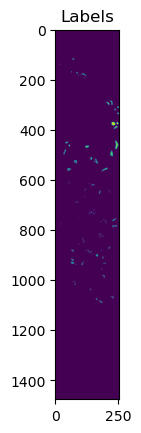

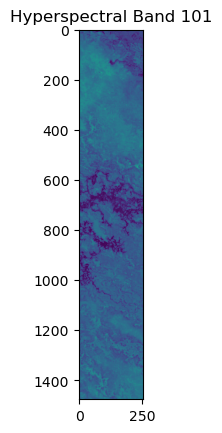

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Botswana_gt.mat'
data_files = 'Botswana.mat'
label_files = 'Botswana_gt'
hypercube_files = 'Botswana'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 3248
Extracted windows shape: (3248, 5, 5, 145)
Corresponding labels shape: (3248,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 5)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 270 samples
Shuffled class indices for class '1'
Selected 5 training samples and 5 validation samples for class '1'

Class: 2: Found 101 samples
Shuffled class indices for class '2'
Selected 5 training samples and 5 validation samples for class '2'

Class: 3: Found 251 samples
Shuffled class indices for class '3'
Selected 5 training samples and 5 validation samples for class '3'

Class: 4: Found 215 samples
Shuffled class indices for class '4'
Selected 5 training samples and 5 validation samples for class '4'

Class: 5: Found 269 samples
Shuffled class indices for class '5'
Selected 5 training samples and 5 validation samples for class '5'

Class: 6: Found 269 samples
Shuffled class indices for class '6'
Selected 5 training samples and 5 validation samples for class '6'

Class: 7: Found 259 samples
Shuffled class indices for class '7'
Selecte

In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 70
Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (2598, 5, 5, 145)
Validation data shape: (650, 5, 5, 145)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

145


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/41], Loss: 0.2204, PSNR: -9.4817


Epoch [1/50] Training Loss: 0.2130, PSNR: -8.8469
	[Val]   Batch [1/11] Loss: 0.2056, PSNR: -6.1676
	[Val]   Batch [10/11] Loss: 0.2058, PSNR: -8.4064
Epoch [1/50] Validation Loss: 0.2056, PSNR: -8.0985

LOG: Epoch [2/50]
	 Training Batch [1/41], Loss: 0.1979, PSNR: -10.4851


Epoch [2/50] Training Loss: 0.1906, PSNR: -8.5301
	[Val]   Batch [1/11] Loss: 0.1769, PSNR: -5.5147
	[Val]   Batch [10/11] Loss: 0.1772, PSNR: -7.7574
Epoch [2/50] Validation Loss: 0.1770, PSNR: -7.4471

LOG: Epoch [3/50]
	 Training Batch [1/41], Loss: 0.1757, PSNR: -9.8376


Epoch [3/50] Training Loss: 0.1695, PSNR: -7.8817
	[Val]   Batch [1/11] Loss: 0.1543, PSNR: -4.9193
	[Val]   Batch [10/11] Loss: 0.1545, PSNR: -7.1612
Epoch [3/50] Validation Loss: 0.1543, PSNR: -6.8506

LOG: Epoch [4/50]
	 Training Batch [1/41], Loss: 0.1549, PSNR: -7.3303


Epoch [4/50] Training Loss: 0.1491, PSNR: -7.2380
	[Val]   Batch [1/11] Loss: 0.1341, PSNR: -4.3122
	[Val]   Batch [10/11] Loss: 0.1343, PSNR: -6.5547
Epoch [4/50] Validation Loss: 0.1341, PSNR: -6.2417

LOG: Epoch [5/50]
	 Training Batch [1/41], Loss: 0.1360, PSNR: -5.9562


Epoch [5/50] Training Loss: 0.1297, PSNR: -6.6993
	[Val]   Batch [1/11] Loss: 0.1142, PSNR: -3.6135
	[Val]   Batch [10/11] Loss: 0.1143, PSNR: -5.8536
Epoch [5/50] Validation Loss: 0.1142, PSNR: -5.5429

LOG: Epoch [6/50]
	 Training Batch [1/41], Loss: 0.1177, PSNR: -6.1685


Epoch [6/50] Training Loss: 0.1120, PSNR: -5.9600
	[Val]   Batch [1/11] Loss: 0.0985, PSNR: -2.9730
	[Val]   Batch [10/11] Loss: 0.0986, PSNR: -5.2119
Epoch [6/50] Validation Loss: 0.0985, PSNR: -4.9039

LOG: Epoch [7/50]
	 Training Batch [1/41], Loss: 0.0995, PSNR: -7.2823


Epoch [7/50] Training Loss: 0.0963, PSNR: -5.3252
	[Val]   Batch [1/11] Loss: 0.0852, PSNR: -2.3407
	[Val]   Batch [10/11] Loss: 0.0852, PSNR: -4.5796
Epoch [7/50] Validation Loss: 0.0852, PSNR: -4.2724

LOG: Epoch [8/50]
	 Training Batch [1/41], Loss: 0.0873, PSNR: -5.7577


Epoch [8/50] Training Loss: 0.0827, PSNR: -4.7421
	[Val]   Batch [1/11] Loss: 0.0744, PSNR: -1.7506
	[Val]   Batch [10/11] Loss: 0.0744, PSNR: -3.9890
Epoch [8/50] Validation Loss: 0.0744, PSNR: -3.6821

LOG: Epoch [9/50]
	 Training Batch [1/41], Loss: 0.0753, PSNR: -6.1340


Epoch [9/50] Training Loss: 0.0712, PSNR: -3.9564
	[Val]   Batch [1/11] Loss: 0.0634, PSNR: -1.0564
	[Val]   Batch [10/11] Loss: 0.0634, PSNR: -3.2944
Epoch [9/50] Validation Loss: 0.0634, PSNR: -2.9875

LOG: Epoch [10/50]
	 Training Batch [1/41], Loss: 0.0643, PSNR: -2.7002


Epoch [10/50] Training Loss: 0.0615, PSNR: -3.4000
	[Val]   Batch [1/11] Loss: 0.0563, PSNR: -0.5409
	[Val]   Batch [10/11] Loss: 0.0563, PSNR: -2.7791
Epoch [10/50] Validation Loss: 0.0563, PSNR: -2.4729

LOG: Epoch [11/50]
	 Training Batch [1/41], Loss: 0.0565, PSNR: -4.8259


Epoch [11/50] Training Loss: 0.0535, PSNR: -2.7815
	[Val]   Batch [1/11] Loss: 0.0493, PSNR: 0.0311
	[Val]   Batch [10/11] Loss: 0.0494, PSNR: -2.2085
Epoch [11/50] Validation Loss: 0.0494, PSNR: -1.9013

LOG: Epoch [12/50]
	 Training Batch [1/41], Loss: 0.0480, PSNR: -3.2755


Epoch [12/50] Training Loss: 0.0469, PSNR: -2.2875
	[Val]   Batch [1/11] Loss: 0.0436, PSNR: 0.5682
	[Val]   Batch [10/11] Loss: 0.0436, PSNR: -1.6698
Epoch [12/50] Validation Loss: 0.0436, PSNR: -1.3644

LOG: Epoch [13/50]
	 Training Batch [1/41], Loss: 0.0428, PSNR: -1.2853


Epoch [13/50] Training Loss: 0.0414, PSNR: -1.7179
	[Val]   Batch [1/11] Loss: 0.0391, PSNR: 1.0422
	[Val]   Batch [10/11] Loss: 0.0391, PSNR: -1.1951
Epoch [13/50] Validation Loss: 0.0391, PSNR: -0.8899

LOG: Epoch [14/50]
	 Training Batch [1/41], Loss: 0.0379, PSNR: 1.1760


Epoch [14/50] Training Loss: 0.0369, PSNR: -1.2589
	[Val]   Batch [1/11] Loss: 0.0350, PSNR: 1.5244
	[Val]   Batch [10/11] Loss: 0.0350, PSNR: -0.7120
Epoch [14/50] Validation Loss: 0.0350, PSNR: -0.4073

LOG: Epoch [15/50]
	 Training Batch [1/41], Loss: 0.0340, PSNR: -1.2864


Epoch [15/50] Training Loss: 0.0330, PSNR: -0.7924
	[Val]   Batch [1/11] Loss: 0.0312, PSNR: 2.0205
	[Val]   Batch [10/11] Loss: 0.0312, PSNR: -0.2166
Epoch [15/50] Validation Loss: 0.0312, PSNR: 0.0888

LOG: Epoch [16/50]
	 Training Batch [1/41], Loss: 0.0301, PSNR: 2.1720


Epoch [16/50] Training Loss: 0.0297, PSNR: -0.2856
	[Val]   Batch [1/11] Loss: 0.0285, PSNR: 2.4173
	[Val]   Batch [10/11] Loss: 0.0285, PSNR: 0.1813
Epoch [16/50] Validation Loss: 0.0285, PSNR: 0.4860

LOG: Epoch [17/50]
	 Training Batch [1/41], Loss: 0.0279, PSNR: -1.9736


Epoch [17/50] Training Loss: 0.0269, PSNR: 0.1984
	[Val]   Batch [1/11] Loss: 0.0258, PSNR: 2.8462
	[Val]   Batch [10/11] Loss: 0.0258, PSNR: 0.6098
Epoch [17/50] Validation Loss: 0.0258, PSNR: 0.9145

LOG: Epoch [18/50]
	 Training Batch [1/41], Loss: 0.0246, PSNR: -0.3716


Epoch [18/50] Training Loss: 0.0245, PSNR: 0.5638
	[Val]   Batch [1/11] Loss: 0.0235, PSNR: 3.2581
	[Val]   Batch [10/11] Loss: 0.0235, PSNR: 1.0215
Epoch [18/50] Validation Loss: 0.0235, PSNR: 1.3272

LOG: Epoch [19/50]
	 Training Batch [1/41], Loss: 0.0234, PSNR: -1.0013


Epoch [19/50] Training Loss: 0.0223, PSNR: 0.9046
	[Val]   Batch [1/11] Loss: 0.0217, PSNR: 3.5967
	[Val]   Batch [10/11] Loss: 0.0217, PSNR: 1.3600
Epoch [19/50] Validation Loss: 0.0217, PSNR: 1.6660

LOG: Epoch [20/50]
	 Training Batch [1/41], Loss: 0.0211, PSNR: 0.2888


Epoch [20/50] Training Loss: 0.0205, PSNR: 1.4481
	[Val]   Batch [1/11] Loss: 0.0198, PSNR: 3.9933
	[Val]   Batch [10/11] Loss: 0.0198, PSNR: 1.7570
Epoch [20/50] Validation Loss: 0.0198, PSNR: 2.0623

LOG: Epoch [21/50]
	 Training Batch [1/41], Loss: 0.0189, PSNR: 0.4662


Epoch [21/50] Training Loss: 0.0188, PSNR: 1.6346
	[Val]   Batch [1/11] Loss: 0.0183, PSNR: 4.3352
	[Val]   Batch [10/11] Loss: 0.0183, PSNR: 2.0985
Epoch [21/50] Validation Loss: 0.0183, PSNR: 2.4044

LOG: Epoch [22/50]
	 Training Batch [1/41], Loss: 0.0180, PSNR: 4.4137


Epoch [22/50] Training Loss: 0.0174, PSNR: 2.1054
	[Val]   Batch [1/11] Loss: 0.0170, PSNR: 4.6573
	[Val]   Batch [10/11] Loss: 0.0170, PSNR: 2.4214
Epoch [22/50] Validation Loss: 0.0170, PSNR: 2.7259

LOG: Epoch [23/50]
	 Training Batch [1/41], Loss: 0.0167, PSNR: 0.2842


Epoch [23/50] Training Loss: 0.0161, PSNR: 2.3660
	[Val]   Batch [1/11] Loss: 0.0157, PSNR: 5.0042
	[Val]   Batch [10/11] Loss: 0.0157, PSNR: 2.7682
Epoch [23/50] Validation Loss: 0.0157, PSNR: 3.0730

LOG: Epoch [24/50]
	 Training Batch [1/41], Loss: 0.0152, PSNR: 5.1377


Epoch [24/50] Training Loss: 0.0150, PSNR: 2.8329
	[Val]   Batch [1/11] Loss: 0.0147, PSNR: 5.2913
	[Val]   Batch [10/11] Loss: 0.0147, PSNR: 3.0550
Epoch [24/50] Validation Loss: 0.0147, PSNR: 3.3607

LOG: Epoch [25/50]
	 Training Batch [1/41], Loss: 0.0143, PSNR: 1.1546


Epoch [25/50] Training Loss: 0.0139, PSNR: 3.0276
	[Val]   Batch [1/11] Loss: 0.0137, PSNR: 5.6035
	[Val]   Batch [10/11] Loss: 0.0137, PSNR: 3.3670
Epoch [25/50] Validation Loss: 0.0137, PSNR: 3.6733

LOG: Epoch [26/50]
	 Training Batch [1/41], Loss: 0.0134, PSNR: 4.1241


Epoch [26/50] Training Loss: 0.0130, PSNR: 3.3502
	[Val]   Batch [1/11] Loss: 0.0128, PSNR: 5.9048
	[Val]   Batch [10/11] Loss: 0.0128, PSNR: 3.6684
Epoch [26/50] Validation Loss: 0.0128, PSNR: 3.9754

LOG: Epoch [27/50]
	 Training Batch [1/41], Loss: 0.0125, PSNR: 2.5699


Epoch [27/50] Training Loss: 0.0122, PSNR: 3.6869
	[Val]   Batch [1/11] Loss: 0.0121, PSNR: 6.1437
	[Val]   Batch [10/11] Loss: 0.0121, PSNR: 3.9070
Epoch [27/50] Validation Loss: 0.0121, PSNR: 4.2134

LOG: Epoch [28/50]
	 Training Batch [1/41], Loss: 0.0115, PSNR: 3.9267


Epoch [28/50] Training Loss: 0.0114, PSNR: 3.9446
	[Val]   Batch [1/11] Loss: 0.0112, PSNR: 6.4854
	[Val]   Batch [10/11] Loss: 0.0112, PSNR: 4.2479
Epoch [28/50] Validation Loss: 0.0112, PSNR: 4.5551

LOG: Epoch [29/50]
	 Training Batch [1/41], Loss: 0.0105, PSNR: 5.1796


Epoch [29/50] Training Loss: 0.0107, PSNR: 4.3268
	[Val]   Batch [1/11] Loss: 0.0106, PSNR: 6.6994
	[Val]   Batch [10/11] Loss: 0.0106, PSNR: 4.4618
Epoch [29/50] Validation Loss: 0.0106, PSNR: 4.7694

LOG: Epoch [30/50]
	 Training Batch [1/41], Loss: 0.0104, PSNR: 3.9795


Epoch [30/50] Training Loss: 0.0101, PSNR: 4.4466
	[Val]   Batch [1/11] Loss: 0.0100, PSNR: 6.9754
	[Val]   Batch [10/11] Loss: 0.0100, PSNR: 4.7374
Epoch [30/50] Validation Loss: 0.0100, PSNR: 5.0456

LOG: Epoch [31/50]
	 Training Batch [1/41], Loss: 0.0095, PSNR: 5.2585


Epoch [31/50] Training Loss: 0.0095, PSNR: 4.7887
	[Val]   Batch [1/11] Loss: 0.0094, PSNR: 7.2434
	[Val]   Batch [10/11] Loss: 0.0094, PSNR: 5.0065
Epoch [31/50] Validation Loss: 0.0094, PSNR: 5.3138

LOG: Epoch [32/50]
	 Training Batch [1/41], Loss: 0.0094, PSNR: 5.9365


Epoch [32/50] Training Loss: 0.0090, PSNR: 4.8176
	[Val]   Batch [1/11] Loss: 0.0089, PSNR: 7.4508
	[Val]   Batch [10/11] Loss: 0.0089, PSNR: 5.2145
Epoch [32/50] Validation Loss: 0.0089, PSNR: 5.5210

LOG: Epoch [33/50]
	 Training Batch [1/41], Loss: 0.0087, PSNR: 4.1355


Epoch [33/50] Training Loss: 0.0085, PSNR: 5.1842
	[Val]   Batch [1/11] Loss: 0.0084, PSNR: 7.7086
	[Val]   Batch [10/11] Loss: 0.0084, PSNR: 5.4726
Epoch [33/50] Validation Loss: 0.0084, PSNR: 5.7794

LOG: Epoch [34/50]
	 Training Batch [1/41], Loss: 0.0080, PSNR: 7.9216


Epoch [34/50] Training Loss: 0.0080, PSNR: 5.4814
	[Val]   Batch [1/11] Loss: 0.0080, PSNR: 7.9487
	[Val]   Batch [10/11] Loss: 0.0080, PSNR: 5.7122
Epoch [34/50] Validation Loss: 0.0080, PSNR: 6.0202

LOG: Epoch [35/50]
	 Training Batch [1/41], Loss: 0.0080, PSNR: 3.3430


Epoch [35/50] Training Loss: 0.0076, PSNR: 5.7043
	[Val]   Batch [1/11] Loss: 0.0076, PSNR: 8.1519
	[Val]   Batch [10/11] Loss: 0.0076, PSNR: 5.9162
Epoch [35/50] Validation Loss: 0.0076, PSNR: 6.2240

LOG: Epoch [36/50]
	 Training Batch [1/41], Loss: 0.0074, PSNR: 4.8731


Epoch [36/50] Training Loss: 0.0073, PSNR: 5.9507
	[Val]   Batch [1/11] Loss: 0.0072, PSNR: 8.3782
	[Val]   Batch [10/11] Loss: 0.0072, PSNR: 6.1426
Epoch [36/50] Validation Loss: 0.0072, PSNR: 6.4502

LOG: Epoch [37/50]
	 Training Batch [1/41], Loss: 0.0071, PSNR: 4.7157


Epoch [37/50] Training Loss: 0.0069, PSNR: 6.0654
	[Val]   Batch [1/11] Loss: 0.0069, PSNR: 8.6034
	[Val]   Batch [10/11] Loss: 0.0069, PSNR: 6.3671
Epoch [37/50] Validation Loss: 0.0068, PSNR: 6.6756

LOG: Epoch [38/50]
	 Training Batch [1/41], Loss: 0.0065, PSNR: 8.8157


Epoch [38/50] Training Loss: 0.0066, PSNR: 6.0949
	[Val]   Batch [1/11] Loss: 0.0066, PSNR: 8.7765
	[Val]   Batch [10/11] Loss: 0.0066, PSNR: 6.5404
Epoch [38/50] Validation Loss: 0.0066, PSNR: 6.8488

LOG: Epoch [39/50]
	 Training Batch [1/41], Loss: 0.0063, PSNR: 5.5192


Epoch [39/50] Training Loss: 0.0063, PSNR: 6.6889
	[Val]   Batch [1/11] Loss: 0.0063, PSNR: 8.9820
	[Val]   Batch [10/11] Loss: 0.0063, PSNR: 6.7461
Epoch [39/50] Validation Loss: 0.0063, PSNR: 7.0547

LOG: Epoch [40/50]
	 Training Batch [1/41], Loss: 0.0063, PSNR: 4.7263


Epoch [40/50] Training Loss: 0.0060, PSNR: 6.7987
	[Val]   Batch [1/11] Loss: 0.0060, PSNR: 9.2168
	[Val]   Batch [10/11] Loss: 0.0060, PSNR: 6.9804
Epoch [40/50] Validation Loss: 0.0059, PSNR: 7.2895

LOG: Epoch [41/50]
	 Training Batch [1/41], Loss: 0.0059, PSNR: 7.3004


Epoch [41/50] Training Loss: 0.0057, PSNR: 6.8503
	[Val]   Batch [1/11] Loss: 0.0057, PSNR: 9.4096
	[Val]   Batch [10/11] Loss: 0.0057, PSNR: 7.1732
Epoch [41/50] Validation Loss: 0.0057, PSNR: 7.4827

LOG: Epoch [42/50]
	 Training Batch [1/41], Loss: 0.0058, PSNR: 7.7641


Epoch [42/50] Training Loss: 0.0055, PSNR: 7.0499
	[Val]   Batch [1/11] Loss: 0.0055, PSNR: 9.5919
	[Val]   Batch [10/11] Loss: 0.0055, PSNR: 7.3552
Epoch [42/50] Validation Loss: 0.0055, PSNR: 7.6646

LOG: Epoch [43/50]
	 Training Batch [1/41], Loss: 0.0051, PSNR: 7.9115


Epoch [43/50] Training Loss: 0.0052, PSNR: 7.4466
	[Val]   Batch [1/11] Loss: 0.0053, PSNR: 9.7579
	[Val]   Batch [10/11] Loss: 0.0053, PSNR: 7.5219
Epoch [43/50] Validation Loss: 0.0052, PSNR: 7.8308

LOG: Epoch [44/50]
	 Training Batch [1/41], Loss: 0.0053, PSNR: 6.7603


Epoch [44/50] Training Loss: 0.0050, PSNR: 7.5128
	[Val]   Batch [1/11] Loss: 0.0050, PSNR: 9.9810
	[Val]   Batch [10/11] Loss: 0.0050, PSNR: 7.7443
Epoch [44/50] Validation Loss: 0.0050, PSNR: 8.0534

LOG: Epoch [45/50]
	 Training Batch [1/41], Loss: 0.0049, PSNR: 8.1060


Epoch [45/50] Training Loss: 0.0048, PSNR: 7.7300
	[Val]   Batch [1/11] Loss: 0.0048, PSNR: 10.1340
	[Val]   Batch [10/11] Loss: 0.0048, PSNR: 7.8979
Epoch [45/50] Validation Loss: 0.0048, PSNR: 8.2066

LOG: Epoch [46/50]
	 Training Batch [1/41], Loss: 0.0047, PSNR: 10.2789


Epoch [46/50] Training Loss: 0.0046, PSNR: 7.7817
	[Val]   Batch [1/11] Loss: 0.0046, PSNR: 10.3041
	[Val]   Batch [10/11] Loss: 0.0046, PSNR: 8.0691
Epoch [46/50] Validation Loss: 0.0046, PSNR: 8.3770

LOG: Epoch [47/50]
	 Training Batch [1/41], Loss: 0.0044, PSNR: 6.2456


Epoch [47/50] Training Loss: 0.0044, PSNR: 8.0983
	[Val]   Batch [1/11] Loss: 0.0044, PSNR: 10.4831
	[Val]   Batch [10/11] Loss: 0.0044, PSNR: 8.2477
Epoch [47/50] Validation Loss: 0.0044, PSNR: 8.5558

LOG: Epoch [48/50]
	 Training Batch [1/41], Loss: 0.0042, PSNR: 8.3228


Epoch [48/50] Training Loss: 0.0043, PSNR: 8.1929
	[Val]   Batch [1/11] Loss: 0.0042, PSNR: 10.6999
	[Val]   Batch [10/11] Loss: 0.0042, PSNR: 8.4637
Epoch [48/50] Validation Loss: 0.0042, PSNR: 8.7727

LOG: Epoch [49/50]
	 Training Batch [1/41], Loss: 0.0040, PSNR: 8.1900


Epoch [49/50] Training Loss: 0.0041, PSNR: 8.3895
	[Val]   Batch [1/11] Loss: 0.0041, PSNR: 10.8190
	[Val]   Batch [10/11] Loss: 0.0041, PSNR: 8.5836
Epoch [49/50] Validation Loss: 0.0041, PSNR: 8.8931

LOG: Epoch [50/50]
	 Training Batch [1/41], Loss: 0.0040, PSNR: 7.5322


Epoch [50/50] Training Loss: 0.0039, PSNR: 8.4363
	[Val]   Batch [1/11] Loss: 0.0039, PSNR: 11.0081
	[Val]   Batch [10/11] Loss: 0.0039, PSNR: 8.7726
Epoch [50/50] Validation Loss: 0.0039, PSNR: 9.0818


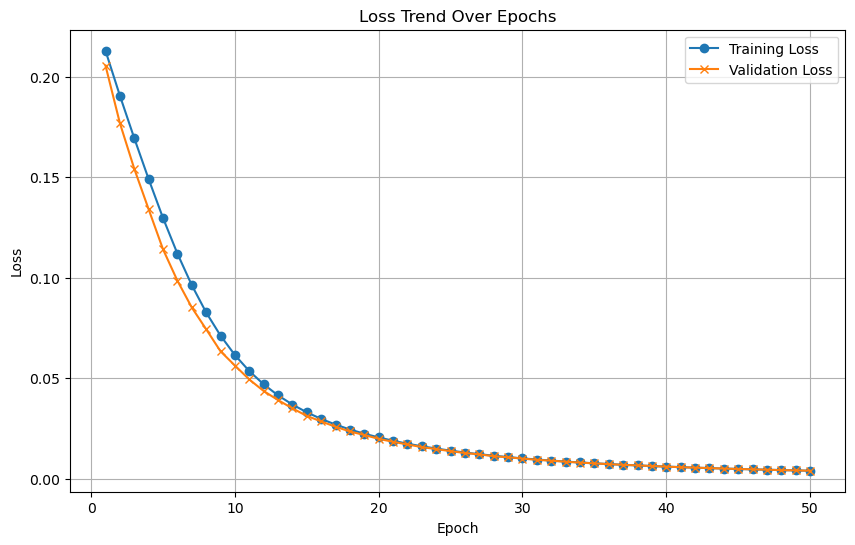

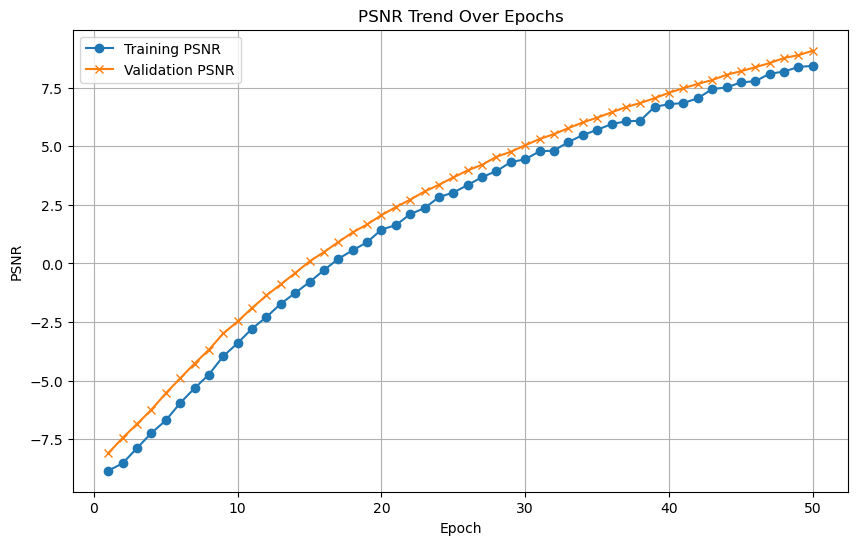

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/13 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training


Epoch [1/1000] completed, Average Training Loss: 2.6686
    Validation Batch [1/1], Loss: 2.6433
Validation Loss: 2.6433, Validation Accuracy: 7.14%
Validation loss improved from inf to 2.6433. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.5989
    Validation Batch [1/1], Loss: 2.6433
Validation Loss: 2.6433, Validation Accuracy: 7.14%
Validation loss improved from 2.6433 to 2.6433. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.5842
    Validation Batch [1/1], Loss: 2.6433
Validation Loss: 2.6433, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.5439
    Validation Batch [1/1], Loss: 2.6433
Validation Loss: 2.6433, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Average Training Loss: 2.53

    Validation Batch [1/1], Loss: 2.6443
Validation Loss: 2.6443, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 2.3031
    Validation Batch [1/1], Loss: 2.6444
Validation Loss: 2.6444, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 2.2863
    Validation Batch [1/1], Loss: 2.6445
Validation Loss: 2.6445, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 2.2386
    Validation Batch [1/1], Loss: 2.6446
Validation Loss: 2.6446, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [25/1000] - Training
Epoch [25/1000] completed, Average Training Loss: 2.2391
    Validation Batch [1/1], Loss: 2.6447
Validation Loss: 2.6447, Va

    Validation Batch [1/1], Loss: 2.6458
Validation Loss: 2.6458, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [33/1000] - Training
Epoch [33/1000] completed, Average Training Loss: 2.1824
    Validation Batch [1/1], Loss: 2.6458
Validation Loss: 2.6458, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [34/1000] - Training
Epoch [34/1000] completed, Average Training Loss: 2.2045
    Validation Batch [1/1], Loss: 2.6458
Validation Loss: 2.6458, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [35/1000] - Training
Epoch [35/1000] completed, Average Training Loss: 2.1756
    Validation Batch [1/1], Loss: 2.6457
Validation Loss: 2.6457, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [36/1000] - Training
Epoch [36/1000] completed, Average Training Loss: 2.1990
    Validation Batch [1/1], Loss: 2.6456
Validation Loss: 2.6456, Va

    Validation Batch [1/1], Loss: 2.6374
Validation Loss: 2.6374, Validation Accuracy: 7.14%
Validation loss improved from 2.6387 to 2.6374. Saving model...

LOG: Epoch [52/1000] - Training
Epoch [52/1000] completed, Average Training Loss: 1.9687
    Validation Batch [1/1], Loss: 2.6362
Validation Loss: 2.6362, Validation Accuracy: 7.14%
Validation loss improved from 2.6374 to 2.6362. Saving model...

LOG: Epoch [53/1000] - Training
Epoch [53/1000] completed, Average Training Loss: 1.9845
    Validation Batch [1/1], Loss: 2.6348
Validation Loss: 2.6348, Validation Accuracy: 7.14%
Validation loss improved from 2.6362 to 2.6348. Saving model...

LOG: Epoch [54/1000] - Training
Epoch [54/1000] completed, Average Training Loss: 1.9881
    Validation Batch [1/1], Loss: 2.6332
Validation Loss: 2.6332, Validation Accuracy: 7.14%
Validation loss improved from 2.6348 to 2.6332. Saving model...

LOG: Epoch [55/1000] - Training
Epoch [55/1000] completed, Average Training Loss: 1.9692
    Validati

    Validation Batch [1/1], Loss: 2.6024
Validation Loss: 2.6024, Validation Accuracy: 12.86%
Validation loss improved from 2.6087 to 2.6024. Saving model...

LOG: Epoch [62/1000] - Training
Epoch [62/1000] completed, Average Training Loss: 1.9371
    Validation Batch [1/1], Loss: 2.5945
Validation Loss: 2.5945, Validation Accuracy: 12.86%
Validation loss improved from 2.6024 to 2.5945. Saving model...

LOG: Epoch [63/1000] - Training
Epoch [63/1000] completed, Average Training Loss: 1.9092
    Validation Batch [1/1], Loss: 2.5857
Validation Loss: 2.5857, Validation Accuracy: 14.29%
Validation loss improved from 2.5945 to 2.5857. Saving model...

LOG: Epoch [64/1000] - Training
Epoch [64/1000] completed, Average Training Loss: 1.8931
    Validation Batch [1/1], Loss: 2.5777
Validation Loss: 2.5777, Validation Accuracy: 17.14%
Validation loss improved from 2.5857 to 2.5777. Saving model...

LOG: Epoch [65/1000] - Training
Epoch [65/1000] completed, Average Training Loss: 1.9073
    Vali

Epoch [80/1000] completed, Average Training Loss: 1.7213
    Validation Batch [1/1], Loss: 2.2777
Validation Loss: 2.2777, Validation Accuracy: 40.00%
Validation loss improved from 2.3047 to 2.2777. Saving model...

LOG: Epoch [81/1000] - Training
Epoch [81/1000] completed, Average Training Loss: 1.7686
    Validation Batch [1/1], Loss: 2.2586
Validation Loss: 2.2586, Validation Accuracy: 38.57%
Validation loss improved from 2.2777 to 2.2586. Saving model...

LOG: Epoch [82/1000] - Training
Epoch [82/1000] completed, Average Training Loss: 1.7233
    Validation Batch [1/1], Loss: 2.2346
Validation Loss: 2.2346, Validation Accuracy: 40.00%
Validation loss improved from 2.2586 to 2.2346. Saving model...

LOG: Epoch [83/1000] - Training
Epoch [83/1000] completed, Average Training Loss: 1.7509
    Validation Batch [1/1], Loss: 2.2036
Validation Loss: 2.2036, Validation Accuracy: 38.57%
Validation loss improved from 2.2346 to 2.2036. Saving model...

LOG: Epoch [84/1000] - Training
Epoch [8

Epoch [89/1000] completed, Average Training Loss: 1.7295
    Validation Batch [1/1], Loss: 2.0467
Validation Loss: 2.0467, Validation Accuracy: 47.14%
Validation loss improved from 2.0847 to 2.0467. Saving model...

LOG: Epoch [90/1000] - Training
Epoch [90/1000] completed, Average Training Loss: 1.7350
    Validation Batch [1/1], Loss: 2.0131
Validation Loss: 2.0131, Validation Accuracy: 51.43%
Validation loss improved from 2.0467 to 2.0131. Saving model...

LOG: Epoch [91/1000] - Training
Epoch [91/1000] completed, Average Training Loss: 1.6722
    Validation Batch [1/1], Loss: 1.9904
Validation Loss: 1.9904, Validation Accuracy: 55.71%
Validation loss improved from 2.0131 to 1.9904. Saving model...

LOG: Epoch [92/1000] - Training
Epoch [92/1000] completed, Average Training Loss: 1.6675
    Validation Batch [1/1], Loss: 1.9723
Validation Loss: 1.9723, Validation Accuracy: 51.43%
Validation loss improved from 1.9904 to 1.9723. Saving model...

LOG: Epoch [93/1000] - Training
Epoch [9

Epoch [109/1000] completed, Average Training Loss: 1.5373
    Validation Batch [1/1], Loss: 1.7376
Validation Loss: 1.7376, Validation Accuracy: 64.29%
Validation loss improved from 1.7567 to 1.7376. Saving model...

LOG: Epoch [110/1000] - Training
Epoch [110/1000] completed, Average Training Loss: 1.5547
    Validation Batch [1/1], Loss: 1.7331
Validation Loss: 1.7331, Validation Accuracy: 60.00%
Validation loss improved from 1.7376 to 1.7331. Saving model...

LOG: Epoch [111/1000] - Training
Epoch [111/1000] completed, Average Training Loss: 1.5341
    Validation Batch [1/1], Loss: 1.7271
Validation Loss: 1.7271, Validation Accuracy: 61.43%
Validation loss improved from 1.7331 to 1.7271. Saving model...

LOG: Epoch [112/1000] - Training
Epoch [112/1000] completed, Average Training Loss: 1.5411
    Validation Batch [1/1], Loss: 1.7080
Validation Loss: 1.7080, Validation Accuracy: 65.71%
Validation loss improved from 1.7271 to 1.7080. Saving model...

LOG: Epoch [113/1000] - Training


Epoch [120/1000] completed, Average Training Loss: 1.4560
    Validation Batch [1/1], Loss: 1.6637
Validation Loss: 1.6637, Validation Accuracy: 68.57%
Validation loss improved from 1.6675 to 1.6637. Saving model...

LOG: Epoch [121/1000] - Training
Epoch [121/1000] completed, Average Training Loss: 1.4930
    Validation Batch [1/1], Loss: 1.6535
Validation Loss: 1.6535, Validation Accuracy: 64.29%
Validation loss improved from 1.6637 to 1.6535. Saving model...

LOG: Epoch [122/1000] - Training
Epoch [122/1000] completed, Average Training Loss: 1.4162
    Validation Batch [1/1], Loss: 1.6449
Validation Loss: 1.6449, Validation Accuracy: 65.71%
Validation loss improved from 1.6535 to 1.6449. Saving model...

LOG: Epoch [123/1000] - Training
Epoch [123/1000] completed, Average Training Loss: 1.4512
    Validation Batch [1/1], Loss: 1.6323
Validation Loss: 1.6323, Validation Accuracy: 64.29%
Validation loss improved from 1.6449 to 1.6323. Saving model...

LOG: Epoch [124/1000] - Training


Epoch [138/1000] completed, Average Training Loss: 1.3229
    Validation Batch [1/1], Loss: 1.5479
Validation Loss: 1.5479, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [139/1000] - Training
Epoch [139/1000] completed, Average Training Loss: 1.3353
    Validation Batch [1/1], Loss: 1.5550
Validation Loss: 1.5550, Validation Accuracy: 68.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [140/1000] - Training
Epoch [140/1000] completed, Average Training Loss: 1.2599
    Validation Batch [1/1], Loss: 1.5525
Validation Loss: 1.5525, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [141/1000] - Training
Epoch [141/1000] completed, Average Training Loss: 1.2570
    Validation Batch [1/1], Loss: 1.5274
Validation Loss: 1.5274, Validation Accuracy: 68.57%
Validation loss improved from 1.5472 to 1.5274. Saving model...

LOG: Epoch [142/1000] - Training
Epoch [142/1000] completed, Average Training 

Epoch [149/1000] completed, Average Training Loss: 1.2684
    Validation Batch [1/1], Loss: 1.4897
Validation Loss: 1.4897, Validation Accuracy: 74.29%
Validation loss improved from 1.4920 to 1.4897. Saving model...

LOG: Epoch [150/1000] - Training
Epoch [150/1000] completed, Average Training Loss: 1.1857
    Validation Batch [1/1], Loss: 1.4874
Validation Loss: 1.4874, Validation Accuracy: 75.71%
Validation loss improved from 1.4897 to 1.4874. Saving model...

LOG: Epoch [151/1000] - Training
Epoch [151/1000] completed, Average Training Loss: 1.1916
    Validation Batch [1/1], Loss: 1.4787
Validation Loss: 1.4787, Validation Accuracy: 74.29%
Validation loss improved from 1.4874 to 1.4787. Saving model...

LOG: Epoch [152/1000] - Training
Epoch [152/1000] completed, Average Training Loss: 1.2294
    Validation Batch [1/1], Loss: 1.4684
Validation Loss: 1.4684, Validation Accuracy: 80.00%
Validation loss improved from 1.4787 to 1.4684. Saving model...

LOG: Epoch [153/1000] - Training


    Validation Batch [1/1], Loss: 1.3919
Validation Loss: 1.3919, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [167/1000] - Training
Epoch [167/1000] completed, Average Training Loss: 1.0814
    Validation Batch [1/1], Loss: 1.3849
Validation Loss: 1.3849, Validation Accuracy: 74.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [168/1000] - Training
Epoch [168/1000] completed, Average Training Loss: 1.0608
    Validation Batch [1/1], Loss: 1.3461
Validation Loss: 1.3461, Validation Accuracy: 81.43%
Validation loss improved from 1.3648 to 1.3461. Saving model...

LOG: Epoch [169/1000] - Training
Epoch [169/1000] completed, Average Training Loss: 1.0171
    Validation Batch [1/1], Loss: 1.3291
Validation Loss: 1.3291, Validation Accuracy: 80.00%
Validation loss improved from 1.3461 to 1.3291. Saving model...

LOG: Epoch [170/1000] - Training
Epoch [170/1000] completed, Average Training Loss: 1.0592
    Validation Batch [1/1], Lo

Epoch [177/1000] completed, Average Training Loss: 1.0301
    Validation Batch [1/1], Loss: 1.3025
Validation Loss: 1.3025, Validation Accuracy: 80.00%
Validation loss improved from 1.3188 to 1.3025. Saving model...

LOG: Epoch [178/1000] - Training
Epoch [178/1000] completed, Average Training Loss: 1.0034
    Validation Batch [1/1], Loss: 1.2775
Validation Loss: 1.2775, Validation Accuracy: 82.86%
Validation loss improved from 1.3025 to 1.2775. Saving model...

LOG: Epoch [179/1000] - Training
Epoch [179/1000] completed, Average Training Loss: 1.0041
    Validation Batch [1/1], Loss: 1.2734
Validation Loss: 1.2734, Validation Accuracy: 80.00%
Validation loss improved from 1.2775 to 1.2734. Saving model...

LOG: Epoch [180/1000] - Training
Epoch [180/1000] completed, Average Training Loss: 0.9587
    Validation Batch [1/1], Loss: 1.2931
Validation Loss: 1.2931, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [181/1000] - Training
Epoch [181/1000

    Validation Batch [1/1], Loss: 1.2254
Validation Loss: 1.2254, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [196/1000] - Training
Epoch [196/1000] completed, Average Training Loss: 0.8806
    Validation Batch [1/1], Loss: 1.2419
Validation Loss: 1.2419, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [197/1000] - Training
Epoch [197/1000] completed, Average Training Loss: 0.8493
    Validation Batch [1/1], Loss: 1.2445
Validation Loss: 1.2445, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [198/1000] - Training
Epoch [198/1000] completed, Average Training Loss: 0.8319
    Validation Batch [1/1], Loss: 1.2347
Validation Loss: 1.2347, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [199/1000] - Training
Epoch [199/1000] completed, Average Training Loss: 0.9419
    Validation Batch [1/1], Loss: 1.2066
Validation Loss: 1.

Epoch [204/1000] completed, Average Training Loss: 0.8016
    Validation Batch [1/1], Loss: 1.1516
Validation Loss: 1.1516, Validation Accuracy: 84.29%
Validation loss improved from 1.1541 to 1.1516. Saving model...

LOG: Epoch [205/1000] - Training
Epoch [205/1000] completed, Average Training Loss: 0.8740
    Validation Batch [1/1], Loss: 1.1613
Validation Loss: 1.1613, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [206/1000] - Training
Epoch [206/1000] completed, Average Training Loss: 0.8109
    Validation Batch [1/1], Loss: 1.1567
Validation Loss: 1.1567, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [207/1000] - Training
Epoch [207/1000] completed, Average Training Loss: 0.8053
    Validation Batch [1/1], Loss: 1.1654
Validation Loss: 1.1654, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [208/1000] - Training
Epoch [208/1000] completed, Average Training 

Epoch [226/1000] completed, Average Training Loss: 0.7061
    Validation Batch [1/1], Loss: 1.0614
Validation Loss: 1.0614, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [227/1000] - Training
Epoch [227/1000] completed, Average Training Loss: 0.7071
    Validation Batch [1/1], Loss: 1.0683
Validation Loss: 1.0683, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [228/1000] - Training
Epoch [228/1000] completed, Average Training Loss: 0.6715
    Validation Batch [1/1], Loss: 1.0660
Validation Loss: 1.0660, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [229/1000] - Training
Epoch [229/1000] completed, Average Training Loss: 0.7321
    Validation Batch [1/1], Loss: 1.0431
Validation Loss: 1.0431, Validation Accuracy: 81.43%
Validation loss improved from 1.0551 to 1.0431. Saving model...

LOG: Epoch [230/1000] - Training
Epoch [230/1000] completed, Average Training 

Epoch [235/1000] completed, Average Training Loss: 0.6381
    Validation Batch [1/1], Loss: 0.9747
Validation Loss: 0.9747, Validation Accuracy: 85.71%
Validation loss improved from 0.9979 to 0.9747. Saving model...

LOG: Epoch [236/1000] - Training
Epoch [236/1000] completed, Average Training Loss: 0.6118
    Validation Batch [1/1], Loss: 0.9892
Validation Loss: 0.9892, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [237/1000] - Training
Epoch [237/1000] completed, Average Training Loss: 0.6573
    Validation Batch [1/1], Loss: 0.9934
Validation Loss: 0.9934, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [238/1000] - Training
Epoch [238/1000] completed, Average Training Loss: 0.6370
    Validation Batch [1/1], Loss: 0.9800
Validation Loss: 0.9800, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [239/1000] - Training
Epoch [239/1000] completed, Average Training 

Epoch [256/1000] completed, Average Training Loss: 0.5420
    Validation Batch [1/1], Loss: 0.8840
Validation Loss: 0.8840, Validation Accuracy: 87.14%
Validation loss improved from 0.9060 to 0.8840. Saving model...

LOG: Epoch [257/1000] - Training
Epoch [257/1000] completed, Average Training Loss: 0.5032
    Validation Batch [1/1], Loss: 0.8639
Validation Loss: 0.8639, Validation Accuracy: 85.71%
Validation loss improved from 0.8840 to 0.8639. Saving model...

LOG: Epoch [258/1000] - Training
Epoch [258/1000] completed, Average Training Loss: 0.5383
    Validation Batch [1/1], Loss: 0.8699
Validation Loss: 0.8699, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [259/1000] - Training
Epoch [259/1000] completed, Average Training Loss: 0.5291
    Validation Batch [1/1], Loss: 0.8910
Validation Loss: 0.8910, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [260/1000] - Training
Epoch [260/1000] completed, Av

Epoch [263/1000] completed, Average Training Loss: 0.5176
    Validation Batch [1/1], Loss: 0.8829
Validation Loss: 0.8829, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [264/1000] - Training
Epoch [264/1000] completed, Average Training Loss: 0.4948
    Validation Batch [1/1], Loss: 0.9158
Validation Loss: 0.9158, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [265/1000] - Training
Epoch [265/1000] completed, Average Training Loss: 0.5265
    Validation Batch [1/1], Loss: 0.8851
Validation Loss: 0.8851, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [266/1000] - Training
Epoch [266/1000] completed, Average Training Loss: 0.4781
    Validation Batch [1/1], Loss: 0.8493
Validation Loss: 0.8493, Validation Accuracy: 84.29%
Validation loss improved from 0.8639 to 0.8493. Saving model...

LOG: Epoch [267/1000] - Training
Epoch [267/1000] completed, Average Training 

Epoch [284/1000] completed, Average Training Loss: 0.3925
    Validation Batch [1/1], Loss: 0.8063
Validation Loss: 0.8063, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [285/1000] - Training
Epoch [285/1000] completed, Average Training Loss: 0.4253
    Validation Batch [1/1], Loss: 0.7841
Validation Loss: 0.7841, Validation Accuracy: 85.71%
Validation loss improved from 0.8044 to 0.7841. Saving model...

LOG: Epoch [286/1000] - Training
Epoch [286/1000] completed, Average Training Loss: 0.3535
    Validation Batch [1/1], Loss: 0.7801
Validation Loss: 0.7801, Validation Accuracy: 85.71%
Validation loss improved from 0.7841 to 0.7801. Saving model...

LOG: Epoch [287/1000] - Training
Epoch [287/1000] completed, Average Training Loss: 0.4438
    Validation Batch [1/1], Loss: 0.7725
Validation Loss: 0.7725, Validation Accuracy: 87.14%
Validation loss improved from 0.7801 to 0.7725. Saving model...

LOG: Epoch [288/1000] - Training
Epoch [288/100

Epoch [294/1000] completed, Average Training Loss: 0.3947
    Validation Batch [1/1], Loss: 0.7347
Validation Loss: 0.7347, Validation Accuracy: 87.14%
Validation loss improved from 0.7468 to 0.7347. Saving model...

LOG: Epoch [295/1000] - Training
Epoch [295/1000] completed, Average Training Loss: 0.3526
    Validation Batch [1/1], Loss: 0.7450
Validation Loss: 0.7450, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [296/1000] - Training
Epoch [296/1000] completed, Average Training Loss: 0.3210
    Validation Batch [1/1], Loss: 0.7627
Validation Loss: 0.7627, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [297/1000] - Training
Epoch [297/1000] completed, Average Training Loss: 0.3969
    Validation Batch [1/1], Loss: 0.7800
Validation Loss: 0.7800, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [298/1000] - Training
Epoch [298/1000] completed, Average Training 

Epoch [312/1000] completed, Average Training Loss: 0.3257
    Validation Batch [1/1], Loss: 0.6879
Validation Loss: 0.6879, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [313/1000] - Training
Epoch [313/1000] completed, Average Training Loss: 0.3302
    Validation Batch [1/1], Loss: 0.7038
Validation Loss: 0.7038, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [314/1000] - Training
Epoch [314/1000] completed, Average Training Loss: 0.2918
    Validation Batch [1/1], Loss: 0.7169
Validation Loss: 0.7169, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [315/1000] - Training
Epoch [315/1000] completed, Average Training Loss: 0.2904
    Validation Batch [1/1], Loss: 0.7392
Validation Loss: 0.7392, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [316/1000] - Training
Epoch [316/1000] completed, Average Training Loss: 0.3492
  

Epoch [322/1000] completed, Average Training Loss: 0.2993
    Validation Batch [1/1], Loss: 0.6580
Validation Loss: 0.6580, Validation Accuracy: 85.71%
Validation loss improved from 0.6671 to 0.6580. Saving model...

LOG: Epoch [323/1000] - Training
Epoch [323/1000] completed, Average Training Loss: 0.3145
    Validation Batch [1/1], Loss: 0.6584
Validation Loss: 0.6584, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [324/1000] - Training
Epoch [324/1000] completed, Average Training Loss: 0.3614
    Validation Batch [1/1], Loss: 0.6680
Validation Loss: 0.6680, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [325/1000] - Training
Epoch [325/1000] completed, Average Training Loss: 0.2665
    Validation Batch [1/1], Loss: 0.6810
Validation Loss: 0.6810, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [326/1000] - Training
Epoch [326/1000] completed, Average Training 

Epoch [342/1000] completed, Average Training Loss: 0.2688
    Validation Batch [1/1], Loss: 0.6540
Validation Loss: 0.6540, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [343/1000] - Training
Epoch [343/1000] completed, Average Training Loss: 0.2688
    Validation Batch [1/1], Loss: 0.6555
Validation Loss: 0.6555, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [344/1000] - Training
Epoch [344/1000] completed, Average Training Loss: 0.2455
    Validation Batch [1/1], Loss: 0.6676
Validation Loss: 0.6676, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [345/1000] - Training
Epoch [345/1000] completed, Average Training Loss: 0.2756
    Validation Batch [1/1], Loss: 0.6209
Validation Loss: 0.6209, Validation Accuracy: 85.71%
Validation loss improved from 0.6364 to 0.6209. Saving model...

LOG: Epoch [346/1000] - Training
Epoch [346/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.6401
Validation Loss: 0.6401, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [353/1000] - Training
Epoch [353/1000] completed, Average Training Loss: 0.2707
    Validation Batch [1/1], Loss: 0.6452
Validation Loss: 0.6452, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [354/1000] - Training
Epoch [354/1000] completed, Average Training Loss: 0.2841
    Validation Batch [1/1], Loss: 0.6336
Validation Loss: 0.6336, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [355/1000] - Training
Epoch [355/1000] completed, Average Training Loss: 0.2456
    Validation Batch [1/1], Loss: 0.6124
Validation Loss: 0.6124, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [356/1000] - Training
Epoch [356/1000] completed, Average Training Loss: 0.2303
    Validation Batch [1/1], Loss: 0.6019
Validation Loss: 0.

Epoch [369/1000] completed, Average Training Loss: 0.2087
    Validation Batch [1/1], Loss: 0.5732
Validation Loss: 0.5732, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [370/1000] - Training
Epoch [370/1000] completed, Average Training Loss: 0.2186
    Validation Batch [1/1], Loss: 0.5970
Validation Loss: 0.5970, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [371/1000] - Training
Epoch [371/1000] completed, Average Training Loss: 0.2183
    Validation Batch [1/1], Loss: 0.6284
Validation Loss: 0.6284, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [372/1000] - Training
Epoch [372/1000] completed, Average Training Loss: 0.2018
    Validation Batch [1/1], Loss: 0.6215
Validation Loss: 0.6215, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [373/1000] - Training
Epoch [373/1000] completed, Average Training Loss: 0.2452


Epoch [382/1000] completed, Average Training Loss: 0.1980
    Validation Batch [1/1], Loss: 0.5599
Validation Loss: 0.5599, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [383/1000] - Training
Epoch [383/1000] completed, Average Training Loss: 0.1700
    Validation Batch [1/1], Loss: 0.5588
Validation Loss: 0.5588, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [384/1000] - Training
Epoch [384/1000] completed, Average Training Loss: 0.2027
    Validation Batch [1/1], Loss: 0.5664
Validation Loss: 0.5664, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [385/1000] - Training
Epoch [385/1000] completed, Average Training Loss: 0.1906
    Validation Batch [1/1], Loss: 0.5792
Validation Loss: 0.5792, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [386/1000] - Training
Epoch [386/1000] completed, Average Training Loss: 0.2492
  

Epoch [400/1000] completed, Average Training Loss: 0.1540
    Validation Batch [1/1], Loss: 0.5890
Validation Loss: 0.5890, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [401/1000] - Training
Epoch [401/1000] completed, Average Training Loss: 0.2060
    Validation Batch [1/1], Loss: 0.6042
Validation Loss: 0.6042, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [402/1000] - Training
Epoch [402/1000] completed, Average Training Loss: 0.1547
    Validation Batch [1/1], Loss: 0.5919
Validation Loss: 0.5919, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [403/1000] - Training
Epoch [403/1000] completed, Average Training Loss: 0.2031
    Validation Batch [1/1], Loss: 0.5623
Validation Loss: 0.5623, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [404/1000] - Training
Epoch [404/1000] completed, Average Training Loss: 0.167

Epoch [413/1000] completed, Average Training Loss: 0.1789
    Validation Batch [1/1], Loss: 0.5276
Validation Loss: 0.5276, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [414/1000] - Training
Epoch [414/1000] completed, Average Training Loss: 0.1577
    Validation Batch [1/1], Loss: 0.5415
Validation Loss: 0.5415, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [415/1000] - Training
Epoch [415/1000] completed, Average Training Loss: 0.1645
    Validation Batch [1/1], Loss: 0.5407
Validation Loss: 0.5407, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [416/1000] - Training
Epoch [416/1000] completed, Average Training Loss: 0.1820
    Validation Batch [1/1], Loss: 0.5361
Validation Loss: 0.5361, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [417/1000] - Training
Epoch [417/1000] completed, Average Training Loss: 0.1779
  

Epoch [430/1000] completed, Average Training Loss: 0.1426
    Validation Batch [1/1], Loss: 0.5894
Validation Loss: 0.5894, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [431/1000] - Training
Epoch [431/1000] completed, Average Training Loss: 0.1514
    Validation Batch [1/1], Loss: 0.5574
Validation Loss: 0.5574, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [432/1000] - Training
Epoch [432/1000] completed, Average Training Loss: 0.1287
    Validation Batch [1/1], Loss: 0.5397
Validation Loss: 0.5397, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [433/1000] - Training
Epoch [433/1000] completed, Average Training Loss: 0.1298
    Validation Batch [1/1], Loss: 0.5227
Validation Loss: 0.5227, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [434/1000] - Training
Epoch [434/1000] completed, Average Training Loss: 0.177

    Validation Batch [1/1], Loss: 0.6121
Validation Loss: 0.6121, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [441/1000] - Training
Epoch [441/1000] completed, Average Training Loss: 0.1234
    Validation Batch [1/1], Loss: 0.5576
Validation Loss: 0.5576, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [442/1000] - Training
Epoch [442/1000] completed, Average Training Loss: 0.1672
    Validation Batch [1/1], Loss: 0.5163
Validation Loss: 0.5163, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [443/1000] - Training
Epoch [443/1000] completed, Average Training Loss: 0.1255
    Validation Batch [1/1], Loss: 0.5045
Validation Loss: 0.5045, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [444/1000] - Training
Epoch [444/1000] completed, Average Training Loss: 0.1338
    Validation Batch [1/1], Loss: 0.4950
Validation Loss

Epoch [460/1000] completed, Average Training Loss: 0.1330
    Validation Batch [1/1], Loss: 0.4674
Validation Loss: 0.4674, Validation Accuracy: 87.14%
Validation loss improved from 0.4781 to 0.4674. Saving model...

LOG: Epoch [461/1000] - Training
Epoch [461/1000] completed, Average Training Loss: 0.1147
    Validation Batch [1/1], Loss: 0.4517
Validation Loss: 0.4517, Validation Accuracy: 88.57%
Validation loss improved from 0.4674 to 0.4517. Saving model...

LOG: Epoch [462/1000] - Training
Epoch [462/1000] completed, Average Training Loss: 0.1250
    Validation Batch [1/1], Loss: 0.4567
Validation Loss: 0.4567, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [463/1000] - Training
Epoch [463/1000] completed, Average Training Loss: 0.1171
    Validation Batch [1/1], Loss: 0.5104
Validation Loss: 0.5104, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [464/1000] - Training
Epoch [464/1000] completed, Av

Epoch [468/1000] completed, Average Training Loss: 0.1238
    Validation Batch [1/1], Loss: 0.4790
Validation Loss: 0.4790, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [469/1000] - Training
Epoch [469/1000] completed, Average Training Loss: 0.1318
    Validation Batch [1/1], Loss: 0.4760
Validation Loss: 0.4760, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [470/1000] - Training
Epoch [470/1000] completed, Average Training Loss: 0.0926
    Validation Batch [1/1], Loss: 0.4883
Validation Loss: 0.4883, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [471/1000] - Training
Epoch [471/1000] completed, Average Training Loss: 0.1231
    Validation Batch [1/1], Loss: 0.4941
Validation Loss: 0.4941, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [472/1000] - Training
Epoch [472/1000] completed, Average Training Loss: 0.1183
 

Epoch [493/1000] completed, Average Training Loss: 0.0992
    Validation Batch [1/1], Loss: 0.4811
Validation Loss: 0.4811, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [494/1000] - Training
Epoch [494/1000] completed, Average Training Loss: 0.1111
    Validation Batch [1/1], Loss: 0.4826
Validation Loss: 0.4826, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [495/1000] - Training
Epoch [495/1000] completed, Average Training Loss: 0.1244
    Validation Batch [1/1], Loss: 0.4973
Validation Loss: 0.4973, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [496/1000] - Training
Epoch [496/1000] completed, Average Training Loss: 0.1059
    Validation Batch [1/1], Loss: 0.4897
Validation Loss: 0.4897, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [497/1000] - Training
Epoch [497/1000] completed, Average Training Loss: 0.0859
  

Epoch [499/1000] completed, Average Training Loss: 0.0820
    Validation Batch [1/1], Loss: 0.4348
Validation Loss: 0.4348, Validation Accuracy: 88.57%
Validation loss improved from 0.4455 to 0.4348. Saving model...

LOG: Epoch [500/1000] - Training
Epoch [500/1000] completed, Average Training Loss: 0.1106
    Validation Batch [1/1], Loss: 0.4334
Validation Loss: 0.4334, Validation Accuracy: 88.57%
Validation loss improved from 0.4348 to 0.4334. Saving model...

LOG: Epoch [501/1000] - Training
Epoch [501/1000] completed, Average Training Loss: 0.1010
    Validation Batch [1/1], Loss: 0.4454
Validation Loss: 0.4454, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [502/1000] - Training
Epoch [502/1000] completed, Average Training Loss: 0.1034
    Validation Batch [1/1], Loss: 0.4725
Validation Loss: 0.4725, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [503/1000] - Training
Epoch [503/1000] completed, Av

Epoch [520/1000] completed, Average Training Loss: 0.0997
    Validation Batch [1/1], Loss: 0.4285
Validation Loss: 0.4285, Validation Accuracy: 88.57%
Validation loss improved from 0.4334 to 0.4285. Saving model...

LOG: Epoch [521/1000] - Training
Epoch [521/1000] completed, Average Training Loss: 0.1114
    Validation Batch [1/1], Loss: 0.4201
Validation Loss: 0.4201, Validation Accuracy: 88.57%
Validation loss improved from 0.4285 to 0.4201. Saving model...

LOG: Epoch [522/1000] - Training
Epoch [522/1000] completed, Average Training Loss: 0.0980
    Validation Batch [1/1], Loss: 0.4227
Validation Loss: 0.4227, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [523/1000] - Training
Epoch [523/1000] completed, Average Training Loss: 0.0651
    Validation Batch [1/1], Loss: 0.4201
Validation Loss: 0.4201, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [524/1000] - Training
Epoch [524/1000] completed, Av

Epoch [526/1000] completed, Average Training Loss: 0.0991
    Validation Batch [1/1], Loss: 0.3923
Validation Loss: 0.3923, Validation Accuracy: 88.57%
Validation loss improved from 0.4055 to 0.3923. Saving model...

LOG: Epoch [527/1000] - Training
Epoch [527/1000] completed, Average Training Loss: 0.1136
    Validation Batch [1/1], Loss: 0.4026
Validation Loss: 0.4026, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [528/1000] - Training
Epoch [528/1000] completed, Average Training Loss: 0.0885
    Validation Batch [1/1], Loss: 0.4152
Validation Loss: 0.4152, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [529/1000] - Training
Epoch [529/1000] completed, Average Training Loss: 0.0860
    Validation Batch [1/1], Loss: 0.4351
Validation Loss: 0.4351, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [530/1000] - Training
Epoch [530/1000] completed, Average Training 

Epoch [549/1000] completed, Average Training Loss: 0.0737
    Validation Batch [1/1], Loss: 0.5873
Validation Loss: 0.5873, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [550/1000] - Training
Epoch [550/1000] completed, Average Training Loss: 0.1145
    Validation Batch [1/1], Loss: 0.5188
Validation Loss: 0.5188, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [551/1000] - Training
Epoch [551/1000] completed, Average Training Loss: 0.0508
    Validation Batch [1/1], Loss: 0.4930
Validation Loss: 0.4930, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [552/1000] - Training
Epoch [552/1000] completed, Average Training Loss: 0.0801
    Validation Batch [1/1], Loss: 0.4772
Validation Loss: 0.4772, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [553/1000] - Training
Epoch [553/1000] completed, Average Training Loss: 0.083

Epoch [556/1000] completed, Average Training Loss: 0.0835
    Validation Batch [1/1], Loss: 0.4745
Validation Loss: 0.4745, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [557/1000] - Training
Epoch [557/1000] completed, Average Training Loss: 0.0774
    Validation Batch [1/1], Loss: 0.4806
Validation Loss: 0.4806, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [558/1000] - Training
Epoch [558/1000] completed, Average Training Loss: 0.0685
    Validation Batch [1/1], Loss: 0.4908
Validation Loss: 0.4908, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [559/1000] - Training
Epoch [559/1000] completed, Average Training Loss: 0.0675
    Validation Batch [1/1], Loss: 0.4682
Validation Loss: 0.4682, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [560/1000] - Training
Epoch [560/1000] completed, Average Training Loss: 0.068

Epoch [580/1000] completed, Average Training Loss: 0.0853
    Validation Batch [1/1], Loss: 0.4201
Validation Loss: 0.4201, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [581/1000] - Training
Epoch [581/1000] completed, Average Training Loss: 0.0722
    Validation Batch [1/1], Loss: 0.4166
Validation Loss: 0.4166, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [582/1000] - Training
Epoch [582/1000] completed, Average Training Loss: 0.0642
    Validation Batch [1/1], Loss: 0.4117
Validation Loss: 0.4117, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [583/1000] - Training
Epoch [583/1000] completed, Average Training Loss: 0.0887
    Validation Batch [1/1], Loss: 0.3783
Validation Loss: 0.3783, Validation Accuracy: 88.57%
Validation loss improved from 0.3923 to 0.3783. Saving model...

LOG: Epoch [584/1000] - Training
Epoch [584/1000] completed, Average Traini

Epoch [586/1000] completed, Average Training Loss: 0.0777
    Validation Batch [1/1], Loss: 0.4078
Validation Loss: 0.4078, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [587/1000] - Training
Epoch [587/1000] completed, Average Training Loss: 0.0735
    Validation Batch [1/1], Loss: 0.4310
Validation Loss: 0.4310, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [588/1000] - Training
Epoch [588/1000] completed, Average Training Loss: 0.0523
    Validation Batch [1/1], Loss: 0.4584
Validation Loss: 0.4584, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [589/1000] - Training
Epoch [589/1000] completed, Average Training Loss: 0.0802
    Validation Batch [1/1], Loss: 0.4903
Validation Loss: 0.4903, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [590/1000] - Training
Epoch [590/1000] completed, Average Training Loss: 0.0611
  

Epoch [611/1000] completed, Average Training Loss: 0.0636
    Validation Batch [1/1], Loss: 0.4699
Validation Loss: 0.4699, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [612/1000] - Training
Epoch [612/1000] completed, Average Training Loss: 0.0578
    Validation Batch [1/1], Loss: 0.4697
Validation Loss: 0.4697, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [613/1000] - Training
Epoch [613/1000] completed, Average Training Loss: 0.0681
    Validation Batch [1/1], Loss: 0.4647
Validation Loss: 0.4647, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [614/1000] - Training
Epoch [614/1000] completed, Average Training Loss: 0.0601
    Validation Batch [1/1], Loss: 0.4483
Validation Loss: 0.4483, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [615/1000] - Training
Epoch [615/1000] completed, Average Training Loss: 0.057

Epoch [617/1000] completed, Average Training Loss: 0.0867
    Validation Batch [1/1], Loss: 0.4384
Validation Loss: 0.4384, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [618/1000] - Training
Epoch [618/1000] completed, Average Training Loss: 0.0505
    Validation Batch [1/1], Loss: 0.4434
Validation Loss: 0.4434, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [619/1000] - Training
Epoch [619/1000] completed, Average Training Loss: 0.0704
    Validation Batch [1/1], Loss: 0.4601
Validation Loss: 0.4601, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [620/1000] - Training
Epoch [620/1000] completed, Average Training Loss: 0.0555
    Validation Batch [1/1], Loss: 0.4803
Validation Loss: 0.4803, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [621/1000] - Training
Epoch [621/1000] completed, Average Training Loss: 0.062

Epoch [641/1000] completed, Average Training Loss: 0.0496
    Validation Batch [1/1], Loss: 0.4947
Validation Loss: 0.4947, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [642/1000] - Training
Epoch [642/1000] completed, Average Training Loss: 0.0427
    Validation Batch [1/1], Loss: 0.4820
Validation Loss: 0.4820, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [643/1000] - Training
Epoch [643/1000] completed, Average Training Loss: 0.0515
    Validation Batch [1/1], Loss: 0.4748
Validation Loss: 0.4748, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [644/1000] - Training
Epoch [644/1000] completed, Average Training Loss: 0.0558
    Validation Batch [1/1], Loss: 0.4553
Validation Loss: 0.4553, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [645/1000] - Training
Epoch [645/1000] completed, Average Training Loss: 0.074

Epoch [648/1000] completed, Average Training Loss: 0.0561
    Validation Batch [1/1], Loss: 0.4378
Validation Loss: 0.4378, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 64/100

LOG: Epoch [649/1000] - Training
Epoch [649/1000] completed, Average Training Loss: 0.0468
    Validation Batch [1/1], Loss: 0.4696
Validation Loss: 0.4696, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [650/1000] - Training
Epoch [650/1000] completed, Average Training Loss: 0.0478
    Validation Batch [1/1], Loss: 0.4893
Validation Loss: 0.4893, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 66/100

LOG: Epoch [651/1000] - Training
Epoch [651/1000] completed, Average Training Loss: 0.0490
    Validation Batch [1/1], Loss: 0.4729
Validation Loss: 0.4729, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 67/100

LOG: Epoch [652/1000] - Training
Epoch [652/1000] completed, Average Training Loss: 0.045

Epoch [672/1000] completed, Average Training Loss: 0.0392
    Validation Batch [1/1], Loss: 0.4361
Validation Loss: 0.4361, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 88/100

LOG: Epoch [673/1000] - Training
Epoch [673/1000] completed, Average Training Loss: 0.0466
    Validation Batch [1/1], Loss: 0.4200
Validation Loss: 0.4200, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 89/100

LOG: Epoch [674/1000] - Training
Epoch [674/1000] completed, Average Training Loss: 0.0555
    Validation Batch [1/1], Loss: 0.4134
Validation Loss: 0.4134, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 90/100

LOG: Epoch [675/1000] - Training
Epoch [675/1000] completed, Average Training Loss: 0.0633
    Validation Batch [1/1], Loss: 0.4081
Validation Loss: 0.4081, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 91/100

LOG: Epoch [676/1000] - Training
Epoch [676/1000] completed, Average Training Loss: 0.053

    Validation Batch [1/1], Loss: 0.5132
Validation Loss: 0.5132, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 96/100

LOG: Epoch [681/1000] - Training
Epoch [681/1000] completed, Average Training Loss: 0.0419
    Validation Batch [1/1], Loss: 0.4932
Validation Loss: 0.4932, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 97/100

LOG: Epoch [682/1000] - Training
Epoch [682/1000] completed, Average Training Loss: 0.0347
    Validation Batch [1/1], Loss: 0.4385
Validation Loss: 0.4385, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 98/100

LOG: Epoch [683/1000] - Training
Epoch [683/1000] completed, Average Training Loss: 0.0465
    Validation Batch [1/1], Loss: 0.4234
Validation Loss: 0.4234, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 99/100

LOG: Epoch [684/1000] - Training
Epoch [684/1000] completed, Average Training Loss: 0.0409
    Validation Batch [1/1], Loss: 0.4269
Validation Loss

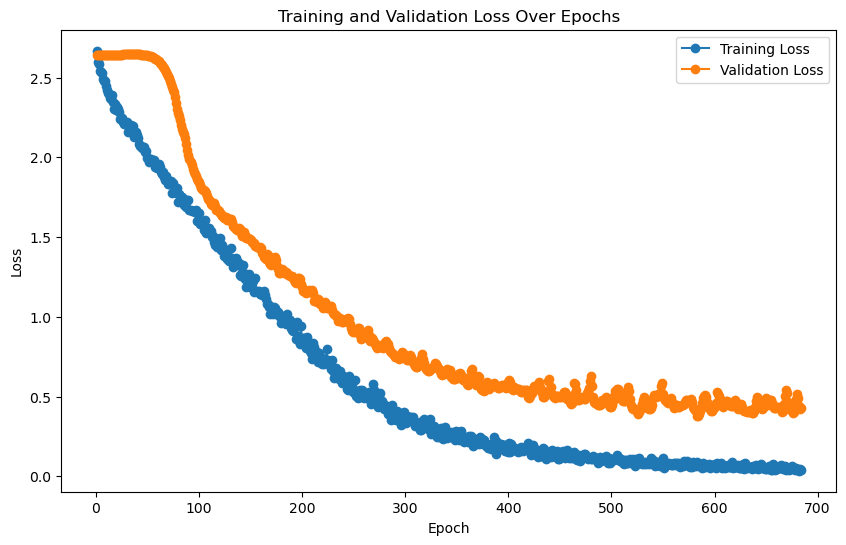

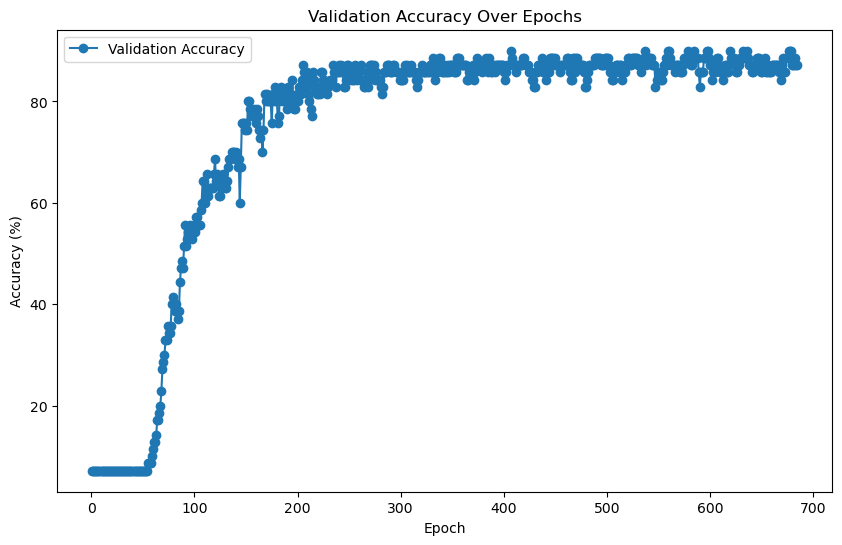


Evaluating on the test set...
    Test Batch [1/13], Loss: 0.1181

Final Test Loss: 0.4579, Test Accuracy: 88.00%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/13 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3108 samples with 64 features each
LOG: Labels shape: (3108,)

LOG: Training features shape: (70, 64), Training labels shape: (70,)
LOG: Validation features shape: (70, 64), Validation labels shape: (70,)
LOG: Test features shape: (3108, 64), Test labels shape: (3108,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 64.29%

Validation Classification Report:
               precision    recall  f1-sco

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3108 samples with 64 features each
LOG: Labels shape: (3108,)
Train reps shape: (70, 64)
Train labels shape: (70,)
Val reps shape: (70, 64)
Val labels shape: (70,)
Test reps shape: (3108, 64)
Test labels shape: (3108,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7269  |  Val Loss: 2.6633
Validation loss improved from inf to 2.6633.
[Epoch 2/1000] Train Loss: 2.6613  |  Val Loss: 2.6480
Validation loss improved from 2.6633 to 2.6480.
[Epoch 3/1000] Train Loss: 2.6478  |  Val Loss: 2.6612
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 4/1000] Train Loss: 2.6597  |  Val Loss: 2.6508
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 5/1000] Train Loss: 2.6469  |  Val Loss: 2.6371
Validation loss improved from 2.6480 to 2.6371.
[Epoch 6/1000] Train Loss: 2.6343  |  Val Loss: 2.6320
Validation loss improved from 2.6371 to 2.6320.
[Epoch 7/1000] Train Loss: 2.6282  |  Val Loss: 2.6315
Validation loss improved from 2.6320 to 2.6315.
[Epoch 8/1000] Train Loss: 2.6285  |  Val Loss: 2.6303
Validation loss improved from 2.6315 to 2.6303.


[Epoch 9/1000] Train Loss: 2.6278  |  Val Loss: 2.6243
Validation loss improved from 2.6303 to 2.6243.
[Epoch 10/1000] Train Loss: 2.6193  |  Val Loss: 2.6157
Validation loss improved from 2.6243 to 2.6157.
[Epoch 11/1000] Train Loss: 2.6094  |  Val Loss: 2.6124
Validation loss improved from 2.6157 to 2.6124.
[Epoch 12/1000] Train Loss: 2.6057  |  Val Loss: 2.6115
Validation loss improved from 2.6124 to 2.6115.
[Epoch 13/1000] Train Loss: 2.6075  |  Val Loss: 2.6064
Validation loss improved from 2.6115 to 2.6064.
[Epoch 14/1000] Train Loss: 2.6027  |  Val Loss: 2.5932
Validation loss improved from 2.6064 to 2.5932.
[Epoch 15/1000] Train Loss: 2.5850  |  Val Loss: 2.5818
Validation loss improved from 2.5932 to 2.5818.
[Epoch 16/1000] Train Loss: 2.5732  |  Val Loss: 2.5768
Validation loss improved from 2.5818 to 2.5768.
[Epoch 17/1000] Train Loss: 2.5718  |  Val Loss: 2.5754
Validation loss improved from 2.5768 to 2.5754.
[Epoch 18/1000] Train Loss: 2.5682  |  Val Loss: 2.5756
!! Valida

[Epoch 37/1000] Train Loss: 2.4585  |  Val Loss: 2.4713
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 38/1000] Train Loss: 2.4563  |  Val Loss: 2.4631
Validation loss improved from 2.4713 to 2.4631.
[Epoch 39/1000] Train Loss: 2.4489  |  Val Loss: 2.4538
Validation loss improved from 2.4631 to 2.4538.
[Epoch 40/1000] Train Loss: 2.4416  |  Val Loss: 2.4436
Validation loss improved from 2.4538 to 2.4436.
[Epoch 41/1000] Train Loss: 2.4335  |  Val Loss: 2.4387
Validation loss improved from 2.4436 to 2.4387.
[Epoch 42/1000] Train Loss: 2.4292  |  Val Loss: 2.4364
Validation loss improved from 2.4387 to 2.4364.
[Epoch 43/1000] Train Loss: 2.4245  |  Val Loss: 2.4373
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 44/1000] Train Loss: 2.4227  |  Val Loss: 2.4300
Validation loss improved from 2.4364 to 2.4300.
[Epoch 45/1000] Train Loss: 2.4150  |  Val Loss: 2.4144
Validation loss improved from 2.4300 to 2.4144.
[Epoch 46/1000] Train Loss: 2.3990  |  Val Loss: 2.4008
Validation loss improved from 2.4144 to 2.4008.
[Epoch 47/1000] Train Loss: 2.3852  |  Val Loss: 2.3911
Validation loss improved from 2.4008 to 2.3911.
[Epoch 48/1000] Train Loss: 2.3757  |  Val Loss: 2.3806
Validation loss improved from 2.3911 to 2.3806.
[Epoch 49/1000] Train Loss: 2.3648  |  Val Loss: 2.3730
Validation loss improved from 2.3806 to 2.3730.
[Epoch 50/1000] Train Loss: 2.3559  |  Val Loss: 2.3687
Validation loss improved from 2.3730 to 2.3687.
[Epoch 51/1000] Train Loss: 2.3508  |  Val Loss: 2.3641
Validation loss improved from 2.3687 to 2.3641.


[Epoch 52/1000] Train Loss: 2.3449  |  Val Loss: 2.3509
Validation loss improved from 2.3641 to 2.3509.
[Epoch 53/1000] Train Loss: 2.3310  |  Val Loss: 2.3405
Validation loss improved from 2.3509 to 2.3405.
[Epoch 54/1000] Train Loss: 2.3196  |  Val Loss: 2.3332
Validation loss improved from 2.3405 to 2.3332.
[Epoch 55/1000] Train Loss: 2.3165  |  Val Loss: 2.3265
Validation loss improved from 2.3332 to 2.3265.
[Epoch 56/1000] Train Loss: 2.3080  |  Val Loss: 2.3233
Validation loss improved from 2.3265 to 2.3233.
[Epoch 57/1000] Train Loss: 2.2987  |  Val Loss: 2.3275
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 58/1000] Train Loss: 2.3009  |  Val Loss: 2.3044
Validation loss improved from 2.3233 to 2.3044.
[Epoch 59/1000] Train Loss: 2.2786  |  Val Loss: 2.2985
Validation loss improved from 2.3044 to 2.2985.
[Epoch 60/1000] Train Loss: 2.2817  |  Val Loss: 2.2980
Validation loss improved from 2.2985 to 2.2980.
[Epoch 61/1000] Train Loss: 2.2859  |  Val Loss: 2.2798
Va

[Epoch 76/1000] Train Loss: 2.1537  |  Val Loss: 2.1692
Validation loss improved from 2.1725 to 2.1692.


[Epoch 77/1000] Train Loss: 2.1346  |  Val Loss: 2.1525
Validation loss improved from 2.1692 to 2.1525.
[Epoch 78/1000] Train Loss: 2.1342  |  Val Loss: 2.1716
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 79/1000] Train Loss: 2.1533  |  Val Loss: 2.1266
Validation loss improved from 2.1525 to 2.1266.
[Epoch 80/1000] Train Loss: 2.0960  |  Val Loss: 2.1863
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 81/1000] Train Loss: 2.1544  |  Val Loss: 2.2178
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 82/1000] Train Loss: 2.1762  |  Val Loss: 2.1194
Validation loss improved from 2.1266 to 2.1194.
[Epoch 83/1000] Train Loss: 2.0838  |  Val Loss: 2.1165
Validation loss improved from 2.1194 to 2.1165.
[Epoch 84/1000] Train Loss: 2.0958  |  Val Loss: 2.1584
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 85/1000] Train Loss: 2.1451  |  Val Loss: 2.1054
Validation loss improved from 2.1165 to 2.1054.
[Epoch 86/1000] Train Loss: 2.0804  |  V

[Epoch 96/1000] Train Loss: 2.0126  |  Val Loss: 2.0457
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 97/1000] Train Loss: 2.0272  |  Val Loss: 1.9791
Validation loss improved from 1.9978 to 1.9791.
[Epoch 98/1000] Train Loss: 1.9491  |  Val Loss: 2.0267
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 99/1000] Train Loss: 1.9907  |  Val Loss: 2.0400
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 100/1000] Train Loss: 1.9918  |  Val Loss: 1.9667
Validation loss improved from 1.9791 to 1.9667.
[Epoch 101/1000] Train Loss: 1.9374  |  Val Loss: 1.9933
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 102/1000] Train Loss: 1.9845  |  Val Loss: 1.9827
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 103/1000] Train Loss: 1.9643  |  Val Loss: 1.9312
Validation loss improved from 1.9667 to 1.9312.
[Epoch 104/1000] Train Loss: 1.8969  |  Val Loss: 2.0074
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 105/1000] Train 

[Epoch 118/1000] Train Loss: 1.8165  |  Val Loss: 1.8455
Validation loss improved from 1.8492 to 1.8455.
[Epoch 119/1000] Train Loss: 1.8102  |  Val Loss: 1.8460
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 120/1000] Train Loss: 1.8113  |  Val Loss: 1.8428
Validation loss improved from 1.8455 to 1.8428.
[Epoch 121/1000] Train Loss: 1.7990  |  Val Loss: 1.8238
Validation loss improved from 1.8428 to 1.8238.
[Epoch 122/1000] Train Loss: 1.7802  |  Val Loss: 1.8185
Validation loss improved from 1.8238 to 1.8185.
[Epoch 123/1000] Train Loss: 1.7809  |  Val Loss: 1.8024
Validation loss improved from 1.8185 to 1.8024.
[Epoch 124/1000] Train Loss: 1.7546  |  Val Loss: 1.8209
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 125/1000] Train Loss: 1.7646  |  Val Loss: 1.8388
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 126/1000] Train Loss: 1.7784  |  Val Loss: 1.7818
Validation loss improved from 1.8024 to 1.7818.
[Epoch 127/1000] Train Loss: 1.7256  

[Epoch 135/1000] Train Loss: 1.6781  |  Val Loss: 1.7237
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 136/1000] Train Loss: 1.6786  |  Val Loss: 1.7292
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 137/1000] Train Loss: 1.6821  |  Val Loss: 1.7264
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 138/1000] Train Loss: 1.6957  |  Val Loss: 1.7490
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 139/1000] Train Loss: 1.7218  |  Val Loss: 1.7074
Validation loss improved from 1.7196 to 1.7074.
[Epoch 140/1000] Train Loss: 1.6669  |  Val Loss: 1.7735
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 141/1000] Train Loss: 1.7136  |  Val Loss: 1.7693
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 142/1000] Train Loss: 1.7082  |  Val Loss: 1.7098
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 143/1000] Train Loss: 1.6708  |  Val Loss: 1.7405
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 

[Epoch 160/1000] Train Loss: 1.5962  |  Val Loss: 1.6589
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 161/1000] Train Loss: 1.5990  |  Val Loss: 1.6283
Validation loss improved from 1.6434 to 1.6283.
[Epoch 162/1000] Train Loss: 1.5817  |  Val Loss: 1.6201
Validation loss improved from 1.6283 to 1.6201.
[Epoch 163/1000] Train Loss: 1.5735  |  Val Loss: 1.6103
Validation loss improved from 1.6201 to 1.6103.
[Epoch 164/1000] Train Loss: 1.5598  |  Val Loss: 1.5961
Validation loss improved from 1.6103 to 1.5961.
[Epoch 165/1000] Train Loss: 1.5504  |  Val Loss: 1.5923
Validation loss improved from 1.5961 to 1.5923.
[Epoch 166/1000] Train Loss: 1.5408  |  Val Loss: 1.6044
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 167/1000] Train Loss: 1.5476  |  Val Loss: 1.5777
Validation loss improved from 1.5923 to 1.5777.
[Epoch 168/1000] Train Loss: 1.5300  |  Val Loss: 1.5863
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 169/1000] Train Loss: 1.5413 

[Epoch 175/1000] Train Loss: 1.5491  |  Val Loss: 1.6807
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 176/1000] Train Loss: 1.5910  |  Val Loss: 1.5689
Validation loss improved from 1.5714 to 1.5689.
[Epoch 177/1000] Train Loss: 1.5116  |  Val Loss: 1.6030
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 178/1000] Train Loss: 1.5494  |  Val Loss: 1.5644
Validation loss improved from 1.5689 to 1.5644.
[Epoch 179/1000] Train Loss: 1.4970  |  Val Loss: 1.6781
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 180/1000] Train Loss: 1.5867  |  Val Loss: 1.6118
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 181/1000] Train Loss: 1.5255  |  Val Loss: 1.5518
Validation loss improved from 1.5644 to 1.5518.
[Epoch 182/1000] Train Loss: 1.4964  |  Val Loss: 1.5750
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 183/1000] Train Loss: 1.5269  |  Val Loss: 1.5368
Validation loss improved from 1.5518 to 1.5368.
[Epoch 184/1000] Train Lo

[Epoch 206/1000] Train Loss: 1.4807  |  Val Loss: 1.5386
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 207/1000] Train Loss: 1.4859  |  Val Loss: 1.5179
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 208/1000] Train Loss: 1.4585  |  Val Loss: 1.5003
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 209/1000] Train Loss: 1.4336  |  Val Loss: 1.5090
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 210/1000] Train Loss: 1.4535  |  Val Loss: 1.6087
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 211/1000] Train Loss: 1.5546  |  Val Loss: 1.5229
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 212/1000] Train Loss: 1.4660  |  Val Loss: 1.5728
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 213/1000] Train Loss: 1.4997  |  Val Loss: 1.5213
!! Validation loss did NOT improve !! Patience: 12/100


[Epoch 214/1000] Train Loss: 1.4432  |  Val Loss: 1.4783
Validation loss improved from 1.4819 to 1.4783.
[Epoch 215/1000] Train Loss: 1.4174  |  Val Loss: 1.4773
Validation loss improved from 1.4783 to 1.4773.
[Epoch 216/1000] Train Loss: 1.4135  |  Val Loss: 1.4661
Validation loss improved from 1.4773 to 1.4661.
[Epoch 217/1000] Train Loss: 1.3904  |  Val Loss: 1.5142
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 218/1000] Train Loss: 1.4322  |  Val Loss: 1.4908
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 219/1000] Train Loss: 1.4127  |  Val Loss: 1.5118
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 220/1000] Train Loss: 1.4547  |  Val Loss: 1.4797
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 221/1000] Train Loss: 1.4036  |  Val Loss: 1.5557
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 222/1000] Train Loss: 1.4660  |  Val Loss: 1.5793
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 223/1000] Tr

[Epoch 250/1000] Train Loss: 1.3403  |  Val Loss: 1.4393
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 251/1000] Train Loss: 1.3533  |  Val Loss: 1.4335
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 252/1000] Train Loss: 1.3463  |  Val Loss: 1.4142
Validation loss improved from 1.4215 to 1.4142.
[Epoch 253/1000] Train Loss: 1.3465  |  Val Loss: 1.4507
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 254/1000] Train Loss: 1.3975  |  Val Loss: 1.3942
Validation loss improved from 1.4142 to 1.3942.
[Epoch 255/1000] Train Loss: 1.3232  |  Val Loss: 1.4543
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 256/1000] Train Loss: 1.3534  |  Val Loss: 1.4100
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 257/1000] Train Loss: 1.3129  |  Val Loss: 1.4482
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 258/1000] Train Loss: 1.3722  |  Val Loss: 1.4451
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 259/10

[Epoch 291/1000] Train Loss: 1.3089  |  Val Loss: 1.3762
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 292/1000] Train Loss: 1.2908  |  Val Loss: 1.4021
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 293/1000] Train Loss: 1.2963  |  Val Loss: 1.3781
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 294/1000] Train Loss: 1.2879  |  Val Loss: 1.3829
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 295/1000] Train Loss: 1.2869  |  Val Loss: 1.4010
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 296/1000] Train Loss: 1.2850  |  Val Loss: 1.4135
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 297/1000] Train Loss: 1.2946  |  Val Loss: 1.4242
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 298/1000] Train Loss: 1.3092  |  Val Loss: 1.4281
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 299/1000] Train Loss: 1.3151  |  Val Loss: 1.4184
!! Validation loss did NOT improve !! Patience: 14/

[Epoch 332/1000] Train Loss: 1.2933  |  Val Loss: 1.4076
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 333/1000] Train Loss: 1.3066  |  Val Loss: 1.4057
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 334/1000] Train Loss: 1.2928  |  Val Loss: 1.4519
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 335/1000] Train Loss: 1.3170  |  Val Loss: 1.4617
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 336/1000] Train Loss: 1.3216  |  Val Loss: 1.3596
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 337/1000] Train Loss: 1.2437  |  Val Loss: 1.3990
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 338/1000] Train Loss: 1.3098  |  Val Loss: 1.3595
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 339/1000] Train Loss: 1.2646  |  Val Loss: 1.3642
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 340/1000] Train Loss: 1.2463  |  Val Loss: 1.3765
!! Validation loss did NOT improve !! Patience:

[Epoch 372/1000] Train Loss: 1.2609  |  Val Loss: 1.3828
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 373/1000] Train Loss: 1.2633  |  Val Loss: 1.3769
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 374/1000] Train Loss: 1.2535  |  Val Loss: 1.3414
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 375/1000] Train Loss: 1.2287  |  Val Loss: 1.3315
Validation loss improved from 1.3383 to 1.3315.
[Epoch 376/1000] Train Loss: 1.2139  |  Val Loss: 1.3381
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 377/1000] Train Loss: 1.2050  |  Val Loss: 1.3331
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 378/1000] Train Loss: 1.1906  |  Val Loss: 1.3446
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 379/1000] Train Loss: 1.2149  |  Val Loss: 1.3803
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 380/1000] Train Loss: 1.2319  |  Val Loss: 1.4692
!! Validation loss did NOT improve !! Patience: 5/100
[Epo

[Epoch 410/1000] Train Loss: 1.2754  |  Val Loss: 1.3728
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 411/1000] Train Loss: 1.2211  |  Val Loss: 1.3985
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 412/1000] Train Loss: 1.2470  |  Val Loss: 1.3361
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 413/1000] Train Loss: 1.1944  |  Val Loss: 1.3188
Validation loss improved from 1.3198 to 1.3188.
[Epoch 414/1000] Train Loss: 1.1993  |  Val Loss: 1.3135
Validation loss improved from 1.3188 to 1.3135.
[Epoch 415/1000] Train Loss: 1.1973  |  Val Loss: 1.3205
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 416/1000] Train Loss: 1.2009  |  Val Loss: 1.3301
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 417/1000] Train Loss: 1.2053  |  Val Loss: 1.3530
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 418/1000] Train Loss: 1.2135  |  Val Loss: 1.4060
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 419

[Epoch 450/1000] Train Loss: 1.1858  |  Val Loss: 1.3727
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 451/1000] Train Loss: 1.2607  |  Val Loss: 1.3149
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 452/1000] Train Loss: 1.1996  |  Val Loss: 1.3455
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 453/1000] Train Loss: 1.2030  |  Val Loss: 1.3323
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 454/1000] Train Loss: 1.1981  |  Val Loss: 1.3498
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 455/1000] Train Loss: 1.2164  |  Val Loss: 1.3628
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 456/1000] Train Loss: 1.2145  |  Val Loss: 1.3546
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 457/1000] Train Loss: 1.1997  |  Val Loss: 1.3238
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 458/1000] Train Loss: 1.1811  |  Val Loss: 1.3293
!! Validation loss did NOT improve !! Patience:

[Epoch 491/1000] Train Loss: 1.1535  |  Val Loss: 1.3305
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 492/1000] Train Loss: 1.1738  |  Val Loss: 1.2739
Validation loss improved from 1.2918 to 1.2739.
[Epoch 493/1000] Train Loss: 1.1393  |  Val Loss: 1.3143
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 494/1000] Train Loss: 1.1993  |  Val Loss: 1.2753
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 495/1000] Train Loss: 1.1501  |  Val Loss: 1.2837
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 496/1000] Train Loss: 1.1543  |  Val Loss: 1.3005
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 497/1000] Train Loss: 1.1685  |  Val Loss: 1.2765
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 498/1000] Train Loss: 1.1422  |  Val Loss: 1.3184
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 499/1000] Train Loss: 1.1728  |  Val Loss: 1.3471
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch

[Epoch 531/1000] Train Loss: 1.2996  |  Val Loss: 1.3614
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 532/1000] Train Loss: 1.2073  |  Val Loss: 1.3376
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 533/1000] Train Loss: 1.2274  |  Val Loss: 1.3743
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 534/1000] Train Loss: 1.2613  |  Val Loss: 1.2938
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 535/1000] Train Loss: 1.1482  |  Val Loss: 1.4513
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 536/1000] Train Loss: 1.2769  |  Val Loss: 1.3930
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 537/1000] Train Loss: 1.2110  |  Val Loss: 1.3196
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 538/1000] Train Loss: 1.1804  |  Val Loss: 1.4207
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 539/1000] Train Loss: 1.3002  |  Val Loss: 1.3255
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 573/1000] Train Loss: 1.6429  |  Val Loss: 1.6368
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 574/1000] Train Loss: 1.5512  |  Val Loss: 1.2700
Validation loss improved from 1.2723 to 1.2700.
[Epoch 575/1000] Train Loss: 1.1196  |  Val Loss: 1.5664
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 576/1000] Train Loss: 1.4195  |  Val Loss: 1.4857
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 577/1000] Train Loss: 1.3150  |  Val Loss: 1.2671
Validation loss improved from 1.2700 to 1.2671.
[Epoch 578/1000] Train Loss: 1.1529  |  Val Loss: 1.3348
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 579/1000] Train Loss: 1.2408  |  Val Loss: 1.2866
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 580/1000] Train Loss: 1.1524  |  Val Loss: 1.2947
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 581/1000] Train Loss: 1.1214  |  Val Loss: 1.3262
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 582/1

[Epoch 612/1000] Train Loss: 1.1251  |  Val Loss: 1.2911
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 613/1000] Train Loss: 1.1172  |  Val Loss: 1.3038
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 614/1000] Train Loss: 1.1568  |  Val Loss: 1.2686
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 615/1000] Train Loss: 1.1240  |  Val Loss: 1.2632
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 616/1000] Train Loss: 1.1022  |  Val Loss: 1.3160
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 617/1000] Train Loss: 1.1611  |  Val Loss: 1.3304
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 618/1000] Train Loss: 1.1774  |  Val Loss: 1.2799
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 619/1000] Train Loss: 1.1243  |  Val Loss: 1.2574
Validation loss improved from 1.2598 to 1.2574.
[Epoch 620/1000] Train Loss: 1.1153  |  Val Loss: 1.2720
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 654/1000] Train Loss: 1.1246  |  Val Loss: 1.3171
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 655/1000] Train Loss: 1.1422  |  Val Loss: 1.2627
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 656/1000] Train Loss: 1.1047  |  Val Loss: 1.2617
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 657/1000] Train Loss: 1.1185  |  Val Loss: 1.2452
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 658/1000] Train Loss: 1.0967  |  Val Loss: 1.2467
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 659/1000] Train Loss: 1.0812  |  Val Loss: 1.3142
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 660/1000] Train Loss: 1.1488  |  Val Loss: 1.2893
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 661/1000] Train Loss: 1.1265  |  Val Loss: 1.2536
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 662/1000] Train Loss: 1.1275  |  Val Loss: 1.2488
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 693/1000] Train Loss: 1.0926  |  Val Loss: 1.2454
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 694/1000] Train Loss: 1.0804  |  Val Loss: 1.2521
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 695/1000] Train Loss: 1.0723  |  Val Loss: 1.2918
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 696/1000] Train Loss: 1.0982  |  Val Loss: 1.2759
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 697/1000] Train Loss: 1.0678  |  Val Loss: 1.2842
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 698/1000] Train Loss: 1.1082  |  Val Loss: 1.4257
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 699/1000] Train Loss: 1.2969  |  Val Loss: 1.3230
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 700/1000] Train Loss: 1.1441  |  Val Loss: 1.3430
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 701/1000] Train Loss: 1.1148  |  Val Loss: 1.4407
!! Validation loss did NOT improve !! Patience:

[Epoch 736/1000] Train Loss: 1.0899  |  Val Loss: 1.3469
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 737/1000] Train Loss: 1.0960  |  Val Loss: 1.3520
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 738/1000] Train Loss: 1.1040  |  Val Loss: 1.3059
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 739/1000] Train Loss: 1.0685  |  Val Loss: 1.2779
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 740/1000] Train Loss: 1.0648  |  Val Loss: 1.2639
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 741/1000] Train Loss: 1.0668  |  Val Loss: 1.2525
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 742/1000] Train Loss: 1.0632  |  Val Loss: 1.2425
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 743/1000] Train Loss: 1.0616  |  Val Loss: 1.2483
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 744/1000] Train Loss: 1.0854  |  Val Loss: 1.2614
!! Validation loss did NOT improve !! Patience:

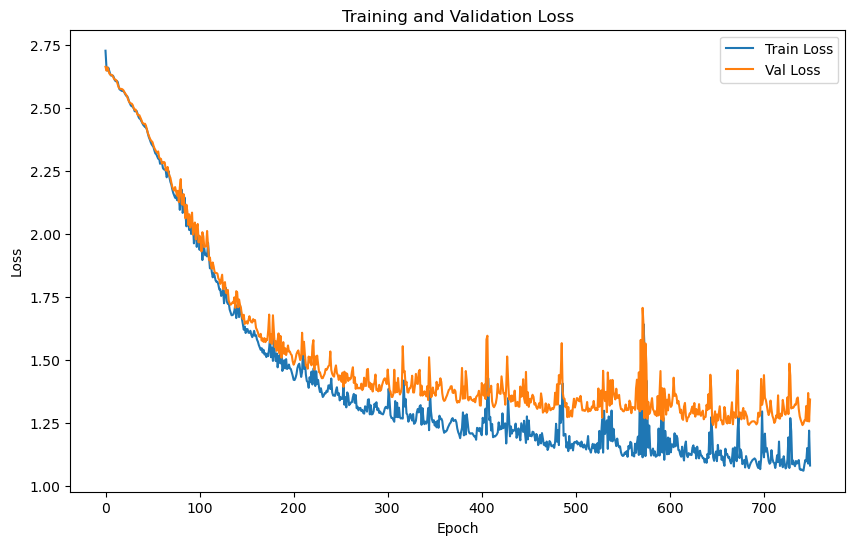

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.4239 | Test Accuracy: 42.54%


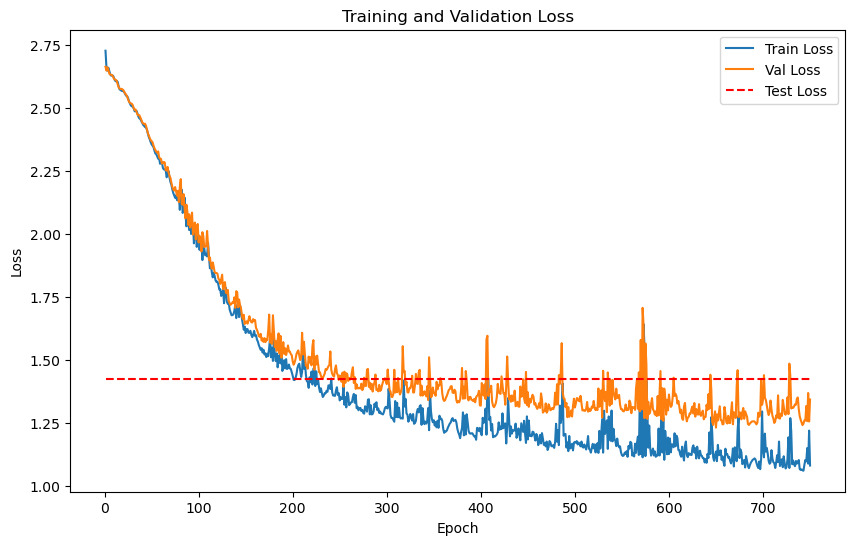

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3108 samples with 64 features each
LOG: Labels shape: (3108,)


Train embeddings shape: (70, 64), 
Train labels shape: (70,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (3108, 64), 
Test labels shape: (3108,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5}
Training batch size: 70


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 7.9140
Epoch [1/2000], Avg Train Loss: 7.9140
Epoch [1/2000], Avg Val Loss: 3.6610
Validation loss improved from inf to 3.6610. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 7.7609
Epoch [2/2000], Avg Train Loss: 7.7609
Epoch [2/2000], Avg Val Loss: 3.6460
Validation loss improved from 3.6610 to 3.6460. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.1440
Epoch [3/2000], Avg Train Loss: 8.1440
Epoch [3/2000], Avg Val Loss: 3.6314
Validation loss improved from 3.6460 to 3.6314. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 7.9558
Epoch [4/2000], Avg Train Loss: 7.9558
Epoch [4/2000], Avg Val Loss: 3.6173
Validation loss improved from 3.6314 to 3.6173. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 7.6425
Epoch [5/2000], Avg Train Loss: 7.6425
Epoch [5/2000], Avg Val Loss: 3.6039
Validation loss improved from 3.6173 to 3.6039. Saving mode

    Batch [1/1], Train Loss: 6.6683
Epoch [23/2000], Avg Train Loss: 6.6683
Epoch [23/2000], Avg Val Loss: 3.4413
Validation loss improved from 3.4472 to 3.4413. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 6.7233
Epoch [24/2000], Avg Train Loss: 6.7233
Epoch [24/2000], Avg Val Loss: 3.4356
Validation loss improved from 3.4413 to 3.4356. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 6.6146
Epoch [25/2000], Avg Train Loss: 6.6146
Epoch [25/2000], Avg Val Loss: 3.4302
Validation loss improved from 3.4356 to 3.4302. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 6.5546
Epoch [26/2000], Avg Train Loss: 6.5546
Epoch [26/2000], Avg Val Loss: 3.4250
Validation loss improved from 3.4302 to 3.4250. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 6.1972
Epoch [27/2000], Avg Train Loss: 6.1972
Epoch [27/2000], Avg Val Loss: 3.4201
Validation loss improved from 3.4250 to 3.

Epoch [33/2000], Avg Val Loss: 3.3958
Validation loss improved from 3.3993 to 3.3958. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 6.0460
Epoch [34/2000], Avg Train Loss: 6.0460
Epoch [34/2000], Avg Val Loss: 3.3925
Validation loss improved from 3.3958 to 3.3925. Saving model...

LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 5.9936
Epoch [35/2000], Avg Train Loss: 5.9936
Epoch [35/2000], Avg Val Loss: 3.3894
Validation loss improved from 3.3925 to 3.3894. Saving model...

LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 5.7890
Epoch [36/2000], Avg Train Loss: 5.7890
Epoch [36/2000], Avg Val Loss: 3.3865
Validation loss improved from 3.3894 to 3.3865. Saving model...

LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 6.0242
Epoch [37/2000], Avg Train Loss: 6.0242
Epoch [37/2000], Avg Val Loss: 3.3837
Validation loss improved from 3.3865 to 3.3837. Saving model...

LOG: Epoch [38/2000] - Training
    Batch [1/1], Trai

Epoch [52/2000], Avg Val Loss: 3.3567
Validation loss improved from 3.3577 to 3.3567. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 5.4425
Epoch [53/2000], Avg Train Loss: 5.4425
Epoch [53/2000], Avg Val Loss: 3.3556
Validation loss improved from 3.3567 to 3.3556. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 5.4176
Epoch [54/2000], Avg Train Loss: 5.4176
Epoch [54/2000], Avg Val Loss: 3.3546
Validation loss improved from 3.3556 to 3.3546. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 5.4134
Epoch [55/2000], Avg Train Loss: 5.4134
Epoch [55/2000], Avg Val Loss: 3.3537
Validation loss improved from 3.3546 to 3.3537. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 5.1665
Epoch [56/2000], Avg Train Loss: 5.1665
Epoch [56/2000], Avg Val Loss: 3.3528
Validation loss improved from 3.3537 to 3.3528. Saving model...

LOG: Epoch [57/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 4.7325
Epoch [72/2000], Avg Train Loss: 4.7325
Epoch [72/2000], Avg Val Loss: 3.3449
Validation loss improved from 3.3451 to 3.3449. Saving model...

LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 4.6980
Epoch [73/2000], Avg Train Loss: 4.6980
Epoch [73/2000], Avg Val Loss: 3.3447
Validation loss improved from 3.3449 to 3.3447. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 4.7713
Epoch [74/2000], Avg Train Loss: 4.7713
Epoch [74/2000], Avg Val Loss: 3.3446
Validation loss improved from 3.3447 to 3.3446. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 4.8281
Epoch [75/2000], Avg Train Loss: 4.8281
Epoch [75/2000], Avg Val Loss: 3.3445
Validation loss improved from 3.3446 to 3.3445. Saving model...

LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 4.6220
Epoch [76/2000], Avg Train Loss: 4.6220
Epoch [76/2000], Avg Val Loss: 3.3443
Validation loss improved from 3.3445 to 3.

    Batch [1/1], Train Loss: 4.6682
Epoch [81/2000], Avg Train Loss: 4.6682
Epoch [81/2000], Avg Val Loss: 3.3440
Validation loss improved from 3.3441 to 3.3440. Saving model...

LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 4.8377
Epoch [82/2000], Avg Train Loss: 4.8377
Epoch [82/2000], Avg Val Loss: 3.3439
Validation loss improved from 3.3440 to 3.3439. Saving model...

LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 4.7139
Epoch [83/2000], Avg Train Loss: 4.7139
Epoch [83/2000], Avg Val Loss: 3.3439
Validation loss improved from 3.3439 to 3.3439. Saving model...

LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 4.6557
Epoch [84/2000], Avg Train Loss: 4.6557
Epoch [84/2000], Avg Val Loss: 3.3438
Validation loss improved from 3.3439 to 3.3438. Saving model...

LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 4.5381
Epoch [85/2000], Avg Train Loss: 4.5381
Epoch [85/2000], Avg Val Loss: 3.3437
Validation loss improved from 3.3438 to 3.

    Batch [1/1], Train Loss: 4.5283
Epoch [97/2000], Avg Train Loss: 4.5283
Epoch [97/2000], Avg Val Loss: 3.3428
Validation loss improved from 3.3429 to 3.3428. Saving model...

LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 4.3038
Epoch [98/2000], Avg Train Loss: 4.3038
Epoch [98/2000], Avg Val Loss: 3.3427
Validation loss improved from 3.3428 to 3.3427. Saving model...

LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 4.3865
Epoch [99/2000], Avg Train Loss: 4.3865
Epoch [99/2000], Avg Val Loss: 3.3427
Validation loss did not improve. Patience: 1/100

LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 4.3343
Epoch [100/2000], Avg Train Loss: 4.3343
Epoch [100/2000], Avg Val Loss: 3.3428
Validation loss did not improve. Patience: 2/100

LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 4.3586
Epoch [101/2000], Avg Train Loss: 4.3586
Epoch [101/2000], Avg Val Loss: 3.3427
Validation loss improved from 3.3427 to 3.3427. Saving model...

L

    Batch [1/1], Train Loss: 4.1830
Epoch [112/2000], Avg Train Loss: 4.1830
Epoch [112/2000], Avg Val Loss: 3.3423
Validation loss improved from 3.3424 to 3.3423. Saving model...

LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 4.2188
Epoch [113/2000], Avg Train Loss: 4.2188
Epoch [113/2000], Avg Val Loss: 3.3423
Validation loss improved from 3.3423 to 3.3423. Saving model...

LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 4.3019
Epoch [114/2000], Avg Train Loss: 4.3019
Epoch [114/2000], Avg Val Loss: 3.3422
Validation loss improved from 3.3423 to 3.3422. Saving model...

LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 4.2883
Epoch [115/2000], Avg Train Loss: 4.2883
Epoch [115/2000], Avg Val Loss: 3.3422
Validation loss improved from 3.3422 to 3.3422. Saving model...

LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 4.1610
Epoch [116/2000], Avg Train Loss: 4.1610
Epoch [116/2000], Avg Val Loss: 3.3422
Validation loss improved fro

Epoch [124/2000], Avg Val Loss: 3.3417
Validation loss improved from 3.3418 to 3.3417. Saving model...

LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 4.0534
Epoch [125/2000], Avg Train Loss: 4.0534
Epoch [125/2000], Avg Val Loss: 3.3416
Validation loss improved from 3.3417 to 3.3416. Saving model...

LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 4.0761
Epoch [126/2000], Avg Train Loss: 4.0761
Epoch [126/2000], Avg Val Loss: 3.3416
Validation loss improved from 3.3416 to 3.3416. Saving model...

LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 4.2813
Epoch [127/2000], Avg Train Loss: 4.2813
Epoch [127/2000], Avg Val Loss: 3.3415
Validation loss improved from 3.3416 to 3.3415. Saving model...

LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 4.1004
Epoch [128/2000], Avg Train Loss: 4.1004
Epoch [128/2000], Avg Val Loss: 3.3414
Validation loss improved from 3.3415 to 3.3414. Saving model...

LOG: Epoch [129/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.9836
Epoch [138/2000], Avg Train Loss: 3.9836
Epoch [138/2000], Avg Val Loss: 3.3399
Validation loss improved from 3.3400 to 3.3399. Saving model...

LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 4.0444
Epoch [139/2000], Avg Train Loss: 4.0444
Epoch [139/2000], Avg Val Loss: 3.3397
Validation loss improved from 3.3399 to 3.3397. Saving model...

LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 3.9536
Epoch [140/2000], Avg Train Loss: 3.9536
Epoch [140/2000], Avg Val Loss: 3.3396
Validation loss improved from 3.3397 to 3.3396. Saving model...

LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 4.1098
Epoch [141/2000], Avg Train Loss: 4.1098
Epoch [141/2000], Avg Val Loss: 3.3394
Validation loss improved from 3.3396 to 3.3394. Saving model...

LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 4.0553
Epoch [142/2000], Avg Train Loss: 4.0553
Epoch [142/2000], Avg Val Loss: 3.3392
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9501
Epoch [158/2000], Avg Train Loss: 3.9501
Epoch [158/2000], Avg Val Loss: 3.3356
Validation loss improved from 3.3358 to 3.3356. Saving model...

LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 4.0577
Epoch [159/2000], Avg Train Loss: 4.0577
Epoch [159/2000], Avg Val Loss: 3.3353
Validation loss improved from 3.3356 to 3.3353. Saving model...

LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 3.9175
Epoch [160/2000], Avg Train Loss: 3.9175
Epoch [160/2000], Avg Val Loss: 3.3351
Validation loss improved from 3.3353 to 3.3351. Saving model...

LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 4.0717
Epoch [161/2000], Avg Train Loss: 4.0717
Epoch [161/2000], Avg Val Loss: 3.3349
Validation loss improved from 3.3351 to 3.3349. Saving model...

LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 3.9771
Epoch [162/2000], Avg Train Loss: 3.9771
Epoch [162/2000], Avg Val Loss: 3.3347
Validation loss improved fro

Epoch [169/2000], Avg Val Loss: 3.3332
Validation loss improved from 3.3334 to 3.3332. Saving model...

LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 3.9697
Epoch [170/2000], Avg Train Loss: 3.9697
Epoch [170/2000], Avg Val Loss: 3.3329
Validation loss improved from 3.3332 to 3.3329. Saving model...

LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 3.9029
Epoch [171/2000], Avg Train Loss: 3.9029
Epoch [171/2000], Avg Val Loss: 3.3327
Validation loss improved from 3.3329 to 3.3327. Saving model...

LOG: Epoch [172/2000] - Training
    Batch [1/1], Train Loss: 3.9026
Epoch [172/2000], Avg Train Loss: 3.9026
Epoch [172/2000], Avg Val Loss: 3.3325
Validation loss improved from 3.3327 to 3.3325. Saving model...

LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 3.9987
Epoch [173/2000], Avg Train Loss: 3.9987
Epoch [173/2000], Avg Val Loss: 3.3323
Validation loss improved from 3.3325 to 3.3323. Saving model...

LOG: Epoch [174/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.7800
Epoch [186/2000], Avg Train Loss: 3.7800
Epoch [186/2000], Avg Val Loss: 3.3291
Validation loss improved from 3.3294 to 3.3291. Saving model...

LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 3.8427
Epoch [187/2000], Avg Train Loss: 3.8427
Epoch [187/2000], Avg Val Loss: 3.3289
Validation loss improved from 3.3291 to 3.3289. Saving model...

LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 3.8721
Epoch [188/2000], Avg Train Loss: 3.8721
Epoch [188/2000], Avg Val Loss: 3.3287
Validation loss improved from 3.3289 to 3.3287. Saving model...

LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 3.7518
Epoch [189/2000], Avg Train Loss: 3.7518
Epoch [189/2000], Avg Val Loss: 3.3284
Validation loss improved from 3.3287 to 3.3284. Saving model...

LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 3.7605
Epoch [190/2000], Avg Train Loss: 3.7605
Epoch [190/2000], Avg Val Loss: 3.3281
Validation loss improved fro

Epoch [205/2000], Avg Val Loss: 3.3236
Validation loss improved from 3.3239 to 3.3236. Saving model...

LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 3.6897
Epoch [206/2000], Avg Train Loss: 3.6897
Epoch [206/2000], Avg Val Loss: 3.3233
Validation loss improved from 3.3236 to 3.3233. Saving model...

LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 3.7977
Epoch [207/2000], Avg Train Loss: 3.7977
Epoch [207/2000], Avg Val Loss: 3.3229
Validation loss improved from 3.3233 to 3.3229. Saving model...

LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 3.7138
Epoch [208/2000], Avg Train Loss: 3.7138
Epoch [208/2000], Avg Val Loss: 3.3226
Validation loss improved from 3.3229 to 3.3226. Saving model...

LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 3.8094
Epoch [209/2000], Avg Train Loss: 3.8094
Epoch [209/2000], Avg Val Loss: 3.3222
Validation loss improved from 3.3226 to 3.3222. Saving model...

LOG: Epoch [210/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.7086
Epoch [215/2000], Avg Train Loss: 3.7086
Epoch [215/2000], Avg Val Loss: 3.3200
Validation loss improved from 3.3204 to 3.3200. Saving model...

LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 3.6843
Epoch [216/2000], Avg Train Loss: 3.6843
Epoch [216/2000], Avg Val Loss: 3.3196
Validation loss improved from 3.3200 to 3.3196. Saving model...

LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 3.7207
Epoch [217/2000], Avg Train Loss: 3.7207
Epoch [217/2000], Avg Val Loss: 3.3192
Validation loss improved from 3.3196 to 3.3192. Saving model...

LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 3.7800
Epoch [218/2000], Avg Train Loss: 3.7800
Epoch [218/2000], Avg Val Loss: 3.3188
Validation loss improved from 3.3192 to 3.3188. Saving model...

LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 3.7563
Epoch [219/2000], Avg Train Loss: 3.7563
Epoch [219/2000], Avg Val Loss: 3.3184
Validation loss improved fro

Epoch [232/2000], Avg Val Loss: 3.3130
Validation loss improved from 3.3134 to 3.3130. Saving model...

LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 3.6767
Epoch [233/2000], Avg Train Loss: 3.6767
Epoch [233/2000], Avg Val Loss: 3.3125
Validation loss improved from 3.3130 to 3.3125. Saving model...

LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 3.6695
Epoch [234/2000], Avg Train Loss: 3.6695
Epoch [234/2000], Avg Val Loss: 3.3121
Validation loss improved from 3.3125 to 3.3121. Saving model...

LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 3.7902
Epoch [235/2000], Avg Train Loss: 3.7902
Epoch [235/2000], Avg Val Loss: 3.3117
Validation loss improved from 3.3121 to 3.3117. Saving model...

LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 3.7024
Epoch [236/2000], Avg Train Loss: 3.7024
Epoch [236/2000], Avg Val Loss: 3.3112
Validation loss improved from 3.3117 to 3.3112. Saving model...

LOG: Epoch [237/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.6549
Epoch [252/2000], Avg Train Loss: 3.6549
Epoch [252/2000], Avg Val Loss: 3.3030
Validation loss improved from 3.3036 to 3.3030. Saving model...

LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 3.6986
Epoch [253/2000], Avg Train Loss: 3.6986
Epoch [253/2000], Avg Val Loss: 3.3024
Validation loss improved from 3.3030 to 3.3024. Saving model...

LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 3.6609
Epoch [254/2000], Avg Train Loss: 3.6609
Epoch [254/2000], Avg Val Loss: 3.3018
Validation loss improved from 3.3024 to 3.3018. Saving model...

LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 3.6450
Epoch [255/2000], Avg Train Loss: 3.6450
Epoch [255/2000], Avg Val Loss: 3.3011
Validation loss improved from 3.3018 to 3.3011. Saving model...

LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 3.6341
Epoch [256/2000], Avg Train Loss: 3.6341
Epoch [256/2000], Avg Val Loss: 3.3006
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5776
Epoch [262/2000], Avg Train Loss: 3.5776
Epoch [262/2000], Avg Val Loss: 3.2969
Validation loss improved from 3.2975 to 3.2969. Saving model...

LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 3.5176
Epoch [263/2000], Avg Train Loss: 3.5176
Epoch [263/2000], Avg Val Loss: 3.2963
Validation loss improved from 3.2969 to 3.2963. Saving model...

LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 3.6851
Epoch [264/2000], Avg Train Loss: 3.6851
Epoch [264/2000], Avg Val Loss: 3.2957
Validation loss improved from 3.2963 to 3.2957. Saving model...

LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 3.5648
Epoch [265/2000], Avg Train Loss: 3.5648
Epoch [265/2000], Avg Val Loss: 3.2951
Validation loss improved from 3.2957 to 3.2951. Saving model...

LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 3.6571
Epoch [266/2000], Avg Train Loss: 3.6571
Epoch [266/2000], Avg Val Loss: 3.2946
Validation loss improved fro

    Batch [1/1], Train Loss: 3.6392
Epoch [281/2000], Avg Train Loss: 3.6392
Epoch [281/2000], Avg Val Loss: 3.2861
Validation loss improved from 3.2866 to 3.2861. Saving model...

LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 3.6086
Epoch [282/2000], Avg Train Loss: 3.6086
Epoch [282/2000], Avg Val Loss: 3.2855
Validation loss improved from 3.2861 to 3.2855. Saving model...

LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 3.5559
Epoch [283/2000], Avg Train Loss: 3.5559
Epoch [283/2000], Avg Val Loss: 3.2849
Validation loss improved from 3.2855 to 3.2849. Saving model...

LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 3.7023
Epoch [284/2000], Avg Train Loss: 3.7023
Epoch [284/2000], Avg Val Loss: 3.2843
Validation loss improved from 3.2849 to 3.2843. Saving model...

LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 3.6521
Epoch [285/2000], Avg Train Loss: 3.6521
Epoch [285/2000], Avg Val Loss: 3.2837
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4814
Epoch [296/2000], Avg Train Loss: 3.4814
Epoch [296/2000], Avg Val Loss: 3.2773
Validation loss improved from 3.2779 to 3.2773. Saving model...

LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 3.6089
Epoch [297/2000], Avg Train Loss: 3.6089
Epoch [297/2000], Avg Val Loss: 3.2767
Validation loss improved from 3.2773 to 3.2767. Saving model...

LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 3.5452
Epoch [298/2000], Avg Train Loss: 3.5452
Epoch [298/2000], Avg Val Loss: 3.2761
Validation loss improved from 3.2767 to 3.2761. Saving model...

LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 3.6026
Epoch [299/2000], Avg Train Loss: 3.6026
Epoch [299/2000], Avg Val Loss: 3.2755
Validation loss improved from 3.2761 to 3.2755. Saving model...

LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 3.5534
Epoch [300/2000], Avg Train Loss: 3.5534
Epoch [300/2000], Avg Val Loss: 3.2749
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5947
Epoch [301/2000], Avg Train Loss: 3.5947
Epoch [301/2000], Avg Val Loss: 3.2743
Validation loss improved from 3.2749 to 3.2743. Saving model...

LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 3.5958
Epoch [302/2000], Avg Train Loss: 3.5958
Epoch [302/2000], Avg Val Loss: 3.2736
Validation loss improved from 3.2743 to 3.2736. Saving model...

LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 3.5700
Epoch [303/2000], Avg Train Loss: 3.5700
Epoch [303/2000], Avg Val Loss: 3.2730
Validation loss improved from 3.2736 to 3.2730. Saving model...

LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 3.5819
Epoch [304/2000], Avg Train Loss: 3.5819
Epoch [304/2000], Avg Val Loss: 3.2724
Validation loss improved from 3.2730 to 3.2724. Saving model...

LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 3.4918
Epoch [305/2000], Avg Train Loss: 3.4918
Epoch [305/2000], Avg Val Loss: 3.2717
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4717
Epoch [326/2000], Avg Train Loss: 3.4717
Epoch [326/2000], Avg Val Loss: 3.2581
Validation loss improved from 3.2588 to 3.2581. Saving model...

LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 3.5088
Epoch [327/2000], Avg Train Loss: 3.5088
Epoch [327/2000], Avg Val Loss: 3.2575
Validation loss improved from 3.2581 to 3.2575. Saving model...

LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 3.4526
Epoch [328/2000], Avg Train Loss: 3.4526
Epoch [328/2000], Avg Val Loss: 3.2569
Validation loss improved from 3.2575 to 3.2569. Saving model...

LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 3.5604
Epoch [329/2000], Avg Train Loss: 3.5604
Epoch [329/2000], Avg Val Loss: 3.2562
Validation loss improved from 3.2569 to 3.2562. Saving model...

LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 3.4760
Epoch [330/2000], Avg Train Loss: 3.4760
Epoch [330/2000], Avg Val Loss: 3.2556
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4705
Epoch [337/2000], Avg Train Loss: 3.4705
Epoch [337/2000], Avg Val Loss: 3.2510
Validation loss improved from 3.2517 to 3.2510. Saving model...

LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 3.5642
Epoch [338/2000], Avg Train Loss: 3.5642
Epoch [338/2000], Avg Val Loss: 3.2504
Validation loss improved from 3.2510 to 3.2504. Saving model...

LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 3.4113
Epoch [339/2000], Avg Train Loss: 3.4113
Epoch [339/2000], Avg Val Loss: 3.2497
Validation loss improved from 3.2504 to 3.2497. Saving model...

LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 3.4657
Epoch [340/2000], Avg Train Loss: 3.4657
Epoch [340/2000], Avg Val Loss: 3.2490
Validation loss improved from 3.2497 to 3.2490. Saving model...

LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 3.4887
Epoch [341/2000], Avg Train Loss: 3.4887
Epoch [341/2000], Avg Val Loss: 3.2483
Validation loss improved fro

Epoch [346/2000], Avg Val Loss: 3.2450
Validation loss improved from 3.2457 to 3.2450. Saving model...

LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 3.5113
Epoch [347/2000], Avg Train Loss: 3.5113
Epoch [347/2000], Avg Val Loss: 3.2443
Validation loss improved from 3.2450 to 3.2443. Saving model...

LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 3.4960
Epoch [348/2000], Avg Train Loss: 3.4960
Epoch [348/2000], Avg Val Loss: 3.2436
Validation loss improved from 3.2443 to 3.2436. Saving model...

LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 3.5180
Epoch [349/2000], Avg Train Loss: 3.5180
Epoch [349/2000], Avg Val Loss: 3.2429
Validation loss improved from 3.2436 to 3.2429. Saving model...

LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 3.5619
Epoch [350/2000], Avg Train Loss: 3.5619
Epoch [350/2000], Avg Val Loss: 3.2422
Validation loss improved from 3.2429 to 3.2422. Saving model...

LOG: Epoch [351/2000] - Training
    Bat

Epoch [372/2000], Avg Val Loss: 3.2263
Validation loss improved from 3.2271 to 3.2263. Saving model...

LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 3.3880
Epoch [373/2000], Avg Train Loss: 3.3880
Epoch [373/2000], Avg Val Loss: 3.2255
Validation loss improved from 3.2263 to 3.2255. Saving model...

LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 3.4201
Epoch [374/2000], Avg Train Loss: 3.4201
Epoch [374/2000], Avg Val Loss: 3.2247
Validation loss improved from 3.2255 to 3.2247. Saving model...

LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 3.4256
Epoch [375/2000], Avg Train Loss: 3.4256
Epoch [375/2000], Avg Val Loss: 3.2240
Validation loss improved from 3.2247 to 3.2240. Saving model...

LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 3.4099
Epoch [376/2000], Avg Train Loss: 3.4099
Epoch [376/2000], Avg Val Loss: 3.2232
Validation loss improved from 3.2240 to 3.2232. Saving model...

LOG: Epoch [377/2000] - Training
    Bat

Epoch [379/2000], Avg Val Loss: 3.2209
Validation loss improved from 3.2216 to 3.2209. Saving model...

LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 3.4644
Epoch [380/2000], Avg Train Loss: 3.4644
Epoch [380/2000], Avg Val Loss: 3.2201
Validation loss improved from 3.2209 to 3.2201. Saving model...

LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 3.4829
Epoch [381/2000], Avg Train Loss: 3.4829
Epoch [381/2000], Avg Val Loss: 3.2193
Validation loss improved from 3.2201 to 3.2193. Saving model...

LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 3.4302
Epoch [382/2000], Avg Train Loss: 3.4302
Epoch [382/2000], Avg Val Loss: 3.2186
Validation loss improved from 3.2193 to 3.2186. Saving model...

LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 3.3873
Epoch [383/2000], Avg Train Loss: 3.3873
Epoch [383/2000], Avg Val Loss: 3.2178
Validation loss improved from 3.2186 to 3.2178. Saving model...

LOG: Epoch [384/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.4269
Epoch [393/2000], Avg Train Loss: 3.4269
Epoch [393/2000], Avg Val Loss: 3.2102
Validation loss improved from 3.2110 to 3.2102. Saving model...

LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 3.4401
Epoch [394/2000], Avg Train Loss: 3.4401
Epoch [394/2000], Avg Val Loss: 3.2094
Validation loss improved from 3.2102 to 3.2094. Saving model...

LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 3.3833
Epoch [395/2000], Avg Train Loss: 3.3833
Epoch [395/2000], Avg Val Loss: 3.2086
Validation loss improved from 3.2094 to 3.2086. Saving model...

LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 3.3898
Epoch [396/2000], Avg Train Loss: 3.3898
Epoch [396/2000], Avg Val Loss: 3.2078
Validation loss improved from 3.2086 to 3.2078. Saving model...

LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 3.3906
Epoch [397/2000], Avg Train Loss: 3.3906
Epoch [397/2000], Avg Val Loss: 3.2070
Validation loss improved fro

Epoch [418/2000], Avg Val Loss: 3.1909
Validation loss improved from 3.1917 to 3.1909. Saving model...

LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 3.3860
Epoch [419/2000], Avg Train Loss: 3.3860
Epoch [419/2000], Avg Val Loss: 3.1901
Validation loss improved from 3.1909 to 3.1901. Saving model...

LOG: Epoch [420/2000] - Training
    Batch [1/1], Train Loss: 3.3811
Epoch [420/2000], Avg Train Loss: 3.3811
Epoch [420/2000], Avg Val Loss: 3.1892
Validation loss improved from 3.1901 to 3.1892. Saving model...

LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 3.3964
Epoch [421/2000], Avg Train Loss: 3.3964
Epoch [421/2000], Avg Val Loss: 3.1884
Validation loss improved from 3.1892 to 3.1884. Saving model...

LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 3.3781
Epoch [422/2000], Avg Train Loss: 3.3781
Epoch [422/2000], Avg Val Loss: 3.1876
Validation loss improved from 3.1884 to 3.1876. Saving model...

LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 3.3984
Epoch [423/2000], Avg Train Loss: 3.3984
Epoch [423/2000], Avg Val Loss: 3.1868
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3982
Epoch [439/2000], Avg Train Loss: 3.3982
Epoch [439/2000], Avg Val Loss: 3.1737
Validation loss improved from 3.1745 to 3.1737. Saving model...

LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 3.3808
Epoch [440/2000], Avg Train Loss: 3.3808
Epoch [440/2000], Avg Val Loss: 3.1729
Validation loss improved from 3.1737 to 3.1729. Saving model...

LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 3.2819
Epoch [441/2000], Avg Train Loss: 3.2819
Epoch [441/2000], Avg Val Loss: 3.1721
Validation loss improved from 3.1729 to 3.1721. Saving model...

LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 3.3433
Epoch [442/2000], Avg Train Loss: 3.3433
Epoch [442/2000], Avg Val Loss: 3.1713
Validation loss improved from 3.1721 to 3.1713. Saving model...

LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 3.3263
Epoch [443/2000], Avg Train Loss: 3.3263
Epoch [443/2000], Avg Val Loss: 3.1705
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3407
Epoch [463/2000], Avg Train Loss: 3.3407
Epoch [463/2000], Avg Val Loss: 3.1555
Validation loss improved from 3.1562 to 3.1555. Saving model...

LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 3.3246
Epoch [464/2000], Avg Train Loss: 3.3246
Epoch [464/2000], Avg Val Loss: 3.1548
Validation loss improved from 3.1555 to 3.1548. Saving model...

LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 3.2963
Epoch [465/2000], Avg Train Loss: 3.2963
Epoch [465/2000], Avg Val Loss: 3.1540
Validation loss improved from 3.1548 to 3.1540. Saving model...

LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 3.3975
Epoch [466/2000], Avg Train Loss: 3.3975
Epoch [466/2000], Avg Val Loss: 3.1533
Validation loss improved from 3.1540 to 3.1533. Saving model...

LOG: Epoch [467/2000] - Training
    Batch [1/1], Train Loss: 3.3106
Epoch [467/2000], Avg Train Loss: 3.3106
Epoch [467/2000], Avg Val Loss: 3.1525
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3131
Epoch [484/2000], Avg Train Loss: 3.3131
Epoch [484/2000], Avg Val Loss: 3.1401
Validation loss improved from 3.1408 to 3.1401. Saving model...

LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 3.3550
Epoch [485/2000], Avg Train Loss: 3.3550
Epoch [485/2000], Avg Val Loss: 3.1393
Validation loss improved from 3.1401 to 3.1393. Saving model...

LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 3.1704
Epoch [486/2000], Avg Train Loss: 3.1704
Epoch [486/2000], Avg Val Loss: 3.1385
Validation loss improved from 3.1393 to 3.1385. Saving model...

LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 3.2458
Epoch [487/2000], Avg Train Loss: 3.2458
Epoch [487/2000], Avg Val Loss: 3.1377
Validation loss improved from 3.1385 to 3.1377. Saving model...

LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 3.2665
Epoch [488/2000], Avg Train Loss: 3.2665
Epoch [488/2000], Avg Val Loss: 3.1369
Validation loss improved fro

Epoch [512/2000], Avg Val Loss: 3.1192
Validation loss improved from 3.1199 to 3.1192. Saving model...

LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 3.2156
Epoch [513/2000], Avg Train Loss: 3.2156
Epoch [513/2000], Avg Val Loss: 3.1184
Validation loss improved from 3.1192 to 3.1184. Saving model...

LOG: Epoch [514/2000] - Training
    Batch [1/1], Train Loss: 3.3612
Epoch [514/2000], Avg Train Loss: 3.3612
Epoch [514/2000], Avg Val Loss: 3.1177
Validation loss improved from 3.1184 to 3.1177. Saving model...

LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 3.2488
Epoch [515/2000], Avg Train Loss: 3.2488
Epoch [515/2000], Avg Val Loss: 3.1170
Validation loss improved from 3.1177 to 3.1170. Saving model...

LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 3.2348
Epoch [516/2000], Avg Train Loss: 3.2348
Epoch [516/2000], Avg Val Loss: 3.1163
Validation loss improved from 3.1170 to 3.1163. Saving model...

LOG: Epoch [517/2000] - Training
    Bat

Epoch [528/2000], Avg Val Loss: 3.1080
Validation loss improved from 3.1086 to 3.1080. Saving model...

LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 3.1984
Epoch [529/2000], Avg Train Loss: 3.1984
Epoch [529/2000], Avg Val Loss: 3.1073
Validation loss improved from 3.1080 to 3.1073. Saving model...

LOG: Epoch [530/2000] - Training
    Batch [1/1], Train Loss: 3.2919
Epoch [530/2000], Avg Train Loss: 3.2919
Epoch [530/2000], Avg Val Loss: 3.1066
Validation loss improved from 3.1073 to 3.1066. Saving model...

LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 3.2056
Epoch [531/2000], Avg Train Loss: 3.2056
Epoch [531/2000], Avg Val Loss: 3.1059
Validation loss improved from 3.1066 to 3.1059. Saving model...

LOG: Epoch [532/2000] - Training
    Batch [1/1], Train Loss: 3.2634
Epoch [532/2000], Avg Train Loss: 3.2634
Epoch [532/2000], Avg Val Loss: 3.1052
Validation loss improved from 3.1059 to 3.1052. Saving model...

LOG: Epoch [533/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.2094
Epoch [559/2000], Avg Train Loss: 3.2094
Epoch [559/2000], Avg Val Loss: 3.0843
Validation loss improved from 3.0851 to 3.0843. Saving model...

LOG: Epoch [560/2000] - Training
    Batch [1/1], Train Loss: 3.1583
Epoch [560/2000], Avg Train Loss: 3.1583
Epoch [560/2000], Avg Val Loss: 3.0835
Validation loss improved from 3.0843 to 3.0835. Saving model...

LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 3.2180
Epoch [561/2000], Avg Train Loss: 3.2180
Epoch [561/2000], Avg Val Loss: 3.0827
Validation loss improved from 3.0835 to 3.0827. Saving model...

LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 3.1514
Epoch [562/2000], Avg Train Loss: 3.1514
Epoch [562/2000], Avg Val Loss: 3.0819
Validation loss improved from 3.0827 to 3.0819. Saving model...

LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 3.1980
Epoch [563/2000], Avg Train Loss: 3.1980
Epoch [563/2000], Avg Val Loss: 3.0812
Validation loss improved fro

Epoch [571/2000], Avg Val Loss: 3.0751
Validation loss improved from 3.0759 to 3.0751. Saving model...

LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 3.1787
Epoch [572/2000], Avg Train Loss: 3.1787
Epoch [572/2000], Avg Val Loss: 3.0744
Validation loss improved from 3.0751 to 3.0744. Saving model...

LOG: Epoch [573/2000] - Training
    Batch [1/1], Train Loss: 3.1282
Epoch [573/2000], Avg Train Loss: 3.1282
Epoch [573/2000], Avg Val Loss: 3.0736
Validation loss improved from 3.0744 to 3.0736. Saving model...

LOG: Epoch [574/2000] - Training
    Batch [1/1], Train Loss: 3.1713
Epoch [574/2000], Avg Train Loss: 3.1713
Epoch [574/2000], Avg Val Loss: 3.0729
Validation loss improved from 3.0736 to 3.0729. Saving model...

LOG: Epoch [575/2000] - Training
    Batch [1/1], Train Loss: 3.1835
Epoch [575/2000], Avg Train Loss: 3.1835
Epoch [575/2000], Avg Val Loss: 3.0721
Validation loss improved from 3.0729 to 3.0721. Saving model...

LOG: Epoch [576/2000] - Training
    Bat

Epoch [604/2000], Avg Val Loss: 3.0501
Validation loss improved from 3.0509 to 3.0501. Saving model...

LOG: Epoch [605/2000] - Training
    Batch [1/1], Train Loss: 3.1768
Epoch [605/2000], Avg Train Loss: 3.1768
Epoch [605/2000], Avg Val Loss: 3.0494
Validation loss improved from 3.0501 to 3.0494. Saving model...

LOG: Epoch [606/2000] - Training
    Batch [1/1], Train Loss: 3.0855
Epoch [606/2000], Avg Train Loss: 3.0855
Epoch [606/2000], Avg Val Loss: 3.0487
Validation loss improved from 3.0494 to 3.0487. Saving model...

LOG: Epoch [607/2000] - Training
    Batch [1/1], Train Loss: 3.1609
Epoch [607/2000], Avg Train Loss: 3.1609
Epoch [607/2000], Avg Val Loss: 3.0480
Validation loss improved from 3.0487 to 3.0480. Saving model...

LOG: Epoch [608/2000] - Training
    Batch [1/1], Train Loss: 3.1024
Epoch [608/2000], Avg Train Loss: 3.1024
Epoch [608/2000], Avg Val Loss: 3.0473
Validation loss improved from 3.0480 to 3.0473. Saving model...

LOG: Epoch [609/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.1373
Epoch [621/2000], Avg Train Loss: 3.1373
Epoch [621/2000], Avg Val Loss: 3.0386
Validation loss improved from 3.0393 to 3.0386. Saving model...

LOG: Epoch [622/2000] - Training
    Batch [1/1], Train Loss: 3.0992
Epoch [622/2000], Avg Train Loss: 3.0992
Epoch [622/2000], Avg Val Loss: 3.0379
Validation loss improved from 3.0386 to 3.0379. Saving model...

LOG: Epoch [623/2000] - Training
    Batch [1/1], Train Loss: 3.1577
Epoch [623/2000], Avg Train Loss: 3.1577
Epoch [623/2000], Avg Val Loss: 3.0372
Validation loss improved from 3.0379 to 3.0372. Saving model...

LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 3.1349
Epoch [624/2000], Avg Train Loss: 3.1349
Epoch [624/2000], Avg Val Loss: 3.0364
Validation loss improved from 3.0372 to 3.0364. Saving model...

LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 3.1067
Epoch [625/2000], Avg Train Loss: 3.1067
Epoch [625/2000], Avg Val Loss: 3.0357
Validation loss improved fro

Epoch [650/2000], Avg Val Loss: 3.0177
Validation loss improved from 3.0185 to 3.0177. Saving model...

LOG: Epoch [651/2000] - Training
    Batch [1/1], Train Loss: 3.0327
Epoch [651/2000], Avg Train Loss: 3.0327
Epoch [651/2000], Avg Val Loss: 3.0170
Validation loss improved from 3.0177 to 3.0170. Saving model...

LOG: Epoch [652/2000] - Training
    Batch [1/1], Train Loss: 3.0025
Epoch [652/2000], Avg Train Loss: 3.0025
Epoch [652/2000], Avg Val Loss: 3.0162
Validation loss improved from 3.0170 to 3.0162. Saving model...

LOG: Epoch [653/2000] - Training
    Batch [1/1], Train Loss: 3.0733
Epoch [653/2000], Avg Train Loss: 3.0733
Epoch [653/2000], Avg Val Loss: 3.0155
Validation loss improved from 3.0162 to 3.0155. Saving model...

LOG: Epoch [654/2000] - Training
    Batch [1/1], Train Loss: 3.0049
Epoch [654/2000], Avg Train Loss: 3.0049
Epoch [654/2000], Avg Val Loss: 3.0148
Validation loss improved from 3.0155 to 3.0148. Saving model...

LOG: Epoch [655/2000] - Training
    Bat

Epoch [665/2000], Avg Val Loss: 3.0063
Validation loss improved from 3.0070 to 3.0063. Saving model...

LOG: Epoch [666/2000] - Training
    Batch [1/1], Train Loss: 3.0581
Epoch [666/2000], Avg Train Loss: 3.0581
Epoch [666/2000], Avg Val Loss: 3.0056
Validation loss improved from 3.0063 to 3.0056. Saving model...

LOG: Epoch [667/2000] - Training
    Batch [1/1], Train Loss: 3.0103
Epoch [667/2000], Avg Train Loss: 3.0103
Epoch [667/2000], Avg Val Loss: 3.0049
Validation loss improved from 3.0056 to 3.0049. Saving model...

LOG: Epoch [668/2000] - Training
    Batch [1/1], Train Loss: 3.0940
Epoch [668/2000], Avg Train Loss: 3.0940
Epoch [668/2000], Avg Val Loss: 3.0042
Validation loss improved from 3.0049 to 3.0042. Saving model...

LOG: Epoch [669/2000] - Training
    Batch [1/1], Train Loss: 2.9910
Epoch [669/2000], Avg Train Loss: 2.9910
Epoch [669/2000], Avg Val Loss: 3.0035
Validation loss improved from 3.0042 to 3.0035. Saving model...

LOG: Epoch [670/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.0378
Epoch [702/2000], Avg Train Loss: 3.0378
Epoch [702/2000], Avg Val Loss: 2.9817
Validation loss improved from 2.9824 to 2.9817. Saving model...

LOG: Epoch [703/2000] - Training
    Batch [1/1], Train Loss: 2.9891
Epoch [703/2000], Avg Train Loss: 2.9891
Epoch [703/2000], Avg Val Loss: 2.9810
Validation loss improved from 2.9817 to 2.9810. Saving model...

LOG: Epoch [704/2000] - Training
    Batch [1/1], Train Loss: 2.9279
Epoch [704/2000], Avg Train Loss: 2.9279
Epoch [704/2000], Avg Val Loss: 2.9803
Validation loss improved from 2.9810 to 2.9803. Saving model...

LOG: Epoch [705/2000] - Training
    Batch [1/1], Train Loss: 2.9782
Epoch [705/2000], Avg Train Loss: 2.9782
Epoch [705/2000], Avg Val Loss: 2.9796
Validation loss improved from 2.9803 to 2.9796. Saving model...

LOG: Epoch [706/2000] - Training
    Batch [1/1], Train Loss: 3.0186
Epoch [706/2000], Avg Train Loss: 3.0186
Epoch [706/2000], Avg Val Loss: 2.9790
Validation loss improved fro

    Batch [1/1], Train Loss: 2.9860
Epoch [711/2000], Avg Train Loss: 2.9860
Epoch [711/2000], Avg Val Loss: 2.9757
Validation loss improved from 2.9764 to 2.9757. Saving model...

LOG: Epoch [712/2000] - Training
    Batch [1/1], Train Loss: 2.9514
Epoch [712/2000], Avg Train Loss: 2.9514
Epoch [712/2000], Avg Val Loss: 2.9751
Validation loss improved from 2.9757 to 2.9751. Saving model...

LOG: Epoch [713/2000] - Training
    Batch [1/1], Train Loss: 2.9509
Epoch [713/2000], Avg Train Loss: 2.9509
Epoch [713/2000], Avg Val Loss: 2.9744
Validation loss improved from 2.9751 to 2.9744. Saving model...

LOG: Epoch [714/2000] - Training
    Batch [1/1], Train Loss: 2.9812
Epoch [714/2000], Avg Train Loss: 2.9812
Epoch [714/2000], Avg Val Loss: 2.9738
Validation loss improved from 2.9744 to 2.9738. Saving model...

LOG: Epoch [715/2000] - Training
    Batch [1/1], Train Loss: 3.0074
Epoch [715/2000], Avg Train Loss: 3.0074
Epoch [715/2000], Avg Val Loss: 2.9731
Validation loss improved fro

    Batch [1/1], Train Loss: 2.9264
Epoch [745/2000], Avg Train Loss: 2.9264
Epoch [745/2000], Avg Val Loss: 2.9530
Validation loss improved from 2.9537 to 2.9530. Saving model...

LOG: Epoch [746/2000] - Training
    Batch [1/1], Train Loss: 2.9648
Epoch [746/2000], Avg Train Loss: 2.9648
Epoch [746/2000], Avg Val Loss: 2.9523
Validation loss improved from 2.9530 to 2.9523. Saving model...

LOG: Epoch [747/2000] - Training
    Batch [1/1], Train Loss: 3.0126
Epoch [747/2000], Avg Train Loss: 3.0126
Epoch [747/2000], Avg Val Loss: 2.9516
Validation loss improved from 2.9523 to 2.9516. Saving model...

LOG: Epoch [748/2000] - Training
    Batch [1/1], Train Loss: 2.9611
Epoch [748/2000], Avg Train Loss: 2.9611
Epoch [748/2000], Avg Val Loss: 2.9509
Validation loss improved from 2.9516 to 2.9509. Saving model...

LOG: Epoch [749/2000] - Training
    Batch [1/1], Train Loss: 3.0103
Epoch [749/2000], Avg Train Loss: 3.0103
Epoch [749/2000], Avg Val Loss: 2.9502
Validation loss improved fro

    Batch [1/1], Train Loss: 2.9127
Epoch [758/2000], Avg Train Loss: 2.9127
Epoch [758/2000], Avg Val Loss: 2.9445
Validation loss improved from 2.9451 to 2.9445. Saving model...

LOG: Epoch [759/2000] - Training
    Batch [1/1], Train Loss: 2.9735
Epoch [759/2000], Avg Train Loss: 2.9735
Epoch [759/2000], Avg Val Loss: 2.9439
Validation loss improved from 2.9445 to 2.9439. Saving model...

LOG: Epoch [760/2000] - Training
    Batch [1/1], Train Loss: 2.8989
Epoch [760/2000], Avg Train Loss: 2.8989
Epoch [760/2000], Avg Val Loss: 2.9432
Validation loss improved from 2.9439 to 2.9432. Saving model...

LOG: Epoch [761/2000] - Training
    Batch [1/1], Train Loss: 2.9405
Epoch [761/2000], Avg Train Loss: 2.9405
Epoch [761/2000], Avg Val Loss: 2.9426
Validation loss improved from 2.9432 to 2.9426. Saving model...

LOG: Epoch [762/2000] - Training
    Batch [1/1], Train Loss: 3.0128
Epoch [762/2000], Avg Train Loss: 3.0128
Epoch [762/2000], Avg Val Loss: 2.9421
Validation loss improved fro

    Batch [1/1], Train Loss: 2.9473
Epoch [791/2000], Avg Train Loss: 2.9473
Epoch [791/2000], Avg Val Loss: 2.9248
Validation loss improved from 2.9252 to 2.9248. Saving model...

LOG: Epoch [792/2000] - Training
    Batch [1/1], Train Loss: 2.8501
Epoch [792/2000], Avg Train Loss: 2.8501
Epoch [792/2000], Avg Val Loss: 2.9243
Validation loss improved from 2.9248 to 2.9243. Saving model...

LOG: Epoch [793/2000] - Training
    Batch [1/1], Train Loss: 2.9285
Epoch [793/2000], Avg Train Loss: 2.9285
Epoch [793/2000], Avg Val Loss: 2.9238
Validation loss improved from 2.9243 to 2.9238. Saving model...

LOG: Epoch [794/2000] - Training
    Batch [1/1], Train Loss: 2.9052
Epoch [794/2000], Avg Train Loss: 2.9052
Epoch [794/2000], Avg Val Loss: 2.9233
Validation loss improved from 2.9238 to 2.9233. Saving model...

LOG: Epoch [795/2000] - Training
    Batch [1/1], Train Loss: 2.9538
Epoch [795/2000], Avg Train Loss: 2.9538
Epoch [795/2000], Avg Val Loss: 2.9227
Validation loss improved fro

    Batch [1/1], Train Loss: 2.9248
Epoch [804/2000], Avg Train Loss: 2.9248
Epoch [804/2000], Avg Val Loss: 2.9180
Validation loss improved from 2.9185 to 2.9180. Saving model...

LOG: Epoch [805/2000] - Training
    Batch [1/1], Train Loss: 2.8949
Epoch [805/2000], Avg Train Loss: 2.8949
Epoch [805/2000], Avg Val Loss: 2.9174
Validation loss improved from 2.9180 to 2.9174. Saving model...

LOG: Epoch [806/2000] - Training
    Batch [1/1], Train Loss: 2.8978
Epoch [806/2000], Avg Train Loss: 2.8978
Epoch [806/2000], Avg Val Loss: 2.9169
Validation loss improved from 2.9174 to 2.9169. Saving model...

LOG: Epoch [807/2000] - Training
    Batch [1/1], Train Loss: 2.9085
Epoch [807/2000], Avg Train Loss: 2.9085
Epoch [807/2000], Avg Val Loss: 2.9162
Validation loss improved from 2.9169 to 2.9162. Saving model...

LOG: Epoch [808/2000] - Training
    Batch [1/1], Train Loss: 2.9339
Epoch [808/2000], Avg Train Loss: 2.9339
Epoch [808/2000], Avg Val Loss: 2.9156
Validation loss improved fro

Epoch [838/2000], Avg Val Loss: 2.8979
Validation loss improved from 2.8984 to 2.8979. Saving model...

LOG: Epoch [839/2000] - Training
    Batch [1/1], Train Loss: 2.8119
Epoch [839/2000], Avg Train Loss: 2.8119
Epoch [839/2000], Avg Val Loss: 2.8974
Validation loss improved from 2.8979 to 2.8974. Saving model...

LOG: Epoch [840/2000] - Training
    Batch [1/1], Train Loss: 2.8975
Epoch [840/2000], Avg Train Loss: 2.8975
Epoch [840/2000], Avg Val Loss: 2.8969
Validation loss improved from 2.8974 to 2.8969. Saving model...

LOG: Epoch [841/2000] - Training
    Batch [1/1], Train Loss: 2.8113
Epoch [841/2000], Avg Train Loss: 2.8113
Epoch [841/2000], Avg Val Loss: 2.8964
Validation loss improved from 2.8969 to 2.8964. Saving model...

LOG: Epoch [842/2000] - Training
    Batch [1/1], Train Loss: 2.8588
Epoch [842/2000], Avg Train Loss: 2.8588
Epoch [842/2000], Avg Val Loss: 2.8960
Validation loss improved from 2.8964 to 2.8960. Saving model...

LOG: Epoch [843/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.9280
Epoch [850/2000], Avg Train Loss: 2.9280
Epoch [850/2000], Avg Val Loss: 2.8921
Validation loss improved from 2.8925 to 2.8921. Saving model...

LOG: Epoch [851/2000] - Training
    Batch [1/1], Train Loss: 2.8705
Epoch [851/2000], Avg Train Loss: 2.8705
Epoch [851/2000], Avg Val Loss: 2.8916
Validation loss improved from 2.8921 to 2.8916. Saving model...

LOG: Epoch [852/2000] - Training
    Batch [1/1], Train Loss: 2.7840
Epoch [852/2000], Avg Train Loss: 2.7840
Epoch [852/2000], Avg Val Loss: 2.8911
Validation loss improved from 2.8916 to 2.8911. Saving model...

LOG: Epoch [853/2000] - Training
    Batch [1/1], Train Loss: 2.8466
Epoch [853/2000], Avg Train Loss: 2.8466
Epoch [853/2000], Avg Val Loss: 2.8906
Validation loss improved from 2.8911 to 2.8906. Saving model...

LOG: Epoch [854/2000] - Training
    Batch [1/1], Train Loss: 2.7743
Epoch [854/2000], Avg Train Loss: 2.7743
Epoch [854/2000], Avg Val Loss: 2.8901
Validation loss improved fro

Epoch [883/2000], Avg Val Loss: 2.8756
Validation loss improved from 2.8760 to 2.8756. Saving model...

LOG: Epoch [884/2000] - Training
    Batch [1/1], Train Loss: 2.8226
Epoch [884/2000], Avg Train Loss: 2.8226
Epoch [884/2000], Avg Val Loss: 2.8751
Validation loss improved from 2.8756 to 2.8751. Saving model...

LOG: Epoch [885/2000] - Training
    Batch [1/1], Train Loss: 2.8262
Epoch [885/2000], Avg Train Loss: 2.8262
Epoch [885/2000], Avg Val Loss: 2.8747
Validation loss improved from 2.8751 to 2.8747. Saving model...

LOG: Epoch [886/2000] - Training
    Batch [1/1], Train Loss: 2.7768
Epoch [886/2000], Avg Train Loss: 2.7768
Epoch [886/2000], Avg Val Loss: 2.8742
Validation loss improved from 2.8747 to 2.8742. Saving model...

LOG: Epoch [887/2000] - Training
    Batch [1/1], Train Loss: 2.8328
Epoch [887/2000], Avg Train Loss: 2.8328
Epoch [887/2000], Avg Val Loss: 2.8737
Validation loss improved from 2.8742 to 2.8737. Saving model...

LOG: Epoch [888/2000] - Training
    Bat

Epoch [898/2000], Avg Val Loss: 2.8689
Validation loss improved from 2.8694 to 2.8689. Saving model...

LOG: Epoch [899/2000] - Training
    Batch [1/1], Train Loss: 2.8652
Epoch [899/2000], Avg Train Loss: 2.8652
Epoch [899/2000], Avg Val Loss: 2.8685
Validation loss improved from 2.8689 to 2.8685. Saving model...

LOG: Epoch [900/2000] - Training
    Batch [1/1], Train Loss: 2.7573
Epoch [900/2000], Avg Train Loss: 2.7573
Epoch [900/2000], Avg Val Loss: 2.8680
Validation loss improved from 2.8685 to 2.8680. Saving model...

LOG: Epoch [901/2000] - Training
    Batch [1/1], Train Loss: 2.8696
Epoch [901/2000], Avg Train Loss: 2.8696
Epoch [901/2000], Avg Val Loss: 2.8676
Validation loss improved from 2.8680 to 2.8676. Saving model...

LOG: Epoch [902/2000] - Training
    Batch [1/1], Train Loss: 2.8141
Epoch [902/2000], Avg Train Loss: 2.8141
Epoch [902/2000], Avg Val Loss: 2.8671
Validation loss improved from 2.8676 to 2.8671. Saving model...

LOG: Epoch [903/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.7666
Epoch [933/2000], Avg Train Loss: 2.7666
Epoch [933/2000], Avg Val Loss: 2.8529
Validation loss improved from 2.8533 to 2.8529. Saving model...

LOG: Epoch [934/2000] - Training
    Batch [1/1], Train Loss: 2.7872
Epoch [934/2000], Avg Train Loss: 2.7872
Epoch [934/2000], Avg Val Loss: 2.8526
Validation loss improved from 2.8529 to 2.8526. Saving model...

LOG: Epoch [935/2000] - Training
    Batch [1/1], Train Loss: 2.7982
Epoch [935/2000], Avg Train Loss: 2.7982
Epoch [935/2000], Avg Val Loss: 2.8522
Validation loss improved from 2.8526 to 2.8522. Saving model...

LOG: Epoch [936/2000] - Training
    Batch [1/1], Train Loss: 2.6911
Epoch [936/2000], Avg Train Loss: 2.6911
Epoch [936/2000], Avg Val Loss: 2.8518
Validation loss improved from 2.8522 to 2.8518. Saving model...

LOG: Epoch [937/2000] - Training
    Batch [1/1], Train Loss: 2.7204
Epoch [937/2000], Avg Train Loss: 2.7204
Epoch [937/2000], Avg Val Loss: 2.8514
Validation loss improved fro

    Batch [1/1], Train Loss: 2.8267
Epoch [947/2000], Avg Train Loss: 2.8267
Epoch [947/2000], Avg Val Loss: 2.8474
Validation loss improved from 2.8477 to 2.8474. Saving model...

LOG: Epoch [948/2000] - Training
    Batch [1/1], Train Loss: 2.7752
Epoch [948/2000], Avg Train Loss: 2.7752
Epoch [948/2000], Avg Val Loss: 2.8469
Validation loss improved from 2.8474 to 2.8469. Saving model...

LOG: Epoch [949/2000] - Training
    Batch [1/1], Train Loss: 2.7513
Epoch [949/2000], Avg Train Loss: 2.7513
Epoch [949/2000], Avg Val Loss: 2.8465
Validation loss improved from 2.8469 to 2.8465. Saving model...

LOG: Epoch [950/2000] - Training
    Batch [1/1], Train Loss: 2.7538
Epoch [950/2000], Avg Train Loss: 2.7538
Epoch [950/2000], Avg Val Loss: 2.8460
Validation loss improved from 2.8465 to 2.8460. Saving model...

LOG: Epoch [951/2000] - Training
    Batch [1/1], Train Loss: 2.7471
Epoch [951/2000], Avg Train Loss: 2.7471
Epoch [951/2000], Avg Val Loss: 2.8455
Validation loss improved fro

    Batch [1/1], Train Loss: 2.6814
Epoch [979/2000], Avg Train Loss: 2.6814
Epoch [979/2000], Avg Val Loss: 2.8334
Validation loss improved from 2.8338 to 2.8334. Saving model...

LOG: Epoch [980/2000] - Training
    Batch [1/1], Train Loss: 2.7321
Epoch [980/2000], Avg Train Loss: 2.7321
Epoch [980/2000], Avg Val Loss: 2.8331
Validation loss improved from 2.8334 to 2.8331. Saving model...

LOG: Epoch [981/2000] - Training
    Batch [1/1], Train Loss: 2.6887
Epoch [981/2000], Avg Train Loss: 2.6887
Epoch [981/2000], Avg Val Loss: 2.8328
Validation loss improved from 2.8331 to 2.8328. Saving model...

LOG: Epoch [982/2000] - Training
    Batch [1/1], Train Loss: 2.6745
Epoch [982/2000], Avg Train Loss: 2.6745
Epoch [982/2000], Avg Val Loss: 2.8326
Validation loss improved from 2.8328 to 2.8326. Saving model...

LOG: Epoch [983/2000] - Training
    Batch [1/1], Train Loss: 2.6785
Epoch [983/2000], Avg Train Loss: 2.6785
Epoch [983/2000], Avg Val Loss: 2.8323
Validation loss improved fro

    Batch [1/1], Train Loss: 2.6498
Epoch [992/2000], Avg Train Loss: 2.6498
Epoch [992/2000], Avg Val Loss: 2.8304
Validation loss improved from 2.8305 to 2.8304. Saving model...

LOG: Epoch [993/2000] - Training
    Batch [1/1], Train Loss: 2.6832
Epoch [993/2000], Avg Train Loss: 2.6832
Epoch [993/2000], Avg Val Loss: 2.8303
Validation loss improved from 2.8304 to 2.8303. Saving model...

LOG: Epoch [994/2000] - Training
    Batch [1/1], Train Loss: 2.6278
Epoch [994/2000], Avg Train Loss: 2.6278
Epoch [994/2000], Avg Val Loss: 2.8302
Validation loss improved from 2.8303 to 2.8302. Saving model...

LOG: Epoch [995/2000] - Training
    Batch [1/1], Train Loss: 2.7362
Epoch [995/2000], Avg Train Loss: 2.7362
Epoch [995/2000], Avg Val Loss: 2.8301
Validation loss improved from 2.8302 to 2.8301. Saving model...

LOG: Epoch [996/2000] - Training
    Batch [1/1], Train Loss: 2.7017
Epoch [996/2000], Avg Train Loss: 2.7017
Epoch [996/2000], Avg Val Loss: 2.8300
Validation loss improved fro

Epoch [1026/2000], Avg Val Loss: 2.8228
Validation loss improved from 2.8231 to 2.8228. Saving model...

LOG: Epoch [1027/2000] - Training
    Batch [1/1], Train Loss: 2.5797
Epoch [1027/2000], Avg Train Loss: 2.5797
Epoch [1027/2000], Avg Val Loss: 2.8226
Validation loss improved from 2.8228 to 2.8226. Saving model...

LOG: Epoch [1028/2000] - Training
    Batch [1/1], Train Loss: 2.6118
Epoch [1028/2000], Avg Train Loss: 2.6118
Epoch [1028/2000], Avg Val Loss: 2.8225
Validation loss improved from 2.8226 to 2.8225. Saving model...

LOG: Epoch [1029/2000] - Training
    Batch [1/1], Train Loss: 2.7795
Epoch [1029/2000], Avg Train Loss: 2.7795
Epoch [1029/2000], Avg Val Loss: 2.8223
Validation loss improved from 2.8225 to 2.8223. Saving model...

LOG: Epoch [1030/2000] - Training
    Batch [1/1], Train Loss: 2.5665
Epoch [1030/2000], Avg Train Loss: 2.5665
Epoch [1030/2000], Avg Val Loss: 2.8221
Validation loss improved from 2.8223 to 2.8221. Saving model...

LOG: Epoch [1031/2000] - Tr

    Batch [1/1], Train Loss: 2.6190
Epoch [1037/2000], Avg Train Loss: 2.6190
Epoch [1037/2000], Avg Val Loss: 2.8203
Validation loss improved from 2.8207 to 2.8203. Saving model...

LOG: Epoch [1038/2000] - Training
    Batch [1/1], Train Loss: 2.6676
Epoch [1038/2000], Avg Train Loss: 2.6676
Epoch [1038/2000], Avg Val Loss: 2.8199
Validation loss improved from 2.8203 to 2.8199. Saving model...

LOG: Epoch [1039/2000] - Training
    Batch [1/1], Train Loss: 2.6384
Epoch [1039/2000], Avg Train Loss: 2.6384
Epoch [1039/2000], Avg Val Loss: 2.8195
Validation loss improved from 2.8199 to 2.8195. Saving model...

LOG: Epoch [1040/2000] - Training
    Batch [1/1], Train Loss: 2.7016
Epoch [1040/2000], Avg Train Loss: 2.7016
Epoch [1040/2000], Avg Val Loss: 2.8191
Validation loss improved from 2.8195 to 2.8191. Saving model...

LOG: Epoch [1041/2000] - Training
    Batch [1/1], Train Loss: 2.6731
Epoch [1041/2000], Avg Train Loss: 2.6731
Epoch [1041/2000], Avg Val Loss: 2.8187
Validation los

    Batch [1/1], Train Loss: 2.6123
Epoch [1076/2000], Avg Train Loss: 2.6123
Epoch [1076/2000], Avg Val Loss: 2.8132
Validation loss improved from 2.8133 to 2.8132. Saving model...

LOG: Epoch [1077/2000] - Training
    Batch [1/1], Train Loss: 2.6246
Epoch [1077/2000], Avg Train Loss: 2.6246
Epoch [1077/2000], Avg Val Loss: 2.8131
Validation loss improved from 2.8132 to 2.8131. Saving model...

LOG: Epoch [1078/2000] - Training
    Batch [1/1], Train Loss: 2.5732
Epoch [1078/2000], Avg Train Loss: 2.5732
Epoch [1078/2000], Avg Val Loss: 2.8129
Validation loss improved from 2.8131 to 2.8129. Saving model...

LOG: Epoch [1079/2000] - Training
    Batch [1/1], Train Loss: 2.5875
Epoch [1079/2000], Avg Train Loss: 2.5875
Epoch [1079/2000], Avg Val Loss: 2.8128
Validation loss improved from 2.8129 to 2.8128. Saving model...

LOG: Epoch [1080/2000] - Training
    Batch [1/1], Train Loss: 2.6034
Epoch [1080/2000], Avg Train Loss: 2.6034
Epoch [1080/2000], Avg Val Loss: 2.8126
Validation los

    Batch [1/1], Train Loss: 2.6098
Epoch [1086/2000], Avg Train Loss: 2.6098
Epoch [1086/2000], Avg Val Loss: 2.8111
Validation loss improved from 2.8113 to 2.8111. Saving model...

LOG: Epoch [1087/2000] - Training
    Batch [1/1], Train Loss: 2.6748
Epoch [1087/2000], Avg Train Loss: 2.6748
Epoch [1087/2000], Avg Val Loss: 2.8111
Validation loss improved from 2.8111 to 2.8111. Saving model...

LOG: Epoch [1088/2000] - Training
    Batch [1/1], Train Loss: 2.5937
Epoch [1088/2000], Avg Train Loss: 2.5937
Epoch [1088/2000], Avg Val Loss: 2.8110
Validation loss improved from 2.8111 to 2.8110. Saving model...

LOG: Epoch [1089/2000] - Training
    Batch [1/1], Train Loss: 2.5932
Epoch [1089/2000], Avg Train Loss: 2.5932
Epoch [1089/2000], Avg Val Loss: 2.8108
Validation loss improved from 2.8110 to 2.8108. Saving model...

LOG: Epoch [1090/2000] - Training
    Batch [1/1], Train Loss: 2.5848
Epoch [1090/2000], Avg Train Loss: 2.5848
Epoch [1090/2000], Avg Val Loss: 2.8106
Validation los

    Batch [1/1], Train Loss: 2.4976
Epoch [1124/2000], Avg Train Loss: 2.4976
Epoch [1124/2000], Avg Val Loss: 2.8037
Validation loss improved from 2.8039 to 2.8037. Saving model...

LOG: Epoch [1125/2000] - Training
    Batch [1/1], Train Loss: 2.6291
Epoch [1125/2000], Avg Train Loss: 2.6291
Epoch [1125/2000], Avg Val Loss: 2.8037
Validation loss improved from 2.8037 to 2.8037. Saving model...

LOG: Epoch [1126/2000] - Training
    Batch [1/1], Train Loss: 2.5638
Epoch [1126/2000], Avg Train Loss: 2.5638
Epoch [1126/2000], Avg Val Loss: 2.8037
Validation loss improved from 2.8037 to 2.8037. Saving model...

LOG: Epoch [1127/2000] - Training
    Batch [1/1], Train Loss: 2.5721
Epoch [1127/2000], Avg Train Loss: 2.5721
Epoch [1127/2000], Avg Val Loss: 2.8037
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1128/2000] - Training
    Batch [1/1], Train Loss: 2.5702
Epoch [1128/2000], Avg Train Loss: 2.5702
Epoch [1128/2000], Avg Val Loss: 2.8038
Validation loss did not impro

    Batch [1/1], Train Loss: 2.5674
Epoch [1133/2000], Avg Train Loss: 2.5674
Epoch [1133/2000], Avg Val Loss: 2.8042
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1134/2000] - Training
    Batch [1/1], Train Loss: 2.5750
Epoch [1134/2000], Avg Train Loss: 2.5750
Epoch [1134/2000], Avg Val Loss: 2.8042
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1135/2000] - Training
    Batch [1/1], Train Loss: 2.6418
Epoch [1135/2000], Avg Train Loss: 2.6418
Epoch [1135/2000], Avg Val Loss: 2.8042
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1136/2000] - Training
    Batch [1/1], Train Loss: 2.5509
Epoch [1136/2000], Avg Train Loss: 2.5509
Epoch [1136/2000], Avg Val Loss: 2.8043
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1137/2000] - Training
    Batch [1/1], Train Loss: 2.5844
Epoch [1137/2000], Avg Train Loss: 2.5844
Epoch [1137/2000], Avg Val Loss: 2.8043
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1138/2000]

Epoch [1171/2000], Avg Val Loss: 2.7992
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1172/2000] - Training
    Batch [1/1], Train Loss: 2.5780
Epoch [1172/2000], Avg Train Loss: 2.5780
Epoch [1172/2000], Avg Val Loss: 2.7992
Validation loss improved from 2.7992 to 2.7992. Saving model...

LOG: Epoch [1173/2000] - Training
    Batch [1/1], Train Loss: 2.5662
Epoch [1173/2000], Avg Train Loss: 2.5662
Epoch [1173/2000], Avg Val Loss: 2.7991
Validation loss improved from 2.7992 to 2.7991. Saving model...

LOG: Epoch [1174/2000] - Training
    Batch [1/1], Train Loss: 2.5432
Epoch [1174/2000], Avg Train Loss: 2.5432
Epoch [1174/2000], Avg Val Loss: 2.7990
Validation loss improved from 2.7991 to 2.7990. Saving model...

LOG: Epoch [1175/2000] - Training
    Batch [1/1], Train Loss: 2.5739
Epoch [1175/2000], Avg Train Loss: 2.5739
Epoch [1175/2000], Avg Val Loss: 2.7990
Validation loss improved from 2.7990 to 2.7990. Saving model...

LOG: Epoch [1176/2000] - Training
    Batc

    Batch [1/1], Train Loss: 2.5816
Epoch [1214/2000], Avg Train Loss: 2.5816
Epoch [1214/2000], Avg Val Loss: 2.7934
Validation loss improved from 2.7936 to 2.7934. Saving model...

LOG: Epoch [1215/2000] - Training
    Batch [1/1], Train Loss: 2.5426
Epoch [1215/2000], Avg Train Loss: 2.5426
Epoch [1215/2000], Avg Val Loss: 2.7933
Validation loss improved from 2.7934 to 2.7933. Saving model...

LOG: Epoch [1216/2000] - Training
    Batch [1/1], Train Loss: 2.5649
Epoch [1216/2000], Avg Train Loss: 2.5649
Epoch [1216/2000], Avg Val Loss: 2.7931
Validation loss improved from 2.7933 to 2.7931. Saving model...

LOG: Epoch [1217/2000] - Training
    Batch [1/1], Train Loss: 2.4769
Epoch [1217/2000], Avg Train Loss: 2.4769
Epoch [1217/2000], Avg Val Loss: 2.7930
Validation loss improved from 2.7931 to 2.7930. Saving model...

LOG: Epoch [1218/2000] - Training
    Batch [1/1], Train Loss: 2.5507
Epoch [1218/2000], Avg Train Loss: 2.5507
Epoch [1218/2000], Avg Val Loss: 2.7929
Validation los

Epoch [1257/2000], Avg Val Loss: 2.8008
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1258/2000] - Training
    Batch [1/1], Train Loss: 2.4817
Epoch [1258/2000], Avg Train Loss: 2.4817
Epoch [1258/2000], Avg Val Loss: 2.8012
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1259/2000] - Training
    Batch [1/1], Train Loss: 2.4808
Epoch [1259/2000], Avg Train Loss: 2.4808
Epoch [1259/2000], Avg Val Loss: 2.8013
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1260/2000] - Training
    Batch [1/1], Train Loss: 2.4169
Epoch [1260/2000], Avg Train Loss: 2.4169
Epoch [1260/2000], Avg Val Loss: 2.8017
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1261/2000] - Training
    Batch [1/1], Train Loss: 2.4548
Epoch [1261/2000], Avg Train Loss: 2.4548
Epoch [1261/2000], Avg Val Loss: 2.8020
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1262/2000] - Training
    Batch [1/1], Train Loss: 2.5331
Epoch [1262/2000], Avg Trai

    Batch [1/1], Train Loss: 2.5248
Epoch [1307/2000], Avg Train Loss: 2.5248
Epoch [1307/2000], Avg Val Loss: 2.7954
Validation loss did not improve. Patience: 82/100

LOG: Epoch [1308/2000] - Training
    Batch [1/1], Train Loss: 2.4433
Epoch [1308/2000], Avg Train Loss: 2.4433
Epoch [1308/2000], Avg Val Loss: 2.7949
Validation loss did not improve. Patience: 83/100

LOG: Epoch [1309/2000] - Training
    Batch [1/1], Train Loss: 2.4403
Epoch [1309/2000], Avg Train Loss: 2.4403
Epoch [1309/2000], Avg Val Loss: 2.7945
Validation loss did not improve. Patience: 84/100

LOG: Epoch [1310/2000] - Training
    Batch [1/1], Train Loss: 2.4310
Epoch [1310/2000], Avg Train Loss: 2.4310
Epoch [1310/2000], Avg Val Loss: 2.7943
Validation loss did not improve. Patience: 85/100

LOG: Epoch [1311/2000] - Training
    Batch [1/1], Train Loss: 2.4340
Epoch [1311/2000], Avg Train Loss: 2.4340
Epoch [1311/2000], Avg Val Loss: 2.7941
Validation loss did not improve. Patience: 86/100

LOG: Epoch [1312/20

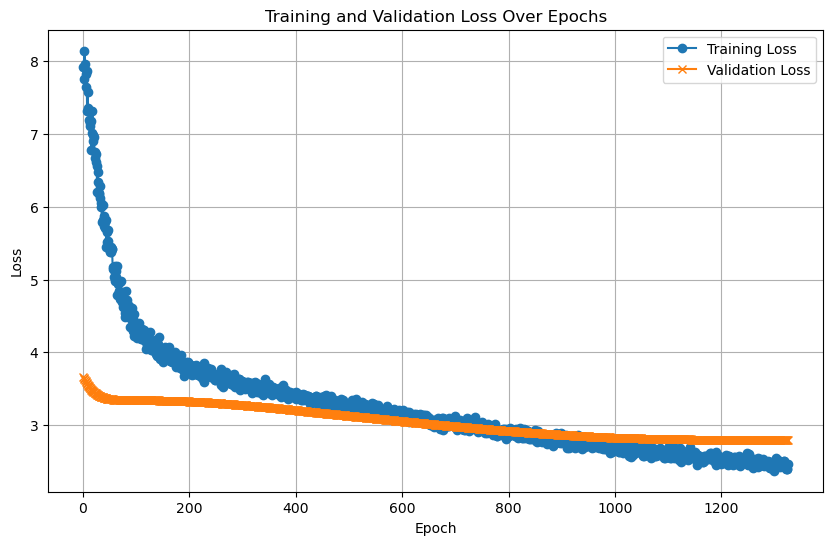

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/13], Loss: 5.3184



Test Loss: 5.0271


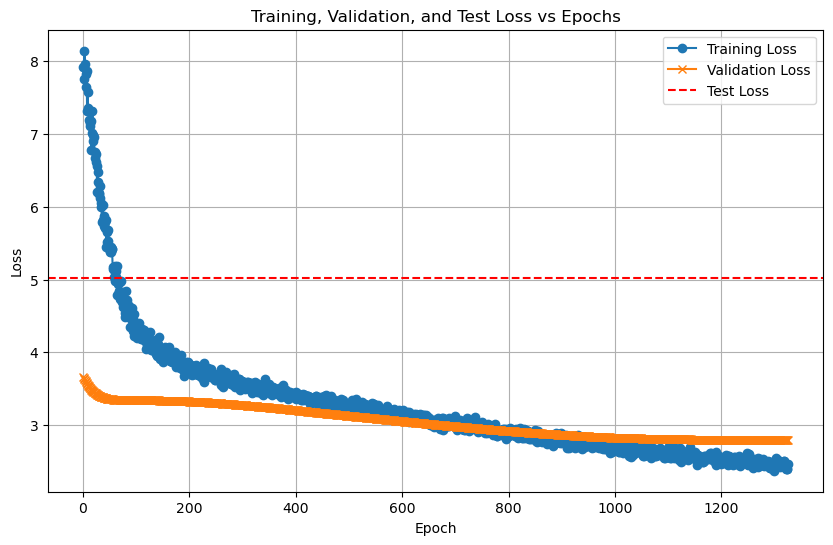

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/13 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (70, 128)
Train labels shape: (70,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3108, 128)
Test labels shape: (3108,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 71.43%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.67      0.80      0.73         5
           2       0.62      1.00      0.77         5
           3       0.71      1.00      0.83         5
           4       0.50      0.20      0.29         5
           5       0.25      0.20      0.22         5
           6       1.00      1.00      1.00         5
           7       1.00      0.20      0.33         5
           8       0.50      0.60      0.55         5
           9       0.67      0.80      0.73         5
          10       0.67      0.80      0.73         5
          11       0.71      1.00      0.83         5
          12       1.00      0.40      0.57         5
          13       1.0

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (70, 128)
Train labels shape: (70,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3108, 128)
Test labels shape: (3108,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7015  |  Val Loss: 2.6922
Validation loss improved from inf to 2.6922.
[Epoch 2/1000] Train Loss: 2.6869  |  Val Loss: 2.6807
Validation loss improved from 2.6922 to 2.6807.
[Epoch 3/1000] Train Loss: 2.6736  |  Val Loss: 2.6705
Validation loss improved from 2.6807 to 2.6705.
[Epoch 4/1000] Train Loss: 2.6628  |  Val Loss: 2.6608
Validation loss improved from 2.6705 to 2.6608.
[Epoch 5/1000] Train Loss: 2.6520  |  Val Loss: 2.6513
Validation loss improved from 2.6608 to 2.6513.
[Epoch 6/1000] Train Loss: 2.6422  |  Val Loss: 2.6421
Validation loss improved from 2.6513 to 2.6421.
[Epoch 7/1000] Train Loss: 2.6326  |  Val Loss: 2.6335
Validation loss improved from 2.6421 to 2.6335.
[Epoch 8/1000] Train Loss: 2.6230  |  Val Loss: 2.6253
Validation loss improved from 2.6335 to 2.6253.
[Epoch 9/1000] Train Loss: 2.6143  |  Val Loss: 2.6171
Validation loss improved from 2.6253 to 2.6171.
[Epoch 10/1000] Train Loss: 2.6056  |  Val Loss: 2.6091
Validation loss impr

[Epoch 23/1000] Train Loss: 2.5016  |  Val Loss: 2.5181
Validation loss improved from 2.5247 to 2.5181.
[Epoch 24/1000] Train Loss: 2.4941  |  Val Loss: 2.5115
Validation loss improved from 2.5181 to 2.5115.
[Epoch 25/1000] Train Loss: 2.4863  |  Val Loss: 2.5049
Validation loss improved from 2.5115 to 2.5049.
[Epoch 26/1000] Train Loss: 2.4787  |  Val Loss: 2.4984
Validation loss improved from 2.5049 to 2.4984.
[Epoch 27/1000] Train Loss: 2.4712  |  Val Loss: 2.4921
Validation loss improved from 2.4984 to 2.4921.
[Epoch 28/1000] Train Loss: 2.4637  |  Val Loss: 2.4858
Validation loss improved from 2.4921 to 2.4858.
[Epoch 29/1000] Train Loss: 2.4562  |  Val Loss: 2.4793
Validation loss improved from 2.4858 to 2.4793.
[Epoch 30/1000] Train Loss: 2.4486  |  Val Loss: 2.4727
Validation loss improved from 2.4793 to 2.4727.
[Epoch 31/1000] Train Loss: 2.4409  |  Val Loss: 2.4658
Validation loss improved from 2.4727 to 2.4658.
[Epoch 32/1000] Train Loss: 2.4333  |  Val Loss: 2.4588
Validati

[Epoch 37/1000] Train Loss: 2.3936  |  Val Loss: 2.4241
Validation loss improved from 2.4309 to 2.4241.
[Epoch 38/1000] Train Loss: 2.3860  |  Val Loss: 2.4176
Validation loss improved from 2.4241 to 2.4176.
[Epoch 39/1000] Train Loss: 2.3786  |  Val Loss: 2.4115
Validation loss improved from 2.4176 to 2.4115.
[Epoch 40/1000] Train Loss: 2.3711  |  Val Loss: 2.4053
Validation loss improved from 2.4115 to 2.4053.
[Epoch 41/1000] Train Loss: 2.3641  |  Val Loss: 2.3989
Validation loss improved from 2.4053 to 2.3989.
[Epoch 42/1000] Train Loss: 2.3571  |  Val Loss: 2.3924
Validation loss improved from 2.3989 to 2.3924.
[Epoch 43/1000] Train Loss: 2.3495  |  Val Loss: 2.3858
Validation loss improved from 2.3924 to 2.3858.
[Epoch 44/1000] Train Loss: 2.3423  |  Val Loss: 2.3792
Validation loss improved from 2.3858 to 2.3792.
[Epoch 45/1000] Train Loss: 2.3347  |  Val Loss: 2.3728
Validation loss improved from 2.3792 to 2.3728.
[Epoch 46/1000] Train Loss: 2.3276  |  Val Loss: 2.3664
Validati

[Epoch 61/1000] Train Loss: 2.2217  |  Val Loss: 2.2727
Validation loss improved from 2.2786 to 2.2727.
[Epoch 62/1000] Train Loss: 2.2151  |  Val Loss: 2.2668
Validation loss improved from 2.2727 to 2.2668.
[Epoch 63/1000] Train Loss: 2.2088  |  Val Loss: 2.2605
Validation loss improved from 2.2668 to 2.2605.
[Epoch 64/1000] Train Loss: 2.2021  |  Val Loss: 2.2543
Validation loss improved from 2.2605 to 2.2543.
[Epoch 65/1000] Train Loss: 2.1954  |  Val Loss: 2.2484
Validation loss improved from 2.2543 to 2.2484.
[Epoch 66/1000] Train Loss: 2.1887  |  Val Loss: 2.2425
Validation loss improved from 2.2484 to 2.2425.
[Epoch 67/1000] Train Loss: 2.1821  |  Val Loss: 2.2366
Validation loss improved from 2.2425 to 2.2366.
[Epoch 68/1000] Train Loss: 2.1755  |  Val Loss: 2.2306
Validation loss improved from 2.2366 to 2.2306.
[Epoch 69/1000] Train Loss: 2.1689  |  Val Loss: 2.2244
Validation loss improved from 2.2306 to 2.2244.
[Epoch 70/1000] Train Loss: 2.1621  |  Val Loss: 2.2181
Validati

[Epoch 77/1000] Train Loss: 2.1152  |  Val Loss: 2.1762
Validation loss improved from 2.1818 to 2.1762.
[Epoch 78/1000] Train Loss: 2.1087  |  Val Loss: 2.1707
Validation loss improved from 2.1762 to 2.1707.
[Epoch 79/1000] Train Loss: 2.1023  |  Val Loss: 2.1654
Validation loss improved from 2.1707 to 2.1654.
[Epoch 80/1000] Train Loss: 2.0960  |  Val Loss: 2.1601
Validation loss improved from 2.1654 to 2.1601.
[Epoch 81/1000] Train Loss: 2.0896  |  Val Loss: 2.1547
Validation loss improved from 2.1601 to 2.1547.
[Epoch 82/1000] Train Loss: 2.0835  |  Val Loss: 2.1492
Validation loss improved from 2.1547 to 2.1492.
[Epoch 83/1000] Train Loss: 2.0770  |  Val Loss: 2.1434
Validation loss improved from 2.1492 to 2.1434.
[Epoch 84/1000] Train Loss: 2.0707  |  Val Loss: 2.1373
Validation loss improved from 2.1434 to 2.1373.
[Epoch 85/1000] Train Loss: 2.0644  |  Val Loss: 2.1312
Validation loss improved from 2.1373 to 2.1312.
[Epoch 86/1000] Train Loss: 2.0576  |  Val Loss: 2.1251
Validati

[Epoch 99/1000] Train Loss: 1.9777  |  Val Loss: 2.0518
Validation loss improved from 2.0570 to 2.0518.
[Epoch 100/1000] Train Loss: 1.9718  |  Val Loss: 2.0468
Validation loss improved from 2.0518 to 2.0468.
[Epoch 101/1000] Train Loss: 1.9660  |  Val Loss: 2.0418
Validation loss improved from 2.0468 to 2.0418.
[Epoch 102/1000] Train Loss: 1.9605  |  Val Loss: 2.0369
Validation loss improved from 2.0418 to 2.0369.
[Epoch 103/1000] Train Loss: 1.9549  |  Val Loss: 2.0321
Validation loss improved from 2.0369 to 2.0321.
[Epoch 104/1000] Train Loss: 1.9493  |  Val Loss: 2.0271
Validation loss improved from 2.0321 to 2.0271.
[Epoch 105/1000] Train Loss: 1.9438  |  Val Loss: 2.0219
Validation loss improved from 2.0271 to 2.0219.
[Epoch 106/1000] Train Loss: 1.9380  |  Val Loss: 2.0167
Validation loss improved from 2.0219 to 2.0167.
[Epoch 107/1000] Train Loss: 1.9327  |  Val Loss: 2.0116
Validation loss improved from 2.0167 to 2.0116.
[Epoch 108/1000] Train Loss: 1.9272  |  Val Loss: 2.0067

[Epoch 116/1000] Train Loss: 1.8835  |  Val Loss: 1.9679
Validation loss improved from 1.9728 to 1.9679.
[Epoch 117/1000] Train Loss: 1.8782  |  Val Loss: 1.9631
Validation loss improved from 1.9679 to 1.9631.
[Epoch 118/1000] Train Loss: 1.8729  |  Val Loss: 1.9582
Validation loss improved from 1.9631 to 1.9582.
[Epoch 119/1000] Train Loss: 1.8676  |  Val Loss: 1.9534
Validation loss improved from 1.9582 to 1.9534.
[Epoch 120/1000] Train Loss: 1.8623  |  Val Loss: 1.9486
Validation loss improved from 1.9534 to 1.9486.
[Epoch 121/1000] Train Loss: 1.8568  |  Val Loss: 1.9439
Validation loss improved from 1.9486 to 1.9439.
[Epoch 122/1000] Train Loss: 1.8513  |  Val Loss: 1.9393
Validation loss improved from 1.9439 to 1.9393.
[Epoch 123/1000] Train Loss: 1.8460  |  Val Loss: 1.9347
Validation loss improved from 1.9393 to 1.9347.
[Epoch 124/1000] Train Loss: 1.8407  |  Val Loss: 1.9300
Validation loss improved from 1.9347 to 1.9300.
[Epoch 125/1000] Train Loss: 1.8352  |  Val Loss: 1.925

[Epoch 141/1000] Train Loss: 1.7487  |  Val Loss: 1.8536
Validation loss improved from 1.8581 to 1.8536.
[Epoch 142/1000] Train Loss: 1.7435  |  Val Loss: 1.8491
Validation loss improved from 1.8536 to 1.8491.
[Epoch 143/1000] Train Loss: 1.7381  |  Val Loss: 1.8445
Validation loss improved from 1.8491 to 1.8445.
[Epoch 144/1000] Train Loss: 1.7327  |  Val Loss: 1.8397
Validation loss improved from 1.8445 to 1.8397.
[Epoch 145/1000] Train Loss: 1.7273  |  Val Loss: 1.8350
Validation loss improved from 1.8397 to 1.8350.
[Epoch 146/1000] Train Loss: 1.7220  |  Val Loss: 1.8304
Validation loss improved from 1.8350 to 1.8304.
[Epoch 147/1000] Train Loss: 1.7167  |  Val Loss: 1.8259
Validation loss improved from 1.8304 to 1.8259.
[Epoch 148/1000] Train Loss: 1.7116  |  Val Loss: 1.8213
Validation loss improved from 1.8259 to 1.8213.
[Epoch 149/1000] Train Loss: 1.7065  |  Val Loss: 1.8167
Validation loss improved from 1.8213 to 1.8167.
[Epoch 150/1000] Train Loss: 1.7015  |  Val Loss: 1.812

[Epoch 156/1000] Train Loss: 1.6694  |  Val Loss: 1.7830
Validation loss improved from 1.7881 to 1.7830.
[Epoch 157/1000] Train Loss: 1.6637  |  Val Loss: 1.7777
Validation loss improved from 1.7830 to 1.7777.
[Epoch 158/1000] Train Loss: 1.6578  |  Val Loss: 1.7724
Validation loss improved from 1.7777 to 1.7724.
[Epoch 159/1000] Train Loss: 1.6521  |  Val Loss: 1.7672
Validation loss improved from 1.7724 to 1.7672.
[Epoch 160/1000] Train Loss: 1.6464  |  Val Loss: 1.7621
Validation loss improved from 1.7672 to 1.7621.
[Epoch 161/1000] Train Loss: 1.6409  |  Val Loss: 1.7570
Validation loss improved from 1.7621 to 1.7570.
[Epoch 162/1000] Train Loss: 1.6353  |  Val Loss: 1.7519
Validation loss improved from 1.7570 to 1.7519.
[Epoch 163/1000] Train Loss: 1.6295  |  Val Loss: 1.7468
Validation loss improved from 1.7519 to 1.7468.
[Epoch 164/1000] Train Loss: 1.6239  |  Val Loss: 1.7420
Validation loss improved from 1.7468 to 1.7420.
[Epoch 165/1000] Train Loss: 1.6182  |  Val Loss: 1.737

[Epoch 180/1000] Train Loss: 1.5346  |  Val Loss: 1.6676
Validation loss improved from 1.6720 to 1.6676.
[Epoch 181/1000] Train Loss: 1.5291  |  Val Loss: 1.6630
Validation loss improved from 1.6676 to 1.6630.
[Epoch 182/1000] Train Loss: 1.5237  |  Val Loss: 1.6584
Validation loss improved from 1.6630 to 1.6584.
[Epoch 183/1000] Train Loss: 1.5182  |  Val Loss: 1.6538
Validation loss improved from 1.6584 to 1.6538.
[Epoch 184/1000] Train Loss: 1.5125  |  Val Loss: 1.6492
Validation loss improved from 1.6538 to 1.6492.
[Epoch 185/1000] Train Loss: 1.5073  |  Val Loss: 1.6446
Validation loss improved from 1.6492 to 1.6446.
[Epoch 186/1000] Train Loss: 1.5019  |  Val Loss: 1.6403
Validation loss improved from 1.6446 to 1.6403.
[Epoch 187/1000] Train Loss: 1.4965  |  Val Loss: 1.6361
Validation loss improved from 1.6403 to 1.6361.
[Epoch 188/1000] Train Loss: 1.4914  |  Val Loss: 1.6320
Validation loss improved from 1.6361 to 1.6320.
[Epoch 189/1000] Train Loss: 1.4861  |  Val Loss: 1.627

[Epoch 202/1000] Train Loss: 1.4166  |  Val Loss: 1.5716
Validation loss improved from 1.5756 to 1.5716.
[Epoch 203/1000] Train Loss: 1.4114  |  Val Loss: 1.5674
Validation loss improved from 1.5716 to 1.5674.
[Epoch 204/1000] Train Loss: 1.4061  |  Val Loss: 1.5633
Validation loss improved from 1.5674 to 1.5633.
[Epoch 205/1000] Train Loss: 1.4007  |  Val Loss: 1.5594
Validation loss improved from 1.5633 to 1.5594.
[Epoch 206/1000] Train Loss: 1.3953  |  Val Loss: 1.5553
Validation loss improved from 1.5594 to 1.5553.
[Epoch 207/1000] Train Loss: 1.3898  |  Val Loss: 1.5512
Validation loss improved from 1.5553 to 1.5512.
[Epoch 208/1000] Train Loss: 1.3842  |  Val Loss: 1.5470
Validation loss improved from 1.5512 to 1.5470.
[Epoch 209/1000] Train Loss: 1.3787  |  Val Loss: 1.5428
Validation loss improved from 1.5470 to 1.5428.
[Epoch 210/1000] Train Loss: 1.3732  |  Val Loss: 1.5385
Validation loss improved from 1.5428 to 1.5385.
[Epoch 211/1000] Train Loss: 1.3675  |  Val Loss: 1.534

[Epoch 222/1000] Train Loss: 1.3085  |  Val Loss: 1.4918
Validation loss improved from 1.4959 to 1.4918.
[Epoch 223/1000] Train Loss: 1.3031  |  Val Loss: 1.4878
Validation loss improved from 1.4918 to 1.4878.
[Epoch 224/1000] Train Loss: 1.2977  |  Val Loss: 1.4837
Validation loss improved from 1.4878 to 1.4837.
[Epoch 225/1000] Train Loss: 1.2923  |  Val Loss: 1.4795
Validation loss improved from 1.4837 to 1.4795.
[Epoch 226/1000] Train Loss: 1.2867  |  Val Loss: 1.4753
Validation loss improved from 1.4795 to 1.4753.
[Epoch 227/1000] Train Loss: 1.2812  |  Val Loss: 1.4712
Validation loss improved from 1.4753 to 1.4712.
[Epoch 228/1000] Train Loss: 1.2756  |  Val Loss: 1.4672
Validation loss improved from 1.4712 to 1.4672.
[Epoch 229/1000] Train Loss: 1.2701  |  Val Loss: 1.4628
Validation loss improved from 1.4672 to 1.4628.
[Epoch 230/1000] Train Loss: 1.2645  |  Val Loss: 1.4581
Validation loss improved from 1.4628 to 1.4581.
[Epoch 231/1000] Train Loss: 1.2591  |  Val Loss: 1.453

[Epoch 241/1000] Train Loss: 1.2047  |  Val Loss: 1.4084
Validation loss improved from 1.4122 to 1.4084.
[Epoch 242/1000] Train Loss: 1.1996  |  Val Loss: 1.4047
Validation loss improved from 1.4084 to 1.4047.
[Epoch 243/1000] Train Loss: 1.1945  |  Val Loss: 1.4008
Validation loss improved from 1.4047 to 1.4008.
[Epoch 244/1000] Train Loss: 1.1893  |  Val Loss: 1.3968
Validation loss improved from 1.4008 to 1.3968.
[Epoch 245/1000] Train Loss: 1.1840  |  Val Loss: 1.3927
Validation loss improved from 1.3968 to 1.3927.
[Epoch 246/1000] Train Loss: 1.1786  |  Val Loss: 1.3886
Validation loss improved from 1.3927 to 1.3886.
[Epoch 247/1000] Train Loss: 1.1733  |  Val Loss: 1.3846
Validation loss improved from 1.3886 to 1.3846.
[Epoch 248/1000] Train Loss: 1.1682  |  Val Loss: 1.3806
Validation loss improved from 1.3846 to 1.3806.
[Epoch 249/1000] Train Loss: 1.1631  |  Val Loss: 1.3767
Validation loss improved from 1.3806 to 1.3767.
[Epoch 250/1000] Train Loss: 1.1576  |  Val Loss: 1.372

[Epoch 260/1000] Train Loss: 1.1077  |  Val Loss: 1.3346
Validation loss improved from 1.3387 to 1.3346.
[Epoch 261/1000] Train Loss: 1.1028  |  Val Loss: 1.3304
Validation loss improved from 1.3346 to 1.3304.
[Epoch 262/1000] Train Loss: 1.0983  |  Val Loss: 1.3265
Validation loss improved from 1.3304 to 1.3265.
[Epoch 263/1000] Train Loss: 1.0937  |  Val Loss: 1.3226
Validation loss improved from 1.3265 to 1.3226.
[Epoch 264/1000] Train Loss: 1.0891  |  Val Loss: 1.3187
Validation loss improved from 1.3226 to 1.3187.
[Epoch 265/1000] Train Loss: 1.0844  |  Val Loss: 1.3148
Validation loss improved from 1.3187 to 1.3148.
[Epoch 266/1000] Train Loss: 1.0798  |  Val Loss: 1.3112
Validation loss improved from 1.3148 to 1.3112.
[Epoch 267/1000] Train Loss: 1.0753  |  Val Loss: 1.3077
Validation loss improved from 1.3112 to 1.3077.
[Epoch 268/1000] Train Loss: 1.0706  |  Val Loss: 1.3042
Validation loss improved from 1.3077 to 1.3042.
[Epoch 269/1000] Train Loss: 1.0659  |  Val Loss: 1.300

[Epoch 282/1000] Train Loss: 1.0108  |  Val Loss: 1.2585
Validation loss improved from 1.2620 to 1.2585.
[Epoch 283/1000] Train Loss: 1.0065  |  Val Loss: 1.2546
Validation loss improved from 1.2585 to 1.2546.
[Epoch 284/1000] Train Loss: 1.0024  |  Val Loss: 1.2506
Validation loss improved from 1.2546 to 1.2506.
[Epoch 285/1000] Train Loss: 0.9980  |  Val Loss: 1.2469
Validation loss improved from 1.2506 to 1.2469.
[Epoch 286/1000] Train Loss: 0.9939  |  Val Loss: 1.2436
Validation loss improved from 1.2469 to 1.2436.
[Epoch 287/1000] Train Loss: 0.9897  |  Val Loss: 1.2408
Validation loss improved from 1.2436 to 1.2408.
[Epoch 288/1000] Train Loss: 0.9860  |  Val Loss: 1.2383
Validation loss improved from 1.2408 to 1.2383.
[Epoch 289/1000] Train Loss: 0.9823  |  Val Loss: 1.2359
Validation loss improved from 1.2383 to 1.2359.
[Epoch 290/1000] Train Loss: 0.9786  |  Val Loss: 1.2335
Validation loss improved from 1.2359 to 1.2335.
[Epoch 291/1000] Train Loss: 0.9750  |  Val Loss: 1.231

[Epoch 302/1000] Train Loss: 0.9294  |  Val Loss: 1.1959
Validation loss improved from 1.1990 to 1.1959.
[Epoch 303/1000] Train Loss: 0.9257  |  Val Loss: 1.1929
Validation loss improved from 1.1959 to 1.1929.
[Epoch 304/1000] Train Loss: 0.9220  |  Val Loss: 1.1898
Validation loss improved from 1.1929 to 1.1898.
[Epoch 305/1000] Train Loss: 0.9182  |  Val Loss: 1.1866
Validation loss improved from 1.1898 to 1.1866.
[Epoch 306/1000] Train Loss: 0.9144  |  Val Loss: 1.1836
Validation loss improved from 1.1866 to 1.1836.
[Epoch 307/1000] Train Loss: 0.9108  |  Val Loss: 1.1806
Validation loss improved from 1.1836 to 1.1806.
[Epoch 308/1000] Train Loss: 0.9069  |  Val Loss: 1.1776
Validation loss improved from 1.1806 to 1.1776.
[Epoch 309/1000] Train Loss: 0.9033  |  Val Loss: 1.1748
Validation loss improved from 1.1776 to 1.1748.
[Epoch 310/1000] Train Loss: 0.8998  |  Val Loss: 1.1722
Validation loss improved from 1.1748 to 1.1722.
[Epoch 311/1000] Train Loss: 0.8962  |  Val Loss: 1.169

[Epoch 323/1000] Train Loss: 0.8545  |  Val Loss: 1.1419
Validation loss improved from 1.1437 to 1.1419.
[Epoch 324/1000] Train Loss: 0.8511  |  Val Loss: 1.1399
Validation loss improved from 1.1419 to 1.1399.
[Epoch 325/1000] Train Loss: 0.8476  |  Val Loss: 1.1379
Validation loss improved from 1.1399 to 1.1379.
[Epoch 326/1000] Train Loss: 0.8440  |  Val Loss: 1.1358
Validation loss improved from 1.1379 to 1.1358.
[Epoch 327/1000] Train Loss: 0.8404  |  Val Loss: 1.1332
Validation loss improved from 1.1358 to 1.1332.
[Epoch 328/1000] Train Loss: 0.8367  |  Val Loss: 1.1306
Validation loss improved from 1.1332 to 1.1306.
[Epoch 329/1000] Train Loss: 0.8330  |  Val Loss: 1.1280
Validation loss improved from 1.1306 to 1.1280.
[Epoch 330/1000] Train Loss: 0.8297  |  Val Loss: 1.1254
Validation loss improved from 1.1280 to 1.1254.
[Epoch 331/1000] Train Loss: 0.8262  |  Val Loss: 1.1228
Validation loss improved from 1.1254 to 1.1228.
[Epoch 332/1000] Train Loss: 0.8227  |  Val Loss: 1.120

[Epoch 343/1000] Train Loss: 0.7858  |  Val Loss: 1.0862
Validation loss improved from 1.0892 to 1.0862.
[Epoch 344/1000] Train Loss: 0.7821  |  Val Loss: 1.0833
Validation loss improved from 1.0862 to 1.0833.
[Epoch 345/1000] Train Loss: 0.7784  |  Val Loss: 1.0809
Validation loss improved from 1.0833 to 1.0809.
[Epoch 346/1000] Train Loss: 0.7746  |  Val Loss: 1.0787
Validation loss improved from 1.0809 to 1.0787.
[Epoch 347/1000] Train Loss: 0.7706  |  Val Loss: 1.0768
Validation loss improved from 1.0787 to 1.0768.
[Epoch 348/1000] Train Loss: 0.7671  |  Val Loss: 1.0751
Validation loss improved from 1.0768 to 1.0751.
[Epoch 349/1000] Train Loss: 0.7634  |  Val Loss: 1.0735
Validation loss improved from 1.0751 to 1.0735.
[Epoch 350/1000] Train Loss: 0.7602  |  Val Loss: 1.0719
Validation loss improved from 1.0735 to 1.0719.
[Epoch 351/1000] Train Loss: 0.7567  |  Val Loss: 1.0700
Validation loss improved from 1.0719 to 1.0700.
[Epoch 352/1000] Train Loss: 0.7535  |  Val Loss: 1.068

[Epoch 362/1000] Train Loss: 0.7223  |  Val Loss: 1.0422
Validation loss improved from 1.0448 to 1.0422.
[Epoch 363/1000] Train Loss: 0.7191  |  Val Loss: 1.0397
Validation loss improved from 1.0422 to 1.0397.
[Epoch 364/1000] Train Loss: 0.7162  |  Val Loss: 1.0369
Validation loss improved from 1.0397 to 1.0369.
[Epoch 365/1000] Train Loss: 0.7132  |  Val Loss: 1.0341
Validation loss improved from 1.0369 to 1.0341.
[Epoch 366/1000] Train Loss: 0.7102  |  Val Loss: 1.0317
Validation loss improved from 1.0341 to 1.0317.
[Epoch 367/1000] Train Loss: 0.7078  |  Val Loss: 1.0298
Validation loss improved from 1.0317 to 1.0298.
[Epoch 368/1000] Train Loss: 0.7045  |  Val Loss: 1.0283
Validation loss improved from 1.0298 to 1.0283.
[Epoch 369/1000] Train Loss: 0.7014  |  Val Loss: 1.0266
Validation loss improved from 1.0283 to 1.0266.
[Epoch 370/1000] Train Loss: 0.6983  |  Val Loss: 1.0248
Validation loss improved from 1.0266 to 1.0248.
[Epoch 371/1000] Train Loss: 0.6952  |  Val Loss: 1.023

[Epoch 387/1000] Train Loss: 0.6503  |  Val Loss: 0.9961
Validation loss improved from 0.9983 to 0.9961.
[Epoch 388/1000] Train Loss: 0.6475  |  Val Loss: 0.9940
Validation loss improved from 0.9961 to 0.9940.
[Epoch 389/1000] Train Loss: 0.6447  |  Val Loss: 0.9921
Validation loss improved from 0.9940 to 0.9921.
[Epoch 390/1000] Train Loss: 0.6419  |  Val Loss: 0.9905
Validation loss improved from 0.9921 to 0.9905.
[Epoch 391/1000] Train Loss: 0.6391  |  Val Loss: 0.9889
Validation loss improved from 0.9905 to 0.9889.
[Epoch 392/1000] Train Loss: 0.6365  |  Val Loss: 0.9875
Validation loss improved from 0.9889 to 0.9875.
[Epoch 393/1000] Train Loss: 0.6339  |  Val Loss: 0.9860
Validation loss improved from 0.9875 to 0.9860.
[Epoch 394/1000] Train Loss: 0.6311  |  Val Loss: 0.9843
Validation loss improved from 0.9860 to 0.9843.
[Epoch 395/1000] Train Loss: 0.6286  |  Val Loss: 0.9826
Validation loss improved from 0.9843 to 0.9826.
[Epoch 396/1000] Train Loss: 0.6261  |  Val Loss: 0.980

[Epoch 405/1000] Train Loss: 0.6044  |  Val Loss: 0.9653
Validation loss improved from 0.9667 to 0.9653.
[Epoch 406/1000] Train Loss: 0.6024  |  Val Loss: 0.9639
Validation loss improved from 0.9653 to 0.9639.
[Epoch 407/1000] Train Loss: 0.6007  |  Val Loss: 0.9621
Validation loss improved from 0.9639 to 0.9621.
[Epoch 408/1000] Train Loss: 0.5982  |  Val Loss: 0.9605
Validation loss improved from 0.9621 to 0.9605.
[Epoch 409/1000] Train Loss: 0.5959  |  Val Loss: 0.9591
Validation loss improved from 0.9605 to 0.9591.
[Epoch 410/1000] Train Loss: 0.5935  |  Val Loss: 0.9578
Validation loss improved from 0.9591 to 0.9578.
[Epoch 411/1000] Train Loss: 0.5913  |  Val Loss: 0.9568
Validation loss improved from 0.9578 to 0.9568.
[Epoch 412/1000] Train Loss: 0.5894  |  Val Loss: 0.9561
Validation loss improved from 0.9568 to 0.9561.
[Epoch 413/1000] Train Loss: 0.5875  |  Val Loss: 0.9551
Validation loss improved from 0.9561 to 0.9551.
[Epoch 414/1000] Train Loss: 0.5852  |  Val Loss: 0.954

[Epoch 428/1000] Train Loss: 0.5569  |  Val Loss: 0.9434
Validation loss improved from 0.9447 to 0.9434.
[Epoch 429/1000] Train Loss: 0.5548  |  Val Loss: 0.9420
Validation loss improved from 0.9434 to 0.9420.
[Epoch 430/1000] Train Loss: 0.5528  |  Val Loss: 0.9406
Validation loss improved from 0.9420 to 0.9406.
[Epoch 431/1000] Train Loss: 0.5508  |  Val Loss: 0.9388
Validation loss improved from 0.9406 to 0.9388.
[Epoch 432/1000] Train Loss: 0.5485  |  Val Loss: 0.9368
Validation loss improved from 0.9388 to 0.9368.
[Epoch 433/1000] Train Loss: 0.5463  |  Val Loss: 0.9351
Validation loss improved from 0.9368 to 0.9351.
[Epoch 434/1000] Train Loss: 0.5439  |  Val Loss: 0.9332
Validation loss improved from 0.9351 to 0.9332.
[Epoch 435/1000] Train Loss: 0.5418  |  Val Loss: 0.9313
Validation loss improved from 0.9332 to 0.9313.
[Epoch 436/1000] Train Loss: 0.5395  |  Val Loss: 0.9297
Validation loss improved from 0.9313 to 0.9297.
[Epoch 437/1000] Train Loss: 0.5375  |  Val Loss: 0.928

[Epoch 446/1000] Train Loss: 0.5221  |  Val Loss: 0.9131
Validation loss improved from 0.9155 to 0.9131.
[Epoch 447/1000] Train Loss: 0.5200  |  Val Loss: 0.9106
Validation loss improved from 0.9131 to 0.9106.
[Epoch 448/1000] Train Loss: 0.5179  |  Val Loss: 0.9078
Validation loss improved from 0.9106 to 0.9078.
[Epoch 449/1000] Train Loss: 0.5157  |  Val Loss: 0.9052
Validation loss improved from 0.9078 to 0.9052.
[Epoch 450/1000] Train Loss: 0.5135  |  Val Loss: 0.9026
Validation loss improved from 0.9052 to 0.9026.
[Epoch 451/1000] Train Loss: 0.5117  |  Val Loss: 0.9003
Validation loss improved from 0.9026 to 0.9003.
[Epoch 452/1000] Train Loss: 0.5101  |  Val Loss: 0.8984
Validation loss improved from 0.9003 to 0.8984.
[Epoch 453/1000] Train Loss: 0.5084  |  Val Loss: 0.8969
Validation loss improved from 0.8984 to 0.8969.
[Epoch 454/1000] Train Loss: 0.5065  |  Val Loss: 0.8955
Validation loss improved from 0.8969 to 0.8955.
[Epoch 455/1000] Train Loss: 0.5048  |  Val Loss: 0.894

[Epoch 467/1000] Train Loss: 0.4844  |  Val Loss: 0.8826
Validation loss improved from 0.8834 to 0.8826.
[Epoch 468/1000] Train Loss: 0.4823  |  Val Loss: 0.8821
Validation loss improved from 0.8826 to 0.8821.
[Epoch 469/1000] Train Loss: 0.4806  |  Val Loss: 0.8815
Validation loss improved from 0.8821 to 0.8815.
[Epoch 470/1000] Train Loss: 0.4787  |  Val Loss: 0.8808
Validation loss improved from 0.8815 to 0.8808.
[Epoch 471/1000] Train Loss: 0.4771  |  Val Loss: 0.8803
Validation loss improved from 0.8808 to 0.8803.
[Epoch 472/1000] Train Loss: 0.4753  |  Val Loss: 0.8798
Validation loss improved from 0.8803 to 0.8798.
[Epoch 473/1000] Train Loss: 0.4735  |  Val Loss: 0.8792
Validation loss improved from 0.8798 to 0.8792.
[Epoch 474/1000] Train Loss: 0.4715  |  Val Loss: 0.8784
Validation loss improved from 0.8792 to 0.8784.
[Epoch 475/1000] Train Loss: 0.4697  |  Val Loss: 0.8777
Validation loss improved from 0.8784 to 0.8777.
[Epoch 476/1000] Train Loss: 0.4679  |  Val Loss: 0.876

[Epoch 486/1000] Train Loss: 0.4507  |  Val Loss: 0.8688
Validation loss improved from 0.8690 to 0.8688.
[Epoch 487/1000] Train Loss: 0.4491  |  Val Loss: 0.8686
Validation loss improved from 0.8688 to 0.8686.
[Epoch 488/1000] Train Loss: 0.4476  |  Val Loss: 0.8686
Validation loss improved from 0.8686 to 0.8686.
[Epoch 489/1000] Train Loss: 0.4464  |  Val Loss: 0.8686
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 490/1000] Train Loss: 0.4451  |  Val Loss: 0.8682
Validation loss improved from 0.8686 to 0.8682.
[Epoch 491/1000] Train Loss: 0.4437  |  Val Loss: 0.8674
Validation loss improved from 0.8682 to 0.8674.
[Epoch 492/1000] Train Loss: 0.4423  |  Val Loss: 0.8670
Validation loss improved from 0.8674 to 0.8670.
[Epoch 493/1000] Train Loss: 0.4409  |  Val Loss: 0.8668
Validation loss improved from 0.8670 to 0.8668.
[Epoch 494/1000] Train Loss: 0.4396  |  Val Loss: 0.8665
Validation loss improved from 0.8668 to 0.8665.
[Epoch 495/1000] Train Loss: 0.4383  |  Val Loss:

[Epoch 508/1000] Train Loss: 0.4194  |  Val Loss: 0.8561
Validation loss improved from 0.8566 to 0.8561.
[Epoch 509/1000] Train Loss: 0.4185  |  Val Loss: 0.8557
Validation loss improved from 0.8561 to 0.8557.
[Epoch 510/1000] Train Loss: 0.4172  |  Val Loss: 0.8547
Validation loss improved from 0.8557 to 0.8547.
[Epoch 511/1000] Train Loss: 0.4164  |  Val Loss: 0.8531
Validation loss improved from 0.8547 to 0.8531.
[Epoch 512/1000] Train Loss: 0.4151  |  Val Loss: 0.8516
Validation loss improved from 0.8531 to 0.8516.
[Epoch 513/1000] Train Loss: 0.4137  |  Val Loss: 0.8501
Validation loss improved from 0.8516 to 0.8501.
[Epoch 514/1000] Train Loss: 0.4122  |  Val Loss: 0.8489
Validation loss improved from 0.8501 to 0.8489.
[Epoch 515/1000] Train Loss: 0.4107  |  Val Loss: 0.8476
Validation loss improved from 0.8489 to 0.8476.
[Epoch 516/1000] Train Loss: 0.4092  |  Val Loss: 0.8463
Validation loss improved from 0.8476 to 0.8463.
[Epoch 517/1000] Train Loss: 0.4078  |  Val Loss: 0.845

[Epoch 524/1000] Train Loss: 0.3994  |  Val Loss: 0.8388
Validation loss improved from 0.8404 to 0.8388.
[Epoch 525/1000] Train Loss: 0.3981  |  Val Loss: 0.8374
Validation loss improved from 0.8388 to 0.8374.
[Epoch 526/1000] Train Loss: 0.3969  |  Val Loss: 0.8364
Validation loss improved from 0.8374 to 0.8364.
[Epoch 527/1000] Train Loss: 0.3956  |  Val Loss: 0.8357
Validation loss improved from 0.8364 to 0.8357.
[Epoch 528/1000] Train Loss: 0.3947  |  Val Loss: 0.8348
Validation loss improved from 0.8357 to 0.8348.
[Epoch 529/1000] Train Loss: 0.3936  |  Val Loss: 0.8340
Validation loss improved from 0.8348 to 0.8340.
[Epoch 530/1000] Train Loss: 0.3923  |  Val Loss: 0.8339
Validation loss improved from 0.8340 to 0.8339.
[Epoch 531/1000] Train Loss: 0.3912  |  Val Loss: 0.8339
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 532/1000] Train Loss: 0.3898  |  Val Loss: 0.8336
Validation loss improved from 0.8339 to 0.8336.
[Epoch 533/1000] Train Loss: 0.3887  |  Val Loss:

[Epoch 545/1000] Train Loss: 0.3762  |  Val Loss: 0.8280
Validation loss improved from 0.8286 to 0.8280.
[Epoch 546/1000] Train Loss: 0.3750  |  Val Loss: 0.8273
Validation loss improved from 0.8280 to 0.8273.
[Epoch 547/1000] Train Loss: 0.3740  |  Val Loss: 0.8266
Validation loss improved from 0.8273 to 0.8266.
[Epoch 548/1000] Train Loss: 0.3731  |  Val Loss: 0.8258
Validation loss improved from 0.8266 to 0.8258.
[Epoch 549/1000] Train Loss: 0.3721  |  Val Loss: 0.8250
Validation loss improved from 0.8258 to 0.8250.
[Epoch 550/1000] Train Loss: 0.3710  |  Val Loss: 0.8240
Validation loss improved from 0.8250 to 0.8240.
[Epoch 551/1000] Train Loss: 0.3698  |  Val Loss: 0.8225
Validation loss improved from 0.8240 to 0.8225.
[Epoch 552/1000] Train Loss: 0.3681  |  Val Loss: 0.8206
Validation loss improved from 0.8225 to 0.8206.
[Epoch 553/1000] Train Loss: 0.3672  |  Val Loss: 0.8192
Validation loss improved from 0.8206 to 0.8192.
[Epoch 554/1000] Train Loss: 0.3657  |  Val Loss: 0.818

[Epoch 564/1000] Train Loss: 0.3575  |  Val Loss: 0.8166
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 565/1000] Train Loss: 0.3568  |  Val Loss: 0.8168
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 566/1000] Train Loss: 0.3558  |  Val Loss: 0.8167
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 567/1000] Train Loss: 0.3549  |  Val Loss: 0.8167
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 568/1000] Train Loss: 0.3539  |  Val Loss: 0.8163
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 569/1000] Train Loss: 0.3530  |  Val Loss: 0.8153
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 570/1000] Train Loss: 0.3523  |  Val Loss: 0.8138
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 571/1000] Train Loss: 0.3514  |  Val Loss: 0.8129
Validation loss improved from 0.8136 to 0.8129.
[Epoch 572/1000] Train Loss: 0.3514  |  Val Loss: 0.8122
Validation loss improved from 0.8129 to 0.8122.
[Epoch 573/10

[Epoch 586/1000] Train Loss: 0.3399  |  Val Loss: 0.7998
Validation loss improved from 0.8007 to 0.7998.
[Epoch 587/1000] Train Loss: 0.3385  |  Val Loss: 0.7995
Validation loss improved from 0.7998 to 0.7995.
[Epoch 588/1000] Train Loss: 0.3372  |  Val Loss: 0.7994
Validation loss improved from 0.7995 to 0.7994.
[Epoch 589/1000] Train Loss: 0.3354  |  Val Loss: 0.7997
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 590/1000] Train Loss: 0.3341  |  Val Loss: 0.8005
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 591/1000] Train Loss: 0.3328  |  Val Loss: 0.8013
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 592/1000] Train Loss: 0.3317  |  Val Loss: 0.8018
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 593/1000] Train Loss: 0.3310  |  Val Loss: 0.8025
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 594/1000] Train Loss: 0.3304  |  Val Loss: 0.8030
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 595/1000] Tr

[Epoch 607/1000] Train Loss: 0.3188  |  Val Loss: 0.7983
Validation loss improved from 0.7994 to 0.7983.
[Epoch 608/1000] Train Loss: 0.3179  |  Val Loss: 0.7971
Validation loss improved from 0.7983 to 0.7971.
[Epoch 609/1000] Train Loss: 0.3170  |  Val Loss: 0.7958
Validation loss improved from 0.7971 to 0.7958.
[Epoch 610/1000] Train Loss: 0.3162  |  Val Loss: 0.7944
Validation loss improved from 0.7958 to 0.7944.
[Epoch 611/1000] Train Loss: 0.3154  |  Val Loss: 0.7928
Validation loss improved from 0.7944 to 0.7928.
[Epoch 612/1000] Train Loss: 0.3145  |  Val Loss: 0.7909
Validation loss improved from 0.7928 to 0.7909.
[Epoch 613/1000] Train Loss: 0.3139  |  Val Loss: 0.7891
Validation loss improved from 0.7909 to 0.7891.
[Epoch 614/1000] Train Loss: 0.3132  |  Val Loss: 0.7873
Validation loss improved from 0.7891 to 0.7873.
[Epoch 615/1000] Train Loss: 0.3126  |  Val Loss: 0.7858
Validation loss improved from 0.7873 to 0.7858.
[Epoch 616/1000] Train Loss: 0.3119  |  Val Loss: 0.784

[Epoch 628/1000] Train Loss: 0.3085  |  Val Loss: 0.7933
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 629/1000] Train Loss: 0.3075  |  Val Loss: 0.7936
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 630/1000] Train Loss: 0.3064  |  Val Loss: 0.7938
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 631/1000] Train Loss: 0.3050  |  Val Loss: 0.7938
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 632/1000] Train Loss: 0.3039  |  Val Loss: 0.7938
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 633/1000] Train Loss: 0.3031  |  Val Loss: 0.7933
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 634/1000] Train Loss: 0.3019  |  Val Loss: 0.7925
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 635/1000] Train Loss: 0.3004  |  Val Loss: 0.7923
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 636/1000] Train Loss: 0.2994  |  Val Loss: 0.7925
!! Validation loss did NOT improve !! Patience:

[Epoch 649/1000] Train Loss: 0.2895  |  Val Loss: 0.7906
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 650/1000] Train Loss: 0.2892  |  Val Loss: 0.7901
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 651/1000] Train Loss: 0.2888  |  Val Loss: 0.7893
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 652/1000] Train Loss: 0.2885  |  Val Loss: 0.7883
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 653/1000] Train Loss: 0.2885  |  Val Loss: 0.7876
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 654/1000] Train Loss: 0.2885  |  Val Loss: 0.7870
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 655/1000] Train Loss: 0.2881  |  Val Loss: 0.7864
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 656/1000] Train Loss: 0.2875  |  Val Loss: 0.7859
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 657/1000] Train Loss: 0.2868  |  Val Loss: 0.7853
!! Validation loss did NOT improve !! Patience:

[Epoch 669/1000] Train Loss: 0.2755  |  Val Loss: 0.7750
Validation loss improved from 0.7761 to 0.7750.
[Epoch 670/1000] Train Loss: 0.2751  |  Val Loss: 0.7743
Validation loss improved from 0.7750 to 0.7743.
[Epoch 671/1000] Train Loss: 0.2740  |  Val Loss: 0.7740
Validation loss improved from 0.7743 to 0.7740.
[Epoch 672/1000] Train Loss: 0.2734  |  Val Loss: 0.7742
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 673/1000] Train Loss: 0.2723  |  Val Loss: 0.7741
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 674/1000] Train Loss: 0.2716  |  Val Loss: 0.7737
Validation loss improved from 0.7740 to 0.7737.
[Epoch 675/1000] Train Loss: 0.2710  |  Val Loss: 0.7735
Validation loss improved from 0.7737 to 0.7735.
[Epoch 676/1000] Train Loss: 0.2703  |  Val Loss: 0.7731
Validation loss improved from 0.7735 to 0.7731.
[Epoch 677/1000] Train Loss: 0.2698  |  Val Loss: 0.7725
Validation loss improved from 0.7731 to 0.7725.
[Epoch 678/1000] Train Loss: 0.2692  |  Val

[Epoch 693/1000] Train Loss: 0.2605  |  Val Loss: 0.7703
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 694/1000] Train Loss: 0.2600  |  Val Loss: 0.7701
Validation loss improved from 0.7703 to 0.7701.
[Epoch 695/1000] Train Loss: 0.2597  |  Val Loss: 0.7702
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 696/1000] Train Loss: 0.2591  |  Val Loss: 0.7701
Validation loss improved from 0.7701 to 0.7701.
[Epoch 697/1000] Train Loss: 0.2587  |  Val Loss: 0.7695
Validation loss improved from 0.7701 to 0.7695.
[Epoch 698/1000] Train Loss: 0.2580  |  Val Loss: 0.7686
Validation loss improved from 0.7695 to 0.7686.
[Epoch 699/1000] Train Loss: 0.2576  |  Val Loss: 0.7679
Validation loss improved from 0.7686 to 0.7679.
[Epoch 700/1000] Train Loss: 0.2573  |  Val Loss: 0.7670
Validation loss improved from 0.7679 to 0.7670.
[Epoch 701/1000] Train Loss: 0.2568  |  Val Loss: 0.7661
Validation loss improved from 0.7670 to 0.7661.
[Epoch 702/1000] Train Loss: 0.2561  |  Va

[Epoch 712/1000] Train Loss: 0.2522  |  Val Loss: 0.7673
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 713/1000] Train Loss: 0.2519  |  Val Loss: 0.7681
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 714/1000] Train Loss: 0.2515  |  Val Loss: 0.7687
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 715/1000] Train Loss: 0.2511  |  Val Loss: 0.7695
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 716/1000] Train Loss: 0.2506  |  Val Loss: 0.7707
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 717/1000] Train Loss: 0.2508  |  Val Loss: 0.7709
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 718/1000] Train Loss: 0.2503  |  Val Loss: 0.7701
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 719/1000] Train Loss: 0.2492  |  Val Loss: 0.7695
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 720/1000] Train Loss: 0.2488  |  Val Loss: 0.7688
!! Validation loss did NOT improve !! Patience: 1

[Epoch 733/1000] Train Loss: 0.2428  |  Val Loss: 0.7584
Validation loss improved from 0.7592 to 0.7584.
[Epoch 734/1000] Train Loss: 0.2431  |  Val Loss: 0.7576
Validation loss improved from 0.7584 to 0.7576.
[Epoch 735/1000] Train Loss: 0.2434  |  Val Loss: 0.7572
Validation loss improved from 0.7576 to 0.7572.
[Epoch 736/1000] Train Loss: 0.2439  |  Val Loss: 0.7567
Validation loss improved from 0.7572 to 0.7567.
[Epoch 737/1000] Train Loss: 0.2444  |  Val Loss: 0.7556
Validation loss improved from 0.7567 to 0.7556.
[Epoch 738/1000] Train Loss: 0.2447  |  Val Loss: 0.7542
Validation loss improved from 0.7556 to 0.7542.
[Epoch 739/1000] Train Loss: 0.2442  |  Val Loss: 0.7527
Validation loss improved from 0.7542 to 0.7527.
[Epoch 740/1000] Train Loss: 0.2427  |  Val Loss: 0.7517
Validation loss improved from 0.7527 to 0.7517.
[Epoch 741/1000] Train Loss: 0.2416  |  Val Loss: 0.7511
Validation loss improved from 0.7517 to 0.7511.
[Epoch 742/1000] Train Loss: 0.2405  |  Val Loss: 0.750

[Epoch 753/1000] Train Loss: 0.2313  |  Val Loss: 0.7537
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 754/1000] Train Loss: 0.2312  |  Val Loss: 0.7535
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 755/1000] Train Loss: 0.2311  |  Val Loss: 0.7533
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 756/1000] Train Loss: 0.2307  |  Val Loss: 0.7531
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 757/1000] Train Loss: 0.2301  |  Val Loss: 0.7529
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 758/1000] Train Loss: 0.2295  |  Val Loss: 0.7528
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 759/1000] Train Loss: 0.2288  |  Val Loss: 0.7530
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 760/1000] Train Loss: 0.2282  |  Val Loss: 0.7533
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 761/1000] Train Loss: 0.2277  |  Val Loss: 0.7535
!! Validation loss did NOT improve !! Patience:

[Epoch 774/1000] Train Loss: 0.2237  |  Val Loss: 0.7589
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 775/1000] Train Loss: 0.2232  |  Val Loss: 0.7581
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 776/1000] Train Loss: 0.2229  |  Val Loss: 0.7573
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 777/1000] Train Loss: 0.2223  |  Val Loss: 0.7571
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 778/1000] Train Loss: 0.2218  |  Val Loss: 0.7576
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 779/1000] Train Loss: 0.2216  |  Val Loss: 0.7580
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 780/1000] Train Loss: 0.2212  |  Val Loss: 0.7584
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 781/1000] Train Loss: 0.2206  |  Val Loss: 0.7590
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 782/1000] Train Loss: 0.2204  |  Val Loss: 0.7597
!! Validation loss did NOT improve !! Patience:

[Epoch 793/1000] Train Loss: 0.2232  |  Val Loss: 0.7636
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 794/1000] Train Loss: 0.2218  |  Val Loss: 0.7613
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 795/1000] Train Loss: 0.2200  |  Val Loss: 0.7583
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 796/1000] Train Loss: 0.2179  |  Val Loss: 0.7550
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 797/1000] Train Loss: 0.2176  |  Val Loss: 0.7522
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 798/1000] Train Loss: 0.2165  |  Val Loss: 0.7500
Validation loss improved from 0.7508 to 0.7500.
[Epoch 799/1000] Train Loss: 0.2164  |  Val Loss: 0.7482
Validation loss improved from 0.7500 to 0.7482.
[Epoch 800/1000] Train Loss: 0.2167  |  Val Loss: 0.7467
Validation loss improved from 0.7482 to 0.7467.
[Epoch 801/1000] Train Loss: 0.2166  |  Val Loss: 0.7457
Validation loss improved from 0.7467 to 0.7457.
[Epoch 802/1000] Tra

[Epoch 818/1000] Train Loss: 0.2145  |  Val Loss: 0.7646
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 819/1000] Train Loss: 0.2152  |  Val Loss: 0.7647
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 820/1000] Train Loss: 0.2145  |  Val Loss: 0.7631
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 821/1000] Train Loss: 0.2129  |  Val Loss: 0.7613
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 822/1000] Train Loss: 0.2112  |  Val Loss: 0.7589
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 823/1000] Train Loss: 0.2095  |  Val Loss: 0.7564
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 824/1000] Train Loss: 0.2077  |  Val Loss: 0.7540
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 825/1000] Train Loss: 0.2068  |  Val Loss: 0.7526
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 826/1000] Train Loss: 0.2056  |  Val Loss: 0.7531
!! Validation loss did NOT improve !! Patience:

[Epoch 835/1000] Train Loss: 0.2025  |  Val Loss: 0.7560
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 836/1000] Train Loss: 0.2025  |  Val Loss: 0.7574
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 837/1000] Train Loss: 0.2035  |  Val Loss: 0.7575
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 838/1000] Train Loss: 0.2026  |  Val Loss: 0.7563
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 839/1000] Train Loss: 0.2019  |  Val Loss: 0.7548
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 840/1000] Train Loss: 0.2009  |  Val Loss: 0.7524
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 841/1000] Train Loss: 0.1996  |  Val Loss: 0.7492
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 842/1000] Train Loss: 0.1999  |  Val Loss: 0.7465
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 843/1000] Train Loss: 0.2002  |  Val Loss: 0.7449
!! Validation loss did NOT improve !! Patience:

[Epoch 857/1000] Train Loss: 0.2064  |  Val Loss: 0.7358
Validation loss improved from 0.7374 to 0.7358.
[Epoch 858/1000] Train Loss: 0.2023  |  Val Loss: 0.7349
Validation loss improved from 0.7358 to 0.7349.
[Epoch 859/1000] Train Loss: 0.2002  |  Val Loss: 0.7352
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 860/1000] Train Loss: 0.1969  |  Val Loss: 0.7363
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 861/1000] Train Loss: 0.1954  |  Val Loss: 0.7379
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 862/1000] Train Loss: 0.1946  |  Val Loss: 0.7396
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 863/1000] Train Loss: 0.1943  |  Val Loss: 0.7415
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 864/1000] Train Loss: 0.1942  |  Val Loss: 0.7434
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 865/1000] Train Loss: 0.1942  |  Val Loss: 0.7449
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 866/10

[Epoch 877/1000] Train Loss: 0.1899  |  Val Loss: 0.7363
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 878/1000] Train Loss: 0.1895  |  Val Loss: 0.7363
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 879/1000] Train Loss: 0.1893  |  Val Loss: 0.7363
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 880/1000] Train Loss: 0.1889  |  Val Loss: 0.7364
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 881/1000] Train Loss: 0.1886  |  Val Loss: 0.7370
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 882/1000] Train Loss: 0.1881  |  Val Loss: 0.7382
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 883/1000] Train Loss: 0.1881  |  Val Loss: 0.7398
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 884/1000] Train Loss: 0.1881  |  Val Loss: 0.7401
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 885/1000] Train Loss: 0.1875  |  Val Loss: 0.7397
!! Validation loss did NOT improve !! Patience:

[Epoch 898/1000] Train Loss: 0.1907  |  Val Loss: 0.7414
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 899/1000] Train Loss: 0.1911  |  Val Loss: 0.7413
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 900/1000] Train Loss: 0.1901  |  Val Loss: 0.7406
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 901/1000] Train Loss: 0.1888  |  Val Loss: 0.7400
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 902/1000] Train Loss: 0.1871  |  Val Loss: 0.7396
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 903/1000] Train Loss: 0.1861  |  Val Loss: 0.7398
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 904/1000] Train Loss: 0.1850  |  Val Loss: 0.7399
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 905/1000] Train Loss: 0.1846  |  Val Loss: 0.7400
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 906/1000] Train Loss: 0.1837  |  Val Loss: 0.7401
!! Validation loss did NOT improve !! Patience:

[Epoch 917/1000] Train Loss: 0.1826  |  Val Loss: 0.7480
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 918/1000] Train Loss: 0.1828  |  Val Loss: 0.7478
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 919/1000] Train Loss: 0.1829  |  Val Loss: 0.7463
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 920/1000] Train Loss: 0.1821  |  Val Loss: 0.7445
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 921/1000] Train Loss: 0.1806  |  Val Loss: 0.7430
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 922/1000] Train Loss: 0.1798  |  Val Loss: 0.7417
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 923/1000] Train Loss: 0.1787  |  Val Loss: 0.7411
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 924/1000] Train Loss: 0.1780  |  Val Loss: 0.7409
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 925/1000] Train Loss: 0.1776  |  Val Loss: 0.7411
!! Validation loss did NOT improve !! Patience:

[Epoch 939/1000] Train Loss: 0.1753  |  Val Loss: 0.7437
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 940/1000] Train Loss: 0.1752  |  Val Loss: 0.7429
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 941/1000] Train Loss: 0.1748  |  Val Loss: 0.7427
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 942/1000] Train Loss: 0.1747  |  Val Loss: 0.7429
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 943/1000] Train Loss: 0.1743  |  Val Loss: 0.7435
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 944/1000] Train Loss: 0.1743  |  Val Loss: 0.7446
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 945/1000] Train Loss: 0.1745  |  Val Loss: 0.7451
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 946/1000] Train Loss: 0.1742  |  Val Loss: 0.7451
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 947/1000] Train Loss: 0.1741  |  Val Loss: 0.7452
!! Validation loss did NOT improve !! Patience:

[Epoch 955/1000] Train Loss: 0.1726  |  Val Loss: 0.7502
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 956/1000] Train Loss: 0.1723  |  Val Loss: 0.7498
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 957/1000] Train Loss: 0.1720  |  Val Loss: 0.7495
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 958/1000] Train Loss: 0.1718  |  Val Loss: 0.7491
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 958 !!
No improvement for 100 epochs.


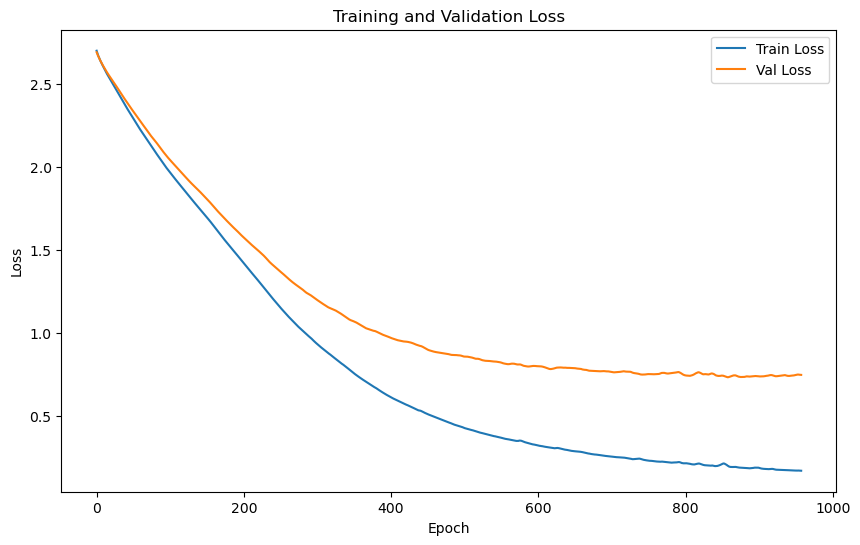

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.7711 | Test Accuracy: 71.36%


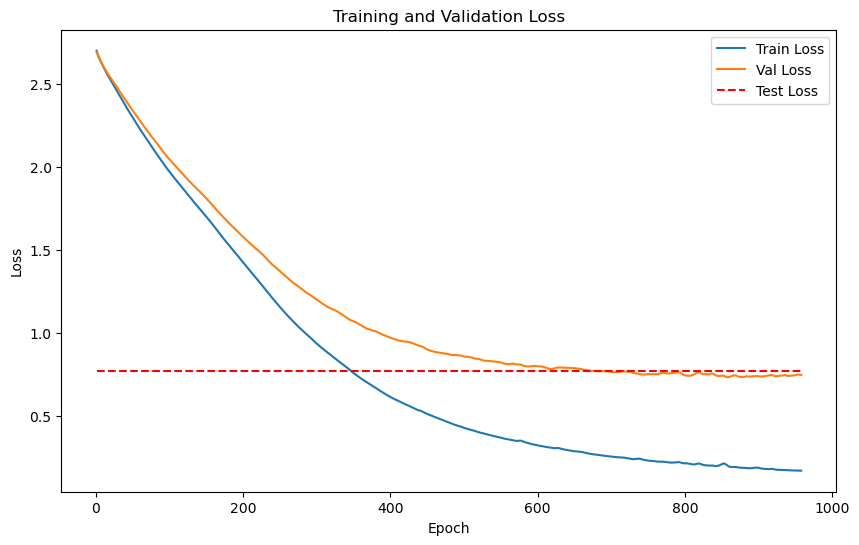

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3108 samples with 64 features each
LOG: Labels shape: (3108,)


Train embeddings shape: (70, 64), 
Train labels shape: (70,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (3108, 64), 
Test labels shape: (3108,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5}
Training batch size: 70


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.4548
    Batch [2/2], Val Loss: 0.2899
Epoch [1/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.3724

Validation loss improved from inf to 0.3724. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.4550
    Batch [2/2], Val Loss: 0.2931
Epoch [2/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.3740

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.4554
    Batch [2/2], Val Loss: 0.2957
Epoch [3/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.3756

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4862
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.4553
    Batch [2/2], Val Loss: 0.2989
Epoch [4/2000], Avg Train Loss: 0.4862, Avg Val Loss: 0.3771

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.4553
    Batch [2/2], Val Loss: 0.2992
Epoch [5/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.3773

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.4555
    Batch [2/2], Val Loss: 0.2974
Epoch [6/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.3765

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.4558
    Batch [2/2], Val Loss: 0.2963
Epoch [7/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.3761

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4869
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.4560
    Batch [2/2], Val Loss: 0.2980
Epoch [8/2000], Avg Train Loss: 0.4869, Avg Val Loss: 0.3770

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.2984
Epoch [9/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.3773

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.4572
    Batch [2/2], Val Loss: 0.3024
Epoch [10/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.3798

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.4583
    Batch [2/2], Val Loss: 0.3081
Epoch [11/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.3832

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.4593
    Batch [2/2], Val Loss: 0.3112
Epoch [12/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.3853

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4768
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.4598
    Batch [2/2], Val Loss: 0.3132
Epoch [13/2000], Avg Train Loss: 0.4768, Avg Val Loss: 0.3865

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4753
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.4604
    Batch [2/2], Val Loss: 0.3133
Epoch [14/2000], Avg Train Loss: 0.4753, Avg Val Loss: 0.3869

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4717
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.4610
    Batch [2/2], Val Loss: 0.3088
Epoch [15/2000], Avg Train Loss: 0.4717, Avg Val Loss: 0.3849

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4770
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.4614
    Batch [2/2], Val Loss: 0.3030
Epoch [16/2000], Avg Train Loss: 0.4770, Avg Val Loss: 0.3822

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4793
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.4622
    Batch [2/2], Val Loss: 0.2956
Epoch [17/2000], Avg Train Loss: 0.4793, Avg Val Loss: 0.3789

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.4630
    Batch [2/2], Val Loss: 0.2877
Epoch [18/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.3754

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4771
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.4645
    Batch [2/2], Val Loss: 0.2781
Epoch [19/2000], Avg Train Loss: 0.4771, Avg Val Loss: 0.3713

Validation loss improved from 0.3724 to 0.3713. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4783
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.4644
    Batch [2/2], Val Loss: 0.2675
Epoch [20/2000], Avg Train Loss: 0.4783, Avg Val Loss: 0.3660

Validation loss improved from 0.3713 to 0.3660. Saving model...
LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 0.4762
LOG: Epoch [21/2000] - Validation


    Batch [1/2], Val Loss: 0.4634
    Batch [2/2], Val Loss: 0.2554
Epoch [21/2000], Avg Train Loss: 0.4762, Avg Val Loss: 0.3594

Validation loss improved from 0.3660 to 0.3594. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 0.4749
LOG: Epoch [22/2000] - Validation


    Batch [1/2], Val Loss: 0.4627
    Batch [2/2], Val Loss: 0.2446
Epoch [22/2000], Avg Train Loss: 0.4749, Avg Val Loss: 0.3536

Validation loss improved from 0.3594 to 0.3536. Saving model...
LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [23/2000] - Validation


    Batch [1/2], Val Loss: 0.4626
    Batch [2/2], Val Loss: 0.2351
Epoch [23/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.3489

Validation loss improved from 0.3536 to 0.3489. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 0.4743
LOG: Epoch [24/2000] - Validation


    Batch [1/2], Val Loss: 0.4621
    Batch [2/2], Val Loss: 0.2266
Epoch [24/2000], Avg Train Loss: 0.4743, Avg Val Loss: 0.3444

Validation loss improved from 0.3489 to 0.3444. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 0.4738
LOG: Epoch [25/2000] - Validation


    Batch [1/2], Val Loss: 0.4613
    Batch [2/2], Val Loss: 0.2195
Epoch [25/2000], Avg Train Loss: 0.4738, Avg Val Loss: 0.3404

Validation loss improved from 0.3444 to 0.3404. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 0.4736
LOG: Epoch [26/2000] - Validation


    Batch [1/2], Val Loss: 0.4605
    Batch [2/2], Val Loss: 0.2138
Epoch [26/2000], Avg Train Loss: 0.4736, Avg Val Loss: 0.3371

Validation loss improved from 0.3404 to 0.3371. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 0.4768
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.4600


    Batch [2/2], Val Loss: 0.2079
Epoch [27/2000], Avg Train Loss: 0.4768, Avg Val Loss: 0.3339

Validation loss improved from 0.3371 to 0.3339. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [28/2000] - Validation


    Batch [1/2], Val Loss: 0.4596
    Batch [2/2], Val Loss: 0.2022
Epoch [28/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.3309

Validation loss improved from 0.3339 to 0.3309. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.4676
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.4591


    Batch [2/2], Val Loss: 0.1970
Epoch [29/2000], Avg Train Loss: 0.4676, Avg Val Loss: 0.3280

Validation loss improved from 0.3309 to 0.3280. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 0.4677
LOG: Epoch [30/2000] - Validation


    Batch [1/2], Val Loss: 0.4584
    Batch [2/2], Val Loss: 0.1934
Epoch [30/2000], Avg Train Loss: 0.4677, Avg Val Loss: 0.3259

Validation loss improved from 0.3280 to 0.3259. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 0.4705
LOG: Epoch [31/2000] - Validation


    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.1906
Epoch [31/2000], Avg Train Loss: 0.4705, Avg Val Loss: 0.3241

Validation loss improved from 0.3259 to 0.3241. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 0.4728
LOG: Epoch [32/2000] - Validation


    Batch [1/2], Val Loss: 0.4566
    Batch [2/2], Val Loss: 0.1879
Epoch [32/2000], Avg Train Loss: 0.4728, Avg Val Loss: 0.3222

Validation loss improved from 0.3241 to 0.3222. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 0.4716
LOG: Epoch [33/2000] - Validation


    Batch [1/2], Val Loss: 0.4557
    Batch [2/2], Val Loss: 0.1858
Epoch [33/2000], Avg Train Loss: 0.4716, Avg Val Loss: 0.3208

Validation loss improved from 0.3222 to 0.3208. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 0.4702
LOG: Epoch [34/2000] - Validation


    Batch [1/2], Val Loss: 0.4549
    Batch [2/2], Val Loss: 0.1849
Epoch [34/2000], Avg Train Loss: 0.4702, Avg Val Loss: 0.3199

Validation loss improved from 0.3208 to 0.3199. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 0.4611
LOG: Epoch [35/2000] - Validation


    Batch [1/2], Val Loss: 0.4541
    Batch [2/2], Val Loss: 0.1846
Epoch [35/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.3194

Validation loss improved from 0.3199 to 0.3194. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 0.4702
LOG: Epoch [36/2000] - Validation


    Batch [1/2], Val Loss: 0.4534
    Batch [2/2], Val Loss: 0.1842
Epoch [36/2000], Avg Train Loss: 0.4702, Avg Val Loss: 0.3188

Validation loss improved from 0.3194 to 0.3188. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4696
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.4527
    Batch [2/2], Val Loss: 0.1839
Epoch [37/2000], Avg Train Loss: 0.4696, Avg Val Loss: 0.3183

Validation loss improved from 0.3188 to 0.3183. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4572
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.4520
    Batch [2/2], Val Loss: 0.1837
Epoch [38/2000], Avg Train Loss: 0.4572, Avg Val Loss: 0.3179

Validation loss improved from 0.3183 to 0.3179. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4615
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.4513
    Batch [2/2], Val Loss: 0.1836
Epoch [39/2000], Avg Train Loss: 0.4615, Avg Val Loss: 0.3174

Validation loss improved from 0.3179 to 0.3174. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4620
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.4504
    Batch [2/2], Val Loss: 0.1834
Epoch [40/2000], Avg Train Loss: 0.4620, Avg Val Loss: 0.3169

Validation loss improved from 0.3174 to 0.3169. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4592
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.4494
    Batch [2/2], Val Loss: 0.1833
Epoch [41/2000], Avg Train Loss: 0.4592, Avg Val Loss: 0.3164

Validation loss improved from 0.3169 to 0.3164. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4623
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.4484
    Batch [2/2], Val Loss: 0.1832
Epoch [42/2000], Avg Train Loss: 0.4623, Avg Val Loss: 0.3158

Validation loss improved from 0.3164 to 0.3158. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4571
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.4475
    Batch [2/2], Val Loss: 0.1828
Epoch [43/2000], Avg Train Loss: 0.4571, Avg Val Loss: 0.3151

Validation loss improved from 0.3158 to 0.3151. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4555
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.4466
    Batch [2/2], Val Loss: 0.1826
Epoch [44/2000], Avg Train Loss: 0.4555, Avg Val Loss: 0.3146

Validation loss improved from 0.3151 to 0.3146. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4603
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.4459
    Batch [2/2], Val Loss: 0.1825
Epoch [45/2000], Avg Train Loss: 0.4603, Avg Val Loss: 0.3142

Validation loss improved from 0.3146 to 0.3142. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4641
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.4454
    Batch [2/2], Val Loss: 0.1823
Epoch [46/2000], Avg Train Loss: 0.4641, Avg Val Loss: 0.3139

Validation loss improved from 0.3142 to 0.3139. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4554
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.4450
    Batch [2/2], Val Loss: 0.1824
Epoch [47/2000], Avg Train Loss: 0.4554, Avg Val Loss: 0.3137

Validation loss improved from 0.3139 to 0.3137. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4561
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.4445
    Batch [2/2], Val Loss: 0.1824
Epoch [48/2000], Avg Train Loss: 0.4561, Avg Val Loss: 0.3135

Validation loss improved from 0.3137 to 0.3135. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4537
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.4442
    Batch [2/2], Val Loss: 0.1824
Epoch [49/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.3133

Validation loss improved from 0.3135 to 0.3133. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4624
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.4441
    Batch [2/2], Val Loss: 0.1823
Epoch [50/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.3132

Validation loss improved from 0.3133 to 0.3132. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 0.4576
LOG: Epoch [51/2000] - Validation


    Batch [1/2], Val Loss: 0.4440
    Batch [2/2], Val Loss: 0.1823
Epoch [51/2000], Avg Train Loss: 0.4576, Avg Val Loss: 0.3131

Validation loss improved from 0.3132 to 0.3131. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 0.4513
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.4440
    Batch [2/2], Val Loss: 0.1823
Epoch [52/2000], Avg Train Loss: 0.4513, Avg Val Loss: 0.3131

Validation loss improved from 0.3131 to 0.3131. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4554
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.4439
    Batch [2/2], Val Loss: 0.1824
Epoch [53/2000], Avg Train Loss: 0.4554, Avg Val Loss: 0.3132

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4512
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.4439
    Batch [2/2], Val Loss: 0.1826
Epoch [54/2000], Avg Train Loss: 0.4512, Avg Val Loss: 0.3133

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4594
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.4438
    Batch [2/2], Val Loss: 0.1827
Epoch [55/2000], Avg Train Loss: 0.4594, Avg Val Loss: 0.3132

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4416
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.4436
    Batch [2/2], Val Loss: 0.1825
Epoch [56/2000], Avg Train Loss: 0.4416, Avg Val Loss: 0.3131

Validation loss improved from 0.3131 to 0.3131. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4551
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.4432
    Batch [2/2], Val Loss: 0.1826
Epoch [57/2000], Avg Train Loss: 0.4551, Avg Val Loss: 0.3129

Validation loss improved from 0.3131 to 0.3129. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4503
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.4430
    Batch [2/2], Val Loss: 0.1829
Epoch [58/2000], Avg Train Loss: 0.4503, Avg Val Loss: 0.3130

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4529
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.4429
    Batch [2/2], Val Loss: 0.1832
Epoch [59/2000], Avg Train Loss: 0.4529, Avg Val Loss: 0.3131

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4437
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.4429
    Batch [2/2], Val Loss: 0.1834
Epoch [60/2000], Avg Train Loss: 0.4437, Avg Val Loss: 0.3132

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.4429
    Batch [2/2], Val Loss: 0.1838
Epoch [61/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.3134

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4399
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.4426
    Batch [2/2], Val Loss: 0.1846
Epoch [62/2000], Avg Train Loss: 0.4399, Avg Val Loss: 0.3136

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4452
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.4422
    Batch [2/2], Val Loss: 0.1854
Epoch [63/2000], Avg Train Loss: 0.4452, Avg Val Loss: 0.3138

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4411
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.4418
    Batch [2/2], Val Loss: 0.1862
Epoch [64/2000], Avg Train Loss: 0.4411, Avg Val Loss: 0.3140

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4493
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.4413
    Batch [2/2], Val Loss: 0.1865
Epoch [65/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4430
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.4405
    Batch [2/2], Val Loss: 0.1868
Epoch [66/2000], Avg Train Loss: 0.4430, Avg Val Loss: 0.3137

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4494
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.4397
    Batch [2/2], Val Loss: 0.1869
Epoch [67/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.3133

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4415
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.4392
    Batch [2/2], Val Loss: 0.1867
Epoch [68/2000], Avg Train Loss: 0.4415, Avg Val Loss: 0.3130

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4422
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.4386
    Batch [2/2], Val Loss: 0.1865
Epoch [69/2000], Avg Train Loss: 0.4422, Avg Val Loss: 0.3126

Validation loss improved from 0.3129 to 0.3126. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4445
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.4380
    Batch [2/2], Val Loss: 0.1865
Epoch [70/2000], Avg Train Loss: 0.4445, Avg Val Loss: 0.3122

Validation loss improved from 0.3126 to 0.3122. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4455
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.4374
    Batch [2/2], Val Loss: 0.1866
Epoch [71/2000], Avg Train Loss: 0.4455, Avg Val Loss: 0.3120

Validation loss improved from 0.3122 to 0.3120. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4355
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.4371
    Batch [2/2], Val Loss: 0.1872
Epoch [72/2000], Avg Train Loss: 0.4355, Avg Val Loss: 0.3121

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4387
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.4367
    Batch [2/2], Val Loss: 0.1879
Epoch [73/2000], Avg Train Loss: 0.4387, Avg Val Loss: 0.3123

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4390
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.4365
    Batch [2/2], Val Loss: 0.1885
Epoch [74/2000], Avg Train Loss: 0.4390, Avg Val Loss: 0.3125

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4420
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.4362
    Batch [2/2], Val Loss: 0.1884
Epoch [75/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.3123

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4329
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.4360
    Batch [2/2], Val Loss: 0.1885
Epoch [76/2000], Avg Train Loss: 0.4329, Avg Val Loss: 0.3123

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4371
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.4360
    Batch [2/2], Val Loss: 0.1885
Epoch [77/2000], Avg Train Loss: 0.4371, Avg Val Loss: 0.3123

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4400
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.4361
    Batch [2/2], Val Loss: 0.1887
Epoch [78/2000], Avg Train Loss: 0.4400, Avg Val Loss: 0.3124

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 0.4329
LOG: Epoch [79/2000] - Validation


    Batch [1/2], Val Loss: 0.4363
    Batch [2/2], Val Loss: 0.1890
Epoch [79/2000], Avg Train Loss: 0.4329, Avg Val Loss: 0.3127

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 0.4350
LOG: Epoch [80/2000] - Validation


    Batch [1/2], Val Loss: 0.4364
    Batch [2/2], Val Loss: 0.1892
Epoch [80/2000], Avg Train Loss: 0.4350, Avg Val Loss: 0.3128

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 0.4324
LOG: Epoch [81/2000] - Validation


    Batch [1/2], Val Loss: 0.4361
    Batch [2/2], Val Loss: 0.1893
Epoch [81/2000], Avg Train Loss: 0.4324, Avg Val Loss: 0.3127

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 0.4321
LOG: Epoch [82/2000] - Validation


    Batch [1/2], Val Loss: 0.4358
    Batch [2/2], Val Loss: 0.1894
Epoch [82/2000], Avg Train Loss: 0.4321, Avg Val Loss: 0.3126

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 0.4334
LOG: Epoch [83/2000] - Validation


    Batch [1/2], Val Loss: 0.4356
    Batch [2/2], Val Loss: 0.1894
Epoch [83/2000], Avg Train Loss: 0.4334, Avg Val Loss: 0.3125

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 0.4347
LOG: Epoch [84/2000] - Validation


    Batch [1/2], Val Loss: 0.4355
    Batch [2/2], Val Loss: 0.1896
Epoch [84/2000], Avg Train Loss: 0.4347, Avg Val Loss: 0.3125

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.4363
LOG: Epoch [85/2000] - Validation


    Batch [1/2], Val Loss: 0.4355
    Batch [2/2], Val Loss: 0.1896
Epoch [85/2000], Avg Train Loss: 0.4363, Avg Val Loss: 0.3126

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 0.4277
LOG: Epoch [86/2000] - Validation


    Batch [1/2], Val Loss: 0.4353
    Batch [2/2], Val Loss: 0.1896
Epoch [86/2000], Avg Train Loss: 0.4277, Avg Val Loss: 0.3125

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 0.4198
LOG: Epoch [87/2000] - Validation


    Batch [1/2], Val Loss: 0.4352
    Batch [2/2], Val Loss: 0.1896
Epoch [87/2000], Avg Train Loss: 0.4198, Avg Val Loss: 0.3124

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 0.4327
LOG: Epoch [88/2000] - Validation


    Batch [1/2], Val Loss: 0.4352
    Batch [2/2], Val Loss: 0.1892
Epoch [88/2000], Avg Train Loss: 0.4327, Avg Val Loss: 0.3122

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 0.4304
LOG: Epoch [89/2000] - Validation


    Batch [1/2], Val Loss: 0.4349
    Batch [2/2], Val Loss: 0.1890
Epoch [89/2000], Avg Train Loss: 0.4304, Avg Val Loss: 0.3120

Validation loss improved from 0.3120 to 0.3120. Saving model...
LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 0.4256
LOG: Epoch [90/2000] - Validation


    Batch [1/2], Val Loss: 0.4346
    Batch [2/2], Val Loss: 0.1891
Epoch [90/2000], Avg Train Loss: 0.4256, Avg Val Loss: 0.3119

Validation loss improved from 0.3120 to 0.3119. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 0.4221
LOG: Epoch [91/2000] - Validation


    Batch [1/2], Val Loss: 0.4342
    Batch [2/2], Val Loss: 0.1895
Epoch [91/2000], Avg Train Loss: 0.4221, Avg Val Loss: 0.3118

Validation loss improved from 0.3119 to 0.3118. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 0.4203
LOG: Epoch [92/2000] - Validation


    Batch [1/2], Val Loss: 0.4340
    Batch [2/2], Val Loss: 0.1895
Epoch [92/2000], Avg Train Loss: 0.4203, Avg Val Loss: 0.3118

Validation loss improved from 0.3118 to 0.3118. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 0.4238
LOG: Epoch [93/2000] - Validation


    Batch [1/2], Val Loss: 0.4336
    Batch [2/2], Val Loss: 0.1893
Epoch [93/2000], Avg Train Loss: 0.4238, Avg Val Loss: 0.3114

Validation loss improved from 0.3118 to 0.3114. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 0.4230
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.4333
    Batch [2/2], Val Loss: 0.1890
Epoch [94/2000], Avg Train Loss: 0.4230, Avg Val Loss: 0.3111

Validation loss improved from 0.3114 to 0.3111. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4212
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.4328
    Batch [2/2], Val Loss: 0.1890
Epoch [95/2000], Avg Train Loss: 0.4212, Avg Val Loss: 0.3109

Validation loss improved from 0.3111 to 0.3109. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4261
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.4324
    Batch [2/2], Val Loss: 0.1884
Epoch [96/2000], Avg Train Loss: 0.4261, Avg Val Loss: 0.3104

Validation loss improved from 0.3109 to 0.3104. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4297
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.4319
    Batch [2/2], Val Loss: 0.1877
Epoch [97/2000], Avg Train Loss: 0.4297, Avg Val Loss: 0.3098

Validation loss improved from 0.3104 to 0.3098. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4293
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.4316
    Batch [2/2], Val Loss: 0.1865
Epoch [98/2000], Avg Train Loss: 0.4293, Avg Val Loss: 0.3090

Validation loss improved from 0.3098 to 0.3090. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4152
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.4314
    Batch [2/2], Val Loss: 0.1854
Epoch [99/2000], Avg Train Loss: 0.4152, Avg Val Loss: 0.3084

Validation loss improved from 0.3090 to 0.3084. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4204
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.4312
    Batch [2/2], Val Loss: 0.1847
Epoch [100/2000], Avg Train Loss: 0.4204, Avg Val Loss: 0.3080

Validation loss improved from 0.3084 to 0.3080. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4194
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.4311
    Batch [2/2], Val Loss: 0.1837
Epoch [101/2000], Avg Train Loss: 0.4194, Avg Val Loss: 0.3074

Validation loss improved from 0.3080 to 0.3074. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4179
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.4307
    Batch [2/2], Val Loss: 0.1828
Epoch [102/2000], Avg Train Loss: 0.4179, Avg Val Loss: 0.3068

Validation loss improved from 0.3074 to 0.3068. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4132
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.4305
    Batch [2/2], Val Loss: 0.1823
Epoch [103/2000], Avg Train Loss: 0.4132, Avg Val Loss: 0.3064

Validation loss improved from 0.3068 to 0.3064. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4210
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.4302
    Batch [2/2], Val Loss: 0.1815
Epoch [104/2000], Avg Train Loss: 0.4210, Avg Val Loss: 0.3058

Validation loss improved from 0.3064 to 0.3058. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.4144
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.4301
    Batch [2/2], Val Loss: 0.1803
Epoch [105/2000], Avg Train Loss: 0.4144, Avg Val Loss: 0.3052

Validation loss improved from 0.3058 to 0.3052. Saving model...
LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 0.4210
LOG: Epoch [106/2000] - Validation


    Batch [1/2], Val Loss: 0.4302
    Batch [2/2], Val Loss: 0.1788
Epoch [106/2000], Avg Train Loss: 0.4210, Avg Val Loss: 0.3045

Validation loss improved from 0.3052 to 0.3045. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 0.4116
LOG: Epoch [107/2000] - Validation


    Batch [1/2], Val Loss: 0.4303
    Batch [2/2], Val Loss: 0.1772
Epoch [107/2000], Avg Train Loss: 0.4116, Avg Val Loss: 0.3038

Validation loss improved from 0.3045 to 0.3038. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.4200
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.4304
    Batch [2/2], Val Loss: 0.1755
Epoch [108/2000], Avg Train Loss: 0.4200, Avg Val Loss: 0.3030

Validation loss improved from 0.3038 to 0.3030. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.4139
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.4301
    Batch [2/2], Val Loss: 0.1740
Epoch [109/2000], Avg Train Loss: 0.4139, Avg Val Loss: 0.3021

Validation loss improved from 0.3030 to 0.3021. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.4186
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.4300
    Batch [2/2], Val Loss: 0.1729
Epoch [110/2000], Avg Train Loss: 0.4186, Avg Val Loss: 0.3014

Validation loss improved from 0.3021 to 0.3014. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.4173
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.4298
    Batch [2/2], Val Loss: 0.1714
Epoch [111/2000], Avg Train Loss: 0.4173, Avg Val Loss: 0.3006

Validation loss improved from 0.3014 to 0.3006. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.4124
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.4298
    Batch [2/2], Val Loss: 0.1704
Epoch [112/2000], Avg Train Loss: 0.4124, Avg Val Loss: 0.3001

Validation loss improved from 0.3006 to 0.3001. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.4166
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.4296
    Batch [2/2], Val Loss: 0.1697
Epoch [113/2000], Avg Train Loss: 0.4166, Avg Val Loss: 0.2996

Validation loss improved from 0.3001 to 0.2996. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.4092
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.4292
    Batch [2/2], Val Loss: 0.1692
Epoch [114/2000], Avg Train Loss: 0.4092, Avg Val Loss: 0.2992

Validation loss improved from 0.2996 to 0.2992. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.4283
    Batch [2/2], Val Loss: 0.1690
Epoch [115/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.2987

Validation loss improved from 0.2992 to 0.2987. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.4191
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.4275
    Batch [2/2], Val Loss: 0.1687
Epoch [116/2000], Avg Train Loss: 0.4191, Avg Val Loss: 0.2981

Validation loss improved from 0.2987 to 0.2981. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.4049
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.4267
    Batch [2/2], Val Loss: 0.1683
Epoch [117/2000], Avg Train Loss: 0.4049, Avg Val Loss: 0.2975

Validation loss improved from 0.2981 to 0.2975. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.4051
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.4258
    Batch [2/2], Val Loss: 0.1678
Epoch [118/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.2968

Validation loss improved from 0.2975 to 0.2968. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.4125
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.4249
    Batch [2/2], Val Loss: 0.1674
Epoch [119/2000], Avg Train Loss: 0.4125, Avg Val Loss: 0.2961

Validation loss improved from 0.2968 to 0.2961. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.4119
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1672
Epoch [120/2000], Avg Train Loss: 0.4119, Avg Val Loss: 0.2957

Validation loss improved from 0.2961 to 0.2957. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.4035
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.4240
    Batch [2/2], Val Loss: 0.1673
Epoch [121/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.2957

Validation loss improved from 0.2957 to 0.2957. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.4238
    Batch [2/2], Val Loss: 0.1672
Epoch [122/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.2955

Validation loss improved from 0.2957 to 0.2955. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.4102
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.4238
    Batch [2/2], Val Loss: 0.1668
Epoch [123/2000], Avg Train Loss: 0.4102, Avg Val Loss: 0.2953

Validation loss improved from 0.2955 to 0.2953. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.4067
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.4238
    Batch [2/2], Val Loss: 0.1667
Epoch [124/2000], Avg Train Loss: 0.4067, Avg Val Loss: 0.2953

Validation loss improved from 0.2953 to 0.2953. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.4084
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.4235
    Batch [2/2], Val Loss: 0.1671
Epoch [125/2000], Avg Train Loss: 0.4084, Avg Val Loss: 0.2953

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1677
Epoch [126/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.2955

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.4118
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.4232
    Batch [2/2], Val Loss: 0.1681
Epoch [127/2000], Avg Train Loss: 0.4118, Avg Val Loss: 0.2956

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.4230
    Batch [2/2], Val Loss: 0.1690
Epoch [128/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.2960

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.4228
    Batch [2/2], Val Loss: 0.1694
Epoch [129/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2961

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.4057
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.4225
    Batch [2/2], Val Loss: 0.1693
Epoch [130/2000], Avg Train Loss: 0.4057, Avg Val Loss: 0.2959

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.4072
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.4222
    Batch [2/2], Val Loss: 0.1692
Epoch [131/2000], Avg Train Loss: 0.4072, Avg Val Loss: 0.2957

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.4004
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.4220
    Batch [2/2], Val Loss: 0.1689
Epoch [132/2000], Avg Train Loss: 0.4004, Avg Val Loss: 0.2954

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.4219
    Batch [2/2], Val Loss: 0.1691
Epoch [133/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.2955

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.3958
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.4217
    Batch [2/2], Val Loss: 0.1691
Epoch [134/2000], Avg Train Loss: 0.3958, Avg Val Loss: 0.2954

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.4012
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.4218
    Batch [2/2], Val Loss: 0.1688
Epoch [135/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.2953

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.4217
    Batch [2/2], Val Loss: 0.1684
Epoch [136/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.2951

Validation loss improved from 0.2953 to 0.2951. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.4056
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.4222
    Batch [2/2], Val Loss: 0.1678
Epoch [137/2000], Avg Train Loss: 0.4056, Avg Val Loss: 0.2950

Validation loss improved from 0.2951 to 0.2950. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.4224
    Batch [2/2], Val Loss: 0.1671
Epoch [138/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.2947

Validation loss improved from 0.2950 to 0.2947. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.4002
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.4224
    Batch [2/2], Val Loss: 0.1663
Epoch [139/2000], Avg Train Loss: 0.4002, Avg Val Loss: 0.2943

Validation loss improved from 0.2947 to 0.2943. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.4225
    Batch [2/2], Val Loss: 0.1649
Epoch [140/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.2937

Validation loss improved from 0.2943 to 0.2937. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.4008
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.4224
    Batch [2/2], Val Loss: 0.1636
Epoch [141/2000], Avg Train Loss: 0.4008, Avg Val Loss: 0.2930

Validation loss improved from 0.2937 to 0.2930. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.4223
    Batch [2/2], Val Loss: 0.1626
Epoch [142/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.2925

Validation loss improved from 0.2930 to 0.2925. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.3970
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.4224
    Batch [2/2], Val Loss: 0.1617
Epoch [143/2000], Avg Train Loss: 0.3970, Avg Val Loss: 0.2921

Validation loss improved from 0.2925 to 0.2921. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.3955
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.4223
    Batch [2/2], Val Loss: 0.1609
Epoch [144/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.2916

Validation loss improved from 0.2921 to 0.2916. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.3974
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.4224
    Batch [2/2], Val Loss: 0.1602
Epoch [145/2000], Avg Train Loss: 0.3974, Avg Val Loss: 0.2913

Validation loss improved from 0.2916 to 0.2913. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.3858
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.4227
    Batch [2/2], Val Loss: 0.1597
Epoch [146/2000], Avg Train Loss: 0.3858, Avg Val Loss: 0.2912

Validation loss improved from 0.2913 to 0.2912. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.4234
    Batch [2/2], Val Loss: 0.1587
Epoch [147/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.2911

Validation loss improved from 0.2912 to 0.2911. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.3857
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.4239
    Batch [2/2], Val Loss: 0.1581
Epoch [148/2000], Avg Train Loss: 0.3857, Avg Val Loss: 0.2910

Validation loss improved from 0.2911 to 0.2910. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.3810
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.4242
    Batch [2/2], Val Loss: 0.1574
Epoch [149/2000], Avg Train Loss: 0.3810, Avg Val Loss: 0.2908

Validation loss improved from 0.2910 to 0.2908. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.3857
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.4245
    Batch [2/2], Val Loss: 0.1564
Epoch [150/2000], Avg Train Loss: 0.3857, Avg Val Loss: 0.2904

Validation loss improved from 0.2908 to 0.2904. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.3959
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.4246
    Batch [2/2], Val Loss: 0.1551
Epoch [151/2000], Avg Train Loss: 0.3959, Avg Val Loss: 0.2899

Validation loss improved from 0.2904 to 0.2899. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.3835
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.4245
    Batch [2/2], Val Loss: 0.1545
Epoch [152/2000], Avg Train Loss: 0.3835, Avg Val Loss: 0.2895

Validation loss improved from 0.2899 to 0.2895. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.4240
    Batch [2/2], Val Loss: 0.1539
Epoch [153/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.2889

Validation loss improved from 0.2895 to 0.2889. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.4239
    Batch [2/2], Val Loss: 0.1533
Epoch [154/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.2886

Validation loss improved from 0.2889 to 0.2886. Saving model...
LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 0.3786
LOG: Epoch [155/2000] - Validation


    Batch [1/2], Val Loss: 0.4241
    Batch [2/2], Val Loss: 0.1532
Epoch [155/2000], Avg Train Loss: 0.3786, Avg Val Loss: 0.2887

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [156/2000] - Validation


    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1529
Epoch [156/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 0.3809
LOG: Epoch [157/2000] - Validation


    Batch [1/2], Val Loss: 0.4246
    Batch [2/2], Val Loss: 0.1528
Epoch [157/2000], Avg Train Loss: 0.3809, Avg Val Loss: 0.2887

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.3954
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.4253
    Batch [2/2], Val Loss: 0.1526
Epoch [158/2000], Avg Train Loss: 0.3954, Avg Val Loss: 0.2890

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.3881
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.4257
    Batch [2/2], Val Loss: 0.1521
Epoch [159/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.2889

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.4261
    Batch [2/2], Val Loss: 0.1518
Epoch [160/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.2890

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.3829
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.4259
    Batch [2/2], Val Loss: 0.1514
Epoch [161/2000], Avg Train Loss: 0.3829, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.3777
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.4259
    Batch [2/2], Val Loss: 0.1510
Epoch [162/2000], Avg Train Loss: 0.3777, Avg Val Loss: 0.2884

Validation loss improved from 0.2886 to 0.2884. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.4257
    Batch [2/2], Val Loss: 0.1507
Epoch [163/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.2882

Validation loss improved from 0.2884 to 0.2882. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.3789
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.4253
    Batch [2/2], Val Loss: 0.1513
Epoch [164/2000], Avg Train Loss: 0.3789, Avg Val Loss: 0.2883

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.3770
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.4251
    Batch [2/2], Val Loss: 0.1515
Epoch [165/2000], Avg Train Loss: 0.3770, Avg Val Loss: 0.2883

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.3822
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.4247
    Batch [2/2], Val Loss: 0.1516
Epoch [166/2000], Avg Train Loss: 0.3822, Avg Val Loss: 0.2882

Validation loss improved from 0.2882 to 0.2882. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.3827
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.4252
    Batch [2/2], Val Loss: 0.1516
Epoch [167/2000], Avg Train Loss: 0.3827, Avg Val Loss: 0.2884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.4252
    Batch [2/2], Val Loss: 0.1517
Epoch [168/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.2884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.4249
    Batch [2/2], Val Loss: 0.1512
Epoch [169/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.2881

Validation loss improved from 0.2882 to 0.2881. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.3702
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.4246
    Batch [2/2], Val Loss: 0.1511
Epoch [170/2000], Avg Train Loss: 0.3702, Avg Val Loss: 0.2878

Validation loss improved from 0.2881 to 0.2878. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.3880
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.4241
    Batch [2/2], Val Loss: 0.1510
Epoch [171/2000], Avg Train Loss: 0.3880, Avg Val Loss: 0.2875

Validation loss improved from 0.2878 to 0.2875. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.3746
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.4238
    Batch [2/2], Val Loss: 0.1508
Epoch [172/2000], Avg Train Loss: 0.3746, Avg Val Loss: 0.2873

Validation loss improved from 0.2875 to 0.2873. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.3704
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1507
Epoch [173/2000], Avg Train Loss: 0.3704, Avg Val Loss: 0.2870

Validation loss improved from 0.2873 to 0.2870. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.3746
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.4234
    Batch [2/2], Val Loss: 0.1508
Epoch [174/2000], Avg Train Loss: 0.3746, Avg Val Loss: 0.2871

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.3794
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.4236
    Batch [2/2], Val Loss: 0.1504
Epoch [175/2000], Avg Train Loss: 0.3794, Avg Val Loss: 0.2870

Validation loss improved from 0.2870 to 0.2870. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 0.3805
LOG: Epoch [176/2000] - Validation


    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1499
Epoch [176/2000], Avg Train Loss: 0.3805, Avg Val Loss: 0.2871

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.3761
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.4242
    Batch [2/2], Val Loss: 0.1494
Epoch [177/2000], Avg Train Loss: 0.3761, Avg Val Loss: 0.2868

Validation loss improved from 0.2870 to 0.2868. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.3772
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.4237
    Batch [2/2], Val Loss: 0.1490
Epoch [178/2000], Avg Train Loss: 0.3772, Avg Val Loss: 0.2864

Validation loss improved from 0.2868 to 0.2864. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.3744
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.4230
    Batch [2/2], Val Loss: 0.1485
Epoch [179/2000], Avg Train Loss: 0.3744, Avg Val Loss: 0.2858

Validation loss improved from 0.2864 to 0.2858. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.3727
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.4223
    Batch [2/2], Val Loss: 0.1478
Epoch [180/2000], Avg Train Loss: 0.3727, Avg Val Loss: 0.2851

Validation loss improved from 0.2858 to 0.2851. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.3708
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.4211
    Batch [2/2], Val Loss: 0.1473
Epoch [181/2000], Avg Train Loss: 0.3708, Avg Val Loss: 0.2842

Validation loss improved from 0.2851 to 0.2842. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.3668
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.1474
Epoch [182/2000], Avg Train Loss: 0.3668, Avg Val Loss: 0.2837

Validation loss improved from 0.2842 to 0.2837. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.3762
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.4187
    Batch [2/2], Val Loss: 0.1473
Epoch [183/2000], Avg Train Loss: 0.3762, Avg Val Loss: 0.2830

Validation loss improved from 0.2837 to 0.2830. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.3698
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.4180
    Batch [2/2], Val Loss: 0.1473
Epoch [184/2000], Avg Train Loss: 0.3698, Avg Val Loss: 0.2827

Validation loss improved from 0.2830 to 0.2827. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.3701
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.4172
    Batch [2/2], Val Loss: 0.1472
Epoch [185/2000], Avg Train Loss: 0.3701, Avg Val Loss: 0.2822

Validation loss improved from 0.2827 to 0.2822. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.3740
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.4161
    Batch [2/2], Val Loss: 0.1472
Epoch [186/2000], Avg Train Loss: 0.3740, Avg Val Loss: 0.2816

Validation loss improved from 0.2822 to 0.2816. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.3727
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.4152
    Batch [2/2], Val Loss: 0.1475
Epoch [187/2000], Avg Train Loss: 0.3727, Avg Val Loss: 0.2814

Validation loss improved from 0.2816 to 0.2814. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.3722
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.4147
    Batch [2/2], Val Loss: 0.1474
Epoch [188/2000], Avg Train Loss: 0.3722, Avg Val Loss: 0.2810

Validation loss improved from 0.2814 to 0.2810. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.3848
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.4142
    Batch [2/2], Val Loss: 0.1474
Epoch [189/2000], Avg Train Loss: 0.3848, Avg Val Loss: 0.2808

Validation loss improved from 0.2810 to 0.2808. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.3672
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.4133
    Batch [2/2], Val Loss: 0.1473
Epoch [190/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.2803

Validation loss improved from 0.2808 to 0.2803. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.3741
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.4126
    Batch [2/2], Val Loss: 0.1473
Epoch [191/2000], Avg Train Loss: 0.3741, Avg Val Loss: 0.2799

Validation loss improved from 0.2803 to 0.2799. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.3601
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.4119
    Batch [2/2], Val Loss: 0.1476
Epoch [192/2000], Avg Train Loss: 0.3601, Avg Val Loss: 0.2797

Validation loss improved from 0.2799 to 0.2797. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.3676
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.4110
    Batch [2/2], Val Loss: 0.1482
Epoch [193/2000], Avg Train Loss: 0.3676, Avg Val Loss: 0.2796

Validation loss improved from 0.2797 to 0.2796. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.3669
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.4106
    Batch [2/2], Val Loss: 0.1486
Epoch [194/2000], Avg Train Loss: 0.3669, Avg Val Loss: 0.2796

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.3625
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.4104
    Batch [2/2], Val Loss: 0.1490
Epoch [195/2000], Avg Train Loss: 0.3625, Avg Val Loss: 0.2797

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.3663
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.4107
    Batch [2/2], Val Loss: 0.1490
Epoch [196/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.2798

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.3552
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1488
Epoch [197/2000], Avg Train Loss: 0.3552, Avg Val Loss: 0.2800

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.3671
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.4118
    Batch [2/2], Val Loss: 0.1480
Epoch [198/2000], Avg Train Loss: 0.3671, Avg Val Loss: 0.2799

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.3598
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.4127
    Batch [2/2], Val Loss: 0.1476
Epoch [199/2000], Avg Train Loss: 0.3598, Avg Val Loss: 0.2801

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.3634
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.4135
    Batch [2/2], Val Loss: 0.1470
Epoch [200/2000], Avg Train Loss: 0.3634, Avg Val Loss: 0.2803

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.3566
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.4143
    Batch [2/2], Val Loss: 0.1464
Epoch [201/2000], Avg Train Loss: 0.3566, Avg Val Loss: 0.2803

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.3574
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.4152
    Batch [2/2], Val Loss: 0.1446
Epoch [202/2000], Avg Train Loss: 0.3574, Avg Val Loss: 0.2799

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.3679
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.4157
    Batch [2/2], Val Loss: 0.1426
Epoch [203/2000], Avg Train Loss: 0.3679, Avg Val Loss: 0.2792

Validation loss improved from 0.2796 to 0.2792. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.3538
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.1412
Epoch [204/2000], Avg Train Loss: 0.3538, Avg Val Loss: 0.2786

Validation loss improved from 0.2792 to 0.2786. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.3526
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.4162
    Batch [2/2], Val Loss: 0.1403
Epoch [205/2000], Avg Train Loss: 0.3526, Avg Val Loss: 0.2782

Validation loss improved from 0.2786 to 0.2782. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.3556
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.4161
    Batch [2/2], Val Loss: 0.1391
Epoch [206/2000], Avg Train Loss: 0.3556, Avg Val Loss: 0.2776

Validation loss improved from 0.2782 to 0.2776. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.3663
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.1385
Epoch [207/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.2773

Validation loss improved from 0.2776 to 0.2773. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.3566
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.1381
Epoch [208/2000], Avg Train Loss: 0.3566, Avg Val Loss: 0.2770

Validation loss improved from 0.2773 to 0.2770. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.3490
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.4155
    Batch [2/2], Val Loss: 0.1376
Epoch [209/2000], Avg Train Loss: 0.3490, Avg Val Loss: 0.2766

Validation loss improved from 0.2770 to 0.2766. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.3626
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.4155
    Batch [2/2], Val Loss: 0.1371
Epoch [210/2000], Avg Train Loss: 0.3626, Avg Val Loss: 0.2763

Validation loss improved from 0.2766 to 0.2763. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.3548
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.4147
    Batch [2/2], Val Loss: 0.1362
Epoch [211/2000], Avg Train Loss: 0.3548, Avg Val Loss: 0.2754

Validation loss improved from 0.2763 to 0.2754. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.3563
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.4139
    Batch [2/2], Val Loss: 0.1352
Epoch [212/2000], Avg Train Loss: 0.3563, Avg Val Loss: 0.2746

Validation loss improved from 0.2754 to 0.2746. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.4134
    Batch [2/2], Val Loss: 0.1349
Epoch [213/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.2741

Validation loss improved from 0.2746 to 0.2741. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.3524
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.4135
    Batch [2/2], Val Loss: 0.1356
Epoch [214/2000], Avg Train Loss: 0.3524, Avg Val Loss: 0.2745

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.3481
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.4135
    Batch [2/2], Val Loss: 0.1359
Epoch [215/2000], Avg Train Loss: 0.3481, Avg Val Loss: 0.2747

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.3558
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.4137
    Batch [2/2], Val Loss: 0.1361
Epoch [216/2000], Avg Train Loss: 0.3558, Avg Val Loss: 0.2749

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.3551
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.4140
    Batch [2/2], Val Loss: 0.1368
Epoch [217/2000], Avg Train Loss: 0.3551, Avg Val Loss: 0.2754

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.4137
    Batch [2/2], Val Loss: 0.1373
Epoch [218/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.2755

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.3540
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.4132
    Batch [2/2], Val Loss: 0.1376
Epoch [219/2000], Avg Train Loss: 0.3540, Avg Val Loss: 0.2754

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 0.3436
LOG: Epoch [220/2000] - Validation


    Batch [1/2], Val Loss: 0.4129
    Batch [2/2], Val Loss: 0.1372
Epoch [220/2000], Avg Train Loss: 0.3436, Avg Val Loss: 0.2751

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 0.3403
LOG: Epoch [221/2000] - Validation


    Batch [1/2], Val Loss: 0.4128
    Batch [2/2], Val Loss: 0.1371
Epoch [221/2000], Avg Train Loss: 0.3403, Avg Val Loss: 0.2749

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 0.3630
LOG: Epoch [222/2000] - Validation


    Batch [1/2], Val Loss: 0.4129
    Batch [2/2], Val Loss: 0.1370
Epoch [222/2000], Avg Train Loss: 0.3630, Avg Val Loss: 0.2749

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [223/2000] - Validation


    Batch [1/2], Val Loss: 0.4129
    Batch [2/2], Val Loss: 0.1364
Epoch [223/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2746

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [224/2000] - Validation


    Batch [1/2], Val Loss: 0.4120
    Batch [2/2], Val Loss: 0.1353
Epoch [224/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.2737

Validation loss improved from 0.2741 to 0.2737. Saving model...
LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 0.3424
LOG: Epoch [225/2000] - Validation


    Batch [1/2], Val Loss: 0.4110
    Batch [2/2], Val Loss: 0.1346
Epoch [225/2000], Avg Train Loss: 0.3424, Avg Val Loss: 0.2728

Validation loss improved from 0.2737 to 0.2728. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 0.3406
LOG: Epoch [226/2000] - Validation


    Batch [1/2], Val Loss: 0.4099
    Batch [2/2], Val Loss: 0.1341
Epoch [226/2000], Avg Train Loss: 0.3406, Avg Val Loss: 0.2720

Validation loss improved from 0.2728 to 0.2720. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.3559
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.4092
    Batch [2/2], Val Loss: 0.1333
Epoch [227/2000], Avg Train Loss: 0.3559, Avg Val Loss: 0.2713

Validation loss improved from 0.2720 to 0.2713. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.3584
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.4097
    Batch [2/2], Val Loss: 0.1321
Epoch [228/2000], Avg Train Loss: 0.3584, Avg Val Loss: 0.2709

Validation loss improved from 0.2713 to 0.2709. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.3523
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.4098
    Batch [2/2], Val Loss: 0.1314
Epoch [229/2000], Avg Train Loss: 0.3523, Avg Val Loss: 0.2706

Validation loss improved from 0.2709 to 0.2706. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.4092
    Batch [2/2], Val Loss: 0.1308
Epoch [230/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.2700

Validation loss improved from 0.2706 to 0.2700. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.3338
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.4085
    Batch [2/2], Val Loss: 0.1307
Epoch [231/2000], Avg Train Loss: 0.3338, Avg Val Loss: 0.2696

Validation loss improved from 0.2700 to 0.2696. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.3495
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.4080
    Batch [2/2], Val Loss: 0.1313
Epoch [232/2000], Avg Train Loss: 0.3495, Avg Val Loss: 0.2696

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.3419
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.4078
    Batch [2/2], Val Loss: 0.1321
Epoch [233/2000], Avg Train Loss: 0.3419, Avg Val Loss: 0.2699

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.3377
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.4070
    Batch [2/2], Val Loss: 0.1331
Epoch [234/2000], Avg Train Loss: 0.3377, Avg Val Loss: 0.2700

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.4060
    Batch [2/2], Val Loss: 0.1345
Epoch [235/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.2702

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.3435
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1360
Epoch [236/2000], Avg Train Loss: 0.3435, Avg Val Loss: 0.2708

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.3419
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.4049
    Batch [2/2], Val Loss: 0.1381
Epoch [237/2000], Avg Train Loss: 0.3419, Avg Val Loss: 0.2715

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.3374
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.4045
    Batch [2/2], Val Loss: 0.1400
Epoch [238/2000], Avg Train Loss: 0.3374, Avg Val Loss: 0.2723

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.3409
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.4038
    Batch [2/2], Val Loss: 0.1418
Epoch [239/2000], Avg Train Loss: 0.3409, Avg Val Loss: 0.2728

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.4036
    Batch [2/2], Val Loss: 0.1434
Epoch [240/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.2735

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.3438
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.4032
    Batch [2/2], Val Loss: 0.1443
Epoch [241/2000], Avg Train Loss: 0.3438, Avg Val Loss: 0.2738

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.3380
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.4028
    Batch [2/2], Val Loss: 0.1449
Epoch [242/2000], Avg Train Loss: 0.3380, Avg Val Loss: 0.2738

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.3346
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.4024
    Batch [2/2], Val Loss: 0.1451
Epoch [243/2000], Avg Train Loss: 0.3346, Avg Val Loss: 0.2737

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.4018
    Batch [2/2], Val Loss: 0.1452
Epoch [244/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.2735

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.4014
    Batch [2/2], Val Loss: 0.1457
Epoch [245/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.2735

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.3321
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.4006
    Batch [2/2], Val Loss: 0.1457
Epoch [246/2000], Avg Train Loss: 0.3321, Avg Val Loss: 0.2731

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.3291
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.4001
    Batch [2/2], Val Loss: 0.1456
Epoch [247/2000], Avg Train Loss: 0.3291, Avg Val Loss: 0.2728

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.3362
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.4001
    Batch [2/2], Val Loss: 0.1444
Epoch [248/2000], Avg Train Loss: 0.3362, Avg Val Loss: 0.2723

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.3400
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.4004
    Batch [2/2], Val Loss: 0.1432
Epoch [249/2000], Avg Train Loss: 0.3400, Avg Val Loss: 0.2718

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.3411
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.4005
    Batch [2/2], Val Loss: 0.1413
Epoch [250/2000], Avg Train Loss: 0.3411, Avg Val Loss: 0.2709

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.3417
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.4005
    Batch [2/2], Val Loss: 0.1395
Epoch [251/2000], Avg Train Loss: 0.3417, Avg Val Loss: 0.2700

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.3414
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.4008
    Batch [2/2], Val Loss: 0.1374
Epoch [252/2000], Avg Train Loss: 0.3414, Avg Val Loss: 0.2691

Validation loss improved from 0.2696 to 0.2691. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.3338
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.4012
    Batch [2/2], Val Loss: 0.1353
Epoch [253/2000], Avg Train Loss: 0.3338, Avg Val Loss: 0.2683

Validation loss improved from 0.2691 to 0.2683. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.3385
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.4017
    Batch [2/2], Val Loss: 0.1334
Epoch [254/2000], Avg Train Loss: 0.3385, Avg Val Loss: 0.2675

Validation loss improved from 0.2683 to 0.2675. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.3253
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.4022
    Batch [2/2], Val Loss: 0.1317
Epoch [255/2000], Avg Train Loss: 0.3253, Avg Val Loss: 0.2669

Validation loss improved from 0.2675 to 0.2669. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.3355
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.4027
    Batch [2/2], Val Loss: 0.1303
Epoch [256/2000], Avg Train Loss: 0.3355, Avg Val Loss: 0.2665

Validation loss improved from 0.2669 to 0.2665. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.3250
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.4028
    Batch [2/2], Val Loss: 0.1289
Epoch [257/2000], Avg Train Loss: 0.3250, Avg Val Loss: 0.2659

Validation loss improved from 0.2665 to 0.2659. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.3316
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.4033
    Batch [2/2], Val Loss: 0.1284
Epoch [258/2000], Avg Train Loss: 0.3316, Avg Val Loss: 0.2658

Validation loss improved from 0.2659 to 0.2658. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.3224
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.4038
    Batch [2/2], Val Loss: 0.1282
Epoch [259/2000], Avg Train Loss: 0.3224, Avg Val Loss: 0.2660

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.3280
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.4036
    Batch [2/2], Val Loss: 0.1287
Epoch [260/2000], Avg Train Loss: 0.3280, Avg Val Loss: 0.2661

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.3210
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.4036
    Batch [2/2], Val Loss: 0.1290
Epoch [261/2000], Avg Train Loss: 0.3210, Avg Val Loss: 0.2663

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.3364
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.4039
    Batch [2/2], Val Loss: 0.1294
Epoch [262/2000], Avg Train Loss: 0.3364, Avg Val Loss: 0.2666

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.3175
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.4037
    Batch [2/2], Val Loss: 0.1300
Epoch [263/2000], Avg Train Loss: 0.3175, Avg Val Loss: 0.2669

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.3399
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.4040
    Batch [2/2], Val Loss: 0.1307
Epoch [264/2000], Avg Train Loss: 0.3399, Avg Val Loss: 0.2674

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 0.3245
LOG: Epoch [265/2000] - Validation


    Batch [1/2], Val Loss: 0.4041
    Batch [2/2], Val Loss: 0.1318
Epoch [265/2000], Avg Train Loss: 0.3245, Avg Val Loss: 0.2680

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 0.3253
LOG: Epoch [266/2000] - Validation


    Batch [1/2], Val Loss: 0.4035
    Batch [2/2], Val Loss: 0.1322
Epoch [266/2000], Avg Train Loss: 0.3253, Avg Val Loss: 0.2679

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 0.3248
LOG: Epoch [267/2000] - Validation


    Batch [1/2], Val Loss: 0.4030
    Batch [2/2], Val Loss: 0.1318
Epoch [267/2000], Avg Train Loss: 0.3248, Avg Val Loss: 0.2674

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 0.3246
LOG: Epoch [268/2000] - Validation


    Batch [1/2], Val Loss: 0.4025
    Batch [2/2], Val Loss: 0.1311
Epoch [268/2000], Avg Train Loss: 0.3246, Avg Val Loss: 0.2668

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 0.3290
LOG: Epoch [269/2000] - Validation


    Batch [1/2], Val Loss: 0.4023
    Batch [2/2], Val Loss: 0.1305
Epoch [269/2000], Avg Train Loss: 0.3290, Avg Val Loss: 0.2664

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 0.3244
LOG: Epoch [270/2000] - Validation


    Batch [1/2], Val Loss: 0.4019
    Batch [2/2], Val Loss: 0.1295
Epoch [270/2000], Avg Train Loss: 0.3244, Avg Val Loss: 0.2657

Validation loss improved from 0.2658 to 0.2657. Saving model...
LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 0.3214
LOG: Epoch [271/2000] - Validation


    Batch [1/2], Val Loss: 0.4007
    Batch [2/2], Val Loss: 0.1285
Epoch [271/2000], Avg Train Loss: 0.3214, Avg Val Loss: 0.2646

Validation loss improved from 0.2657 to 0.2646. Saving model...
LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 0.3200
LOG: Epoch [272/2000] - Validation


    Batch [1/2], Val Loss: 0.3993
    Batch [2/2], Val Loss: 0.1276
Epoch [272/2000], Avg Train Loss: 0.3200, Avg Val Loss: 0.2634

Validation loss improved from 0.2646 to 0.2634. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 0.3309
LOG: Epoch [273/2000] - Validation


    Batch [1/2], Val Loss: 0.3983
    Batch [2/2], Val Loss: 0.1270
Epoch [273/2000], Avg Train Loss: 0.3309, Avg Val Loss: 0.2626

Validation loss improved from 0.2634 to 0.2626. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.3214
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.3979
    Batch [2/2], Val Loss: 0.1265
Epoch [274/2000], Avg Train Loss: 0.3214, Avg Val Loss: 0.2622

Validation loss improved from 0.2626 to 0.2622. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.3122
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.3974
    Batch [2/2], Val Loss: 0.1264
Epoch [275/2000], Avg Train Loss: 0.3122, Avg Val Loss: 0.2619

Validation loss improved from 0.2622 to 0.2619. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.3177
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.3970
    Batch [2/2], Val Loss: 0.1264
Epoch [276/2000], Avg Train Loss: 0.3177, Avg Val Loss: 0.2617

Validation loss improved from 0.2619 to 0.2617. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.3267
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.3970
    Batch [2/2], Val Loss: 0.1267
Epoch [277/2000], Avg Train Loss: 0.3267, Avg Val Loss: 0.2619

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.3172
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.3970
    Batch [2/2], Val Loss: 0.1270
Epoch [278/2000], Avg Train Loss: 0.3172, Avg Val Loss: 0.2620

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.3352
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.3969
    Batch [2/2], Val Loss: 0.1271
Epoch [279/2000], Avg Train Loss: 0.3352, Avg Val Loss: 0.2620

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.3121
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.3970
    Batch [2/2], Val Loss: 0.1276
Epoch [280/2000], Avg Train Loss: 0.3121, Avg Val Loss: 0.2623

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.3226
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.3971
    Batch [2/2], Val Loss: 0.1285
Epoch [281/2000], Avg Train Loss: 0.3226, Avg Val Loss: 0.2628

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.3115
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.3970
    Batch [2/2], Val Loss: 0.1293
Epoch [282/2000], Avg Train Loss: 0.3115, Avg Val Loss: 0.2632

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.3228
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.3968
    Batch [2/2], Val Loss: 0.1297
Epoch [283/2000], Avg Train Loss: 0.3228, Avg Val Loss: 0.2633

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.3152
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.3969
    Batch [2/2], Val Loss: 0.1300
Epoch [284/2000], Avg Train Loss: 0.3152, Avg Val Loss: 0.2634

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 0.3149
LOG: Epoch [285/2000] - Validation


    Batch [1/2], Val Loss: 0.3969
    Batch [2/2], Val Loss: 0.1311
Epoch [285/2000], Avg Train Loss: 0.3149, Avg Val Loss: 0.2640

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 0.3197
LOG: Epoch [286/2000] - Validation


    Batch [1/2], Val Loss: 0.3969
    Batch [2/2], Val Loss: 0.1322
Epoch [286/2000], Avg Train Loss: 0.3197, Avg Val Loss: 0.2646

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 0.3113
LOG: Epoch [287/2000] - Validation


    Batch [1/2], Val Loss: 0.3971
    Batch [2/2], Val Loss: 0.1331
Epoch [287/2000], Avg Train Loss: 0.3113, Avg Val Loss: 0.2651

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 0.3203
LOG: Epoch [288/2000] - Validation


    Batch [1/2], Val Loss: 0.3973
    Batch [2/2], Val Loss: 0.1344
Epoch [288/2000], Avg Train Loss: 0.3203, Avg Val Loss: 0.2658

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 0.3108
LOG: Epoch [289/2000] - Validation


    Batch [1/2], Val Loss: 0.3976
    Batch [2/2], Val Loss: 0.1360
Epoch [289/2000], Avg Train Loss: 0.3108, Avg Val Loss: 0.2668

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 0.3093
LOG: Epoch [290/2000] - Validation


    Batch [1/2], Val Loss: 0.3979
    Batch [2/2], Val Loss: 0.1377
Epoch [290/2000], Avg Train Loss: 0.3093, Avg Val Loss: 0.2678

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 0.3215
LOG: Epoch [291/2000] - Validation


    Batch [1/2], Val Loss: 0.3981
    Batch [2/2], Val Loss: 0.1389
Epoch [291/2000], Avg Train Loss: 0.3215, Avg Val Loss: 0.2685

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 0.3071
LOG: Epoch [292/2000] - Validation


    Batch [1/2], Val Loss: 0.3982
    Batch [2/2], Val Loss: 0.1401
Epoch [292/2000], Avg Train Loss: 0.3071, Avg Val Loss: 0.2692

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.3183
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.3983
    Batch [2/2], Val Loss: 0.1410
Epoch [293/2000], Avg Train Loss: 0.3183, Avg Val Loss: 0.2696

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.3064
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.3978
    Batch [2/2], Val Loss: 0.1416
Epoch [294/2000], Avg Train Loss: 0.3064, Avg Val Loss: 0.2697

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.3122
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.3972
    Batch [2/2], Val Loss: 0.1423
Epoch [295/2000], Avg Train Loss: 0.3122, Avg Val Loss: 0.2698

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.3018
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.3967
    Batch [2/2], Val Loss: 0.1431
Epoch [296/2000], Avg Train Loss: 0.3018, Avg Val Loss: 0.2699

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.3082
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.3959
    Batch [2/2], Val Loss: 0.1433
Epoch [297/2000], Avg Train Loss: 0.3082, Avg Val Loss: 0.2696

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.3061
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.3946
    Batch [2/2], Val Loss: 0.1429
Epoch [298/2000], Avg Train Loss: 0.3061, Avg Val Loss: 0.2687

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.3100
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.3937
    Batch [2/2], Val Loss: 0.1426
Epoch [299/2000], Avg Train Loss: 0.3100, Avg Val Loss: 0.2681

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.3047
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.3928
    Batch [2/2], Val Loss: 0.1425
Epoch [300/2000], Avg Train Loss: 0.3047, Avg Val Loss: 0.2677

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.2926
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.3917
    Batch [2/2], Val Loss: 0.1425
Epoch [301/2000], Avg Train Loss: 0.2926, Avg Val Loss: 0.2671

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.3054
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.3909
    Batch [2/2], Val Loss: 0.1423
Epoch [302/2000], Avg Train Loss: 0.3054, Avg Val Loss: 0.2666

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.2929
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.3900
    Batch [2/2], Val Loss: 0.1410
Epoch [303/2000], Avg Train Loss: 0.2929, Avg Val Loss: 0.2655

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.3082
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.3889
    Batch [2/2], Val Loss: 0.1398
Epoch [304/2000], Avg Train Loss: 0.3082, Avg Val Loss: 0.2644

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 0.3168
LOG: Epoch [305/2000] - Validation


    Batch [1/2], Val Loss: 0.3881
    Batch [2/2], Val Loss: 0.1387
Epoch [305/2000], Avg Train Loss: 0.3168, Avg Val Loss: 0.2634

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.3113
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.3873
    Batch [2/2], Val Loss: 0.1379
Epoch [306/2000], Avg Train Loss: 0.3113, Avg Val Loss: 0.2626

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.3010
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.3867
    Batch [2/2], Val Loss: 0.1373
Epoch [307/2000], Avg Train Loss: 0.3010, Avg Val Loss: 0.2620

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.3077
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.1367
Epoch [308/2000], Avg Train Loss: 0.3077, Avg Val Loss: 0.2614

Validation loss improved from 0.2617 to 0.2614. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.3051
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.3856
    Batch [2/2], Val Loss: 0.1362
Epoch [309/2000], Avg Train Loss: 0.3051, Avg Val Loss: 0.2609

Validation loss improved from 0.2614 to 0.2609. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.3045
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.3852
    Batch [2/2], Val Loss: 0.1357
Epoch [310/2000], Avg Train Loss: 0.3045, Avg Val Loss: 0.2604

Validation loss improved from 0.2609 to 0.2604. Saving model...
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.3041
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.3847
    Batch [2/2], Val Loss: 0.1352
Epoch [311/2000], Avg Train Loss: 0.3041, Avg Val Loss: 0.2600

Validation loss improved from 0.2604 to 0.2600. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.3128
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.3844
    Batch [2/2], Val Loss: 0.1348
Epoch [312/2000], Avg Train Loss: 0.3128, Avg Val Loss: 0.2596

Validation loss improved from 0.2600 to 0.2596. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.3078
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.3841
    Batch [2/2], Val Loss: 0.1345
Epoch [313/2000], Avg Train Loss: 0.3078, Avg Val Loss: 0.2593

Validation loss improved from 0.2596 to 0.2593. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.3055
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.3838
    Batch [2/2], Val Loss: 0.1342
Epoch [314/2000], Avg Train Loss: 0.3055, Avg Val Loss: 0.2590

Validation loss improved from 0.2593 to 0.2590. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.3120
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.3836
    Batch [2/2], Val Loss: 0.1340
Epoch [315/2000], Avg Train Loss: 0.3120, Avg Val Loss: 0.2588

Validation loss improved from 0.2590 to 0.2588. Saving model...
LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 0.3108
LOG: Epoch [316/2000] - Validation


    Batch [1/2], Val Loss: 0.3834
    Batch [2/2], Val Loss: 0.1338
Epoch [316/2000], Avg Train Loss: 0.3108, Avg Val Loss: 0.2586

Validation loss improved from 0.2588 to 0.2586. Saving model...
LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 0.2951
LOG: Epoch [317/2000] - Validation


    Batch [1/2], Val Loss: 0.3833
    Batch [2/2], Val Loss: 0.1337
Epoch [317/2000], Avg Train Loss: 0.2951, Avg Val Loss: 0.2585

Validation loss improved from 0.2586 to 0.2585. Saving model...
LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 0.3075
LOG: Epoch [318/2000] - Validation


    Batch [1/2], Val Loss: 0.3833
    Batch [2/2], Val Loss: 0.1335
Epoch [318/2000], Avg Train Loss: 0.3075, Avg Val Loss: 0.2584

Validation loss improved from 0.2585 to 0.2584. Saving model...
LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 0.3063
LOG: Epoch [319/2000] - Validation


    Batch [1/2], Val Loss: 0.3833
    Batch [2/2], Val Loss: 0.1334
Epoch [319/2000], Avg Train Loss: 0.3063, Avg Val Loss: 0.2583

Validation loss improved from 0.2584 to 0.2583. Saving model...
LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 0.3172
LOG: Epoch [320/2000] - Validation


    Batch [1/2], Val Loss: 0.3833
    Batch [2/2], Val Loss: 0.1333
Epoch [320/2000], Avg Train Loss: 0.3172, Avg Val Loss: 0.2583

Validation loss improved from 0.2583 to 0.2583. Saving model...
LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 0.3133
LOG: Epoch [321/2000] - Validation


    Batch [1/2], Val Loss: 0.3832
    Batch [2/2], Val Loss: 0.1332
Epoch [321/2000], Avg Train Loss: 0.3133, Avg Val Loss: 0.2582

Validation loss improved from 0.2583 to 0.2582. Saving model...
LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 0.2997
LOG: Epoch [322/2000] - Validation


    Batch [1/2], Val Loss: 0.3832
    Batch [2/2], Val Loss: 0.1332
Epoch [322/2000], Avg Train Loss: 0.2997, Avg Val Loss: 0.2582

Validation loss improved from 0.2582 to 0.2582. Saving model...
LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 0.3023
LOG: Epoch [323/2000] - Validation


    Batch [1/2], Val Loss: 0.3833
    Batch [2/2], Val Loss: 0.1332
Epoch [323/2000], Avg Train Loss: 0.3023, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [324/2000] - Training
    Batch [1/1], Train Loss: 0.3016
LOG: Epoch [324/2000] - Validation


    Batch [1/2], Val Loss: 0.3833
    Batch [2/2], Val Loss: 0.1332
Epoch [324/2000], Avg Train Loss: 0.3016, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 0.3042
LOG: Epoch [325/2000] - Validation


    Batch [1/2], Val Loss: 0.3834
    Batch [2/2], Val Loss: 0.1331
Epoch [325/2000], Avg Train Loss: 0.3042, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 0.3176
LOG: Epoch [326/2000] - Validation


    Batch [1/2], Val Loss: 0.3835
    Batch [2/2], Val Loss: 0.1332
Epoch [326/2000], Avg Train Loss: 0.3176, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 0.2969
LOG: Epoch [327/2000] - Validation


    Batch [1/2], Val Loss: 0.3835
    Batch [2/2], Val Loss: 0.1332
Epoch [327/2000], Avg Train Loss: 0.2969, Avg Val Loss: 0.2584

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 0.2990
LOG: Epoch [328/2000] - Validation


    Batch [1/2], Val Loss: 0.3835
    Batch [2/2], Val Loss: 0.1333
Epoch [328/2000], Avg Train Loss: 0.2990, Avg Val Loss: 0.2584

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 0.3098
LOG: Epoch [329/2000] - Validation


    Batch [1/2], Val Loss: 0.3835
    Batch [2/2], Val Loss: 0.1333
Epoch [329/2000], Avg Train Loss: 0.3098, Avg Val Loss: 0.2584

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 0.3126
LOG: Epoch [330/2000] - Validation


    Batch [1/2], Val Loss: 0.3835
    Batch [2/2], Val Loss: 0.1332
Epoch [330/2000], Avg Train Loss: 0.3126, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 0.2999
LOG: Epoch [331/2000] - Validation


    Batch [1/2], Val Loss: 0.3835
    Batch [2/2], Val Loss: 0.1332
Epoch [331/2000], Avg Train Loss: 0.2999, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [332/2000] - Training
    Batch [1/1], Train Loss: 0.2991
LOG: Epoch [332/2000] - Validation


    Batch [1/2], Val Loss: 0.3834
    Batch [2/2], Val Loss: 0.1332
Epoch [332/2000], Avg Train Loss: 0.2991, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 0.3067
LOG: Epoch [333/2000] - Validation


    Batch [1/2], Val Loss: 0.3834
    Batch [2/2], Val Loss: 0.1333
Epoch [333/2000], Avg Train Loss: 0.3067, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 0.2982
LOG: Epoch [334/2000] - Validation


    Batch [1/2], Val Loss: 0.3833
    Batch [2/2], Val Loss: 0.1333
Epoch [334/2000], Avg Train Loss: 0.2982, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 0.3122
LOG: Epoch [335/2000] - Validation


    Batch [1/2], Val Loss: 0.3832
    Batch [2/2], Val Loss: 0.1333
Epoch [335/2000], Avg Train Loss: 0.3122, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 0.3105
LOG: Epoch [336/2000] - Validation


    Batch [1/2], Val Loss: 0.3832
    Batch [2/2], Val Loss: 0.1332
Epoch [336/2000], Avg Train Loss: 0.3105, Avg Val Loss: 0.2582

Validation loss improved from 0.2582 to 0.2582. Saving model...
LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 0.3123
LOG: Epoch [337/2000] - Validation


    Batch [1/2], Val Loss: 0.3831
    Batch [2/2], Val Loss: 0.1332
Epoch [337/2000], Avg Train Loss: 0.3123, Avg Val Loss: 0.2582

Validation loss improved from 0.2582 to 0.2582. Saving model...
LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 0.2983
LOG: Epoch [338/2000] - Validation


    Batch [1/2], Val Loss: 0.3831
    Batch [2/2], Val Loss: 0.1332
Epoch [338/2000], Avg Train Loss: 0.2983, Avg Val Loss: 0.2581

Validation loss improved from 0.2582 to 0.2581. Saving model...
LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 0.2971
LOG: Epoch [339/2000] - Validation


    Batch [1/2], Val Loss: 0.3830
    Batch [2/2], Val Loss: 0.1331
Epoch [339/2000], Avg Train Loss: 0.2971, Avg Val Loss: 0.2581

Validation loss improved from 0.2581 to 0.2581. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.3097
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.3829
    Batch [2/2], Val Loss: 0.1331
Epoch [340/2000], Avg Train Loss: 0.3097, Avg Val Loss: 0.2580

Validation loss improved from 0.2581 to 0.2580. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.3059
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.3829
    Batch [2/2], Val Loss: 0.1331
Epoch [341/2000], Avg Train Loss: 0.3059, Avg Val Loss: 0.2580

Validation loss improved from 0.2580 to 0.2580. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.3107
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.3828
    Batch [2/2], Val Loss: 0.1331
Epoch [342/2000], Avg Train Loss: 0.3107, Avg Val Loss: 0.2580

Validation loss improved from 0.2580 to 0.2580. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.3019
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.3828
    Batch [2/2], Val Loss: 0.1332
Epoch [343/2000], Avg Train Loss: 0.3019, Avg Val Loss: 0.2580

Validation loss improved from 0.2580 to 0.2580. Saving model...
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.3011
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.3828
    Batch [2/2], Val Loss: 0.1332
Epoch [344/2000], Avg Train Loss: 0.3011, Avg Val Loss: 0.2580

Validation loss improved from 0.2580 to 0.2580. Saving model...
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.3038
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.3827
    Batch [2/2], Val Loss: 0.1332
Epoch [345/2000], Avg Train Loss: 0.3038, Avg Val Loss: 0.2580

Validation loss improved from 0.2580 to 0.2580. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.3003
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.3827
    Batch [2/2], Val Loss: 0.1332
Epoch [346/2000], Avg Train Loss: 0.3003, Avg Val Loss: 0.2580

Validation loss improved from 0.2580 to 0.2580. Saving model...
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.3059
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.3827
    Batch [2/2], Val Loss: 0.1332
Epoch [347/2000], Avg Train Loss: 0.3059, Avg Val Loss: 0.2580

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.3025
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.3827
    Batch [2/2], Val Loss: 0.1333
Epoch [348/2000], Avg Train Loss: 0.3025, Avg Val Loss: 0.2580

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.3004
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.3827
    Batch [2/2], Val Loss: 0.1333
Epoch [349/2000], Avg Train Loss: 0.3004, Avg Val Loss: 0.2580

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.3017
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.3826
    Batch [2/2], Val Loss: 0.1332
Epoch [350/2000], Avg Train Loss: 0.3017, Avg Val Loss: 0.2579

Validation loss improved from 0.2580 to 0.2579. Saving model...
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.3037
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.3826
    Batch [2/2], Val Loss: 0.1331
Epoch [351/2000], Avg Train Loss: 0.3037, Avg Val Loss: 0.2579

Validation loss improved from 0.2579 to 0.2579. Saving model...
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.3168
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.3825
    Batch [2/2], Val Loss: 0.1330
Epoch [352/2000], Avg Train Loss: 0.3168, Avg Val Loss: 0.2578

Validation loss improved from 0.2579 to 0.2578. Saving model...
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.3139
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.3825
    Batch [2/2], Val Loss: 0.1329
Epoch [353/2000], Avg Train Loss: 0.3139, Avg Val Loss: 0.2577

Validation loss improved from 0.2578 to 0.2577. Saving model...
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.3100
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.3824
    Batch [2/2], Val Loss: 0.1328
Epoch [354/2000], Avg Train Loss: 0.3100, Avg Val Loss: 0.2576

Validation loss improved from 0.2577 to 0.2576. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.2920
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.3823
    Batch [2/2], Val Loss: 0.1327
Epoch [355/2000], Avg Train Loss: 0.2920, Avg Val Loss: 0.2575

Validation loss improved from 0.2576 to 0.2575. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.3125
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.3823
    Batch [2/2], Val Loss: 0.1326
Epoch [356/2000], Avg Train Loss: 0.3125, Avg Val Loss: 0.2574

Validation loss improved from 0.2575 to 0.2574. Saving model...
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.3051
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.3822
    Batch [2/2], Val Loss: 0.1325
Epoch [357/2000], Avg Train Loss: 0.3051, Avg Val Loss: 0.2574

Validation loss improved from 0.2574 to 0.2574. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.2996
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.3821
    Batch [2/2], Val Loss: 0.1325
Epoch [358/2000], Avg Train Loss: 0.2996, Avg Val Loss: 0.2573

Validation loss improved from 0.2574 to 0.2573. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.3068
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.3820
    Batch [2/2], Val Loss: 0.1324
Epoch [359/2000], Avg Train Loss: 0.3068, Avg Val Loss: 0.2572

Validation loss improved from 0.2573 to 0.2572. Saving model...
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.3056
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.3820
    Batch [2/2], Val Loss: 0.1323
Epoch [360/2000], Avg Train Loss: 0.3056, Avg Val Loss: 0.2572

Validation loss improved from 0.2572 to 0.2572. Saving model...
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.2993
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.3820
    Batch [2/2], Val Loss: 0.1323
Epoch [361/2000], Avg Train Loss: 0.2993, Avg Val Loss: 0.2571

Validation loss improved from 0.2572 to 0.2571. Saving model...
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.3089
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.3820
    Batch [2/2], Val Loss: 0.1322
Epoch [362/2000], Avg Train Loss: 0.3089, Avg Val Loss: 0.2571

Validation loss improved from 0.2571 to 0.2571. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.3051
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.3820
    Batch [2/2], Val Loss: 0.1322
Epoch [363/2000], Avg Train Loss: 0.3051, Avg Val Loss: 0.2571

Validation loss improved from 0.2571 to 0.2571. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.3108
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.3821
    Batch [2/2], Val Loss: 0.1322
Epoch [364/2000], Avg Train Loss: 0.3108, Avg Val Loss: 0.2571

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.3070
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.3822
    Batch [2/2], Val Loss: 0.1322
Epoch [365/2000], Avg Train Loss: 0.3070, Avg Val Loss: 0.2572

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.3075
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.3823
    Batch [2/2], Val Loss: 0.1322
Epoch [366/2000], Avg Train Loss: 0.3075, Avg Val Loss: 0.2572

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.3084
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.3823
    Batch [2/2], Val Loss: 0.1322
Epoch [367/2000], Avg Train Loss: 0.3084, Avg Val Loss: 0.2573

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.2982
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.3824
    Batch [2/2], Val Loss: 0.1323
Epoch [368/2000], Avg Train Loss: 0.2982, Avg Val Loss: 0.2574

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.2972
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.3825
    Batch [2/2], Val Loss: 0.1324
Epoch [369/2000], Avg Train Loss: 0.2972, Avg Val Loss: 0.2574

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.3125
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.3825
    Batch [2/2], Val Loss: 0.1324
Epoch [370/2000], Avg Train Loss: 0.3125, Avg Val Loss: 0.2575

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.3101
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.3826
    Batch [2/2], Val Loss: 0.1325
Epoch [371/2000], Avg Train Loss: 0.3101, Avg Val Loss: 0.2575

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.3022
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.3826
    Batch [2/2], Val Loss: 0.1326
Epoch [372/2000], Avg Train Loss: 0.3022, Avg Val Loss: 0.2576

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.3012
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.3826
    Batch [2/2], Val Loss: 0.1327
Epoch [373/2000], Avg Train Loss: 0.3012, Avg Val Loss: 0.2577

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.2984
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.3826
    Batch [2/2], Val Loss: 0.1328
Epoch [374/2000], Avg Train Loss: 0.2984, Avg Val Loss: 0.2577

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.2991
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.3825
    Batch [2/2], Val Loss: 0.1328
Epoch [375/2000], Avg Train Loss: 0.2991, Avg Val Loss: 0.2577

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 0.3104
LOG: Epoch [376/2000] - Validation


    Batch [1/2], Val Loss: 0.3824
    Batch [2/2], Val Loss: 0.1329
Epoch [376/2000], Avg Train Loss: 0.3104, Avg Val Loss: 0.2576

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 0.3156
LOG: Epoch [377/2000] - Validation


    Batch [1/2], Val Loss: 0.3823
    Batch [2/2], Val Loss: 0.1329
Epoch [377/2000], Avg Train Loss: 0.3156, Avg Val Loss: 0.2576

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 0.2988
LOG: Epoch [378/2000] - Validation


    Batch [1/2], Val Loss: 0.3822
    Batch [2/2], Val Loss: 0.1329
Epoch [378/2000], Avg Train Loss: 0.2988, Avg Val Loss: 0.2576

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 0.3067
LOG: Epoch [379/2000] - Validation


    Batch [1/2], Val Loss: 0.3821
    Batch [2/2], Val Loss: 0.1329
Epoch [379/2000], Avg Train Loss: 0.3067, Avg Val Loss: 0.2575

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 0.3197
LOG: Epoch [380/2000] - Validation


    Batch [1/2], Val Loss: 0.3820
    Batch [2/2], Val Loss: 0.1329
Epoch [380/2000], Avg Train Loss: 0.3197, Avg Val Loss: 0.2574

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.3048
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.3819
    Batch [2/2], Val Loss: 0.1328
Epoch [381/2000], Avg Train Loss: 0.3048, Avg Val Loss: 0.2574

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.3087
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.3818
    Batch [2/2], Val Loss: 0.1328
Epoch [382/2000], Avg Train Loss: 0.3087, Avg Val Loss: 0.2573

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.3087
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.3816
    Batch [2/2], Val Loss: 0.1329
Epoch [383/2000], Avg Train Loss: 0.3087, Avg Val Loss: 0.2572

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.3085
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1328
Epoch [384/2000], Avg Train Loss: 0.3085, Avg Val Loss: 0.2572

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.3015
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1328
Epoch [385/2000], Avg Train Loss: 0.3015, Avg Val Loss: 0.2571

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.3093
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1328
Epoch [386/2000], Avg Train Loss: 0.3093, Avg Val Loss: 0.2571

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.3037
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1328
Epoch [387/2000], Avg Train Loss: 0.3037, Avg Val Loss: 0.2571

Validation loss improved from 0.2571 to 0.2571. Saving model...
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.2930
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1329
Epoch [388/2000], Avg Train Loss: 0.2930, Avg Val Loss: 0.2572

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.3017
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1331
Epoch [389/2000], Avg Train Loss: 0.3017, Avg Val Loss: 0.2572

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.2930
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1332
Epoch [390/2000], Avg Train Loss: 0.2930, Avg Val Loss: 0.2573

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.3040
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1333
Epoch [391/2000], Avg Train Loss: 0.3040, Avg Val Loss: 0.2573

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.3102
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1334
Epoch [392/2000], Avg Train Loss: 0.3102, Avg Val Loss: 0.2574

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.3101
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1334
Epoch [393/2000], Avg Train Loss: 0.3101, Avg Val Loss: 0.2574

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.3164
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1335
Epoch [394/2000], Avg Train Loss: 0.3164, Avg Val Loss: 0.2575

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.3107
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1336
Epoch [395/2000], Avg Train Loss: 0.3107, Avg Val Loss: 0.2575

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.2984
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1336
Epoch [396/2000], Avg Train Loss: 0.2984, Avg Val Loss: 0.2575

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.2980
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1337
Epoch [397/2000], Avg Train Loss: 0.2980, Avg Val Loss: 0.2576

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 0.3040
LOG: Epoch [398/2000] - Validation


    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1337
Epoch [398/2000], Avg Train Loss: 0.3040, Avg Val Loss: 0.2576

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.3121
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1338
Epoch [399/2000], Avg Train Loss: 0.3121, Avg Val Loss: 0.2576

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.2845
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1338
Epoch [400/2000], Avg Train Loss: 0.2845, Avg Val Loss: 0.2576

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.3148
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1339
Epoch [401/2000], Avg Train Loss: 0.3148, Avg Val Loss: 0.2576

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.2951
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1339
Epoch [402/2000], Avg Train Loss: 0.2951, Avg Val Loss: 0.2577

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.3086
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1340
Epoch [403/2000], Avg Train Loss: 0.3086, Avg Val Loss: 0.2577

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.3060
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1340
Epoch [404/2000], Avg Train Loss: 0.3060, Avg Val Loss: 0.2577

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.3083
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1340
Epoch [405/2000], Avg Train Loss: 0.3083, Avg Val Loss: 0.2577

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.2979
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1340
Epoch [406/2000], Avg Train Loss: 0.2979, Avg Val Loss: 0.2577

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.3011
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1341
Epoch [407/2000], Avg Train Loss: 0.3011, Avg Val Loss: 0.2577

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.3000
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1341
Epoch [408/2000], Avg Train Loss: 0.3000, Avg Val Loss: 0.2577

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.3062
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1341
Epoch [409/2000], Avg Train Loss: 0.3062, Avg Val Loss: 0.2577

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.2992
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1341
Epoch [410/2000], Avg Train Loss: 0.2992, Avg Val Loss: 0.2577

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.3009
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1341
Epoch [411/2000], Avg Train Loss: 0.3009, Avg Val Loss: 0.2578

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.3058
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1342
Epoch [412/2000], Avg Train Loss: 0.3058, Avg Val Loss: 0.2578

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.3096
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1342
Epoch [413/2000], Avg Train Loss: 0.3096, Avg Val Loss: 0.2578

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.2962
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1342
Epoch [414/2000], Avg Train Loss: 0.2962, Avg Val Loss: 0.2578

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.3025
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1342
Epoch [415/2000], Avg Train Loss: 0.3025, Avg Val Loss: 0.2578

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.3134
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1342
Epoch [416/2000], Avg Train Loss: 0.3134, Avg Val Loss: 0.2578

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.2925
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1342
Epoch [417/2000], Avg Train Loss: 0.2925, Avg Val Loss: 0.2578

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 0.3065
LOG: Epoch [418/2000] - Validation


    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1343
Epoch [418/2000], Avg Train Loss: 0.3065, Avg Val Loss: 0.2578

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 0.3006
LOG: Epoch [419/2000] - Validation


    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1343
Epoch [419/2000], Avg Train Loss: 0.3006, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [420/2000] - Training
    Batch [1/1], Train Loss: 0.3033
LOG: Epoch [420/2000] - Validation


    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1343
Epoch [420/2000], Avg Train Loss: 0.3033, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 0.2993
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1343
Epoch [421/2000], Avg Train Loss: 0.2993, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.3133
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1343
Epoch [422/2000], Avg Train Loss: 0.3133, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 0.3049
LOG: Epoch [423/2000] - Validation


    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1343
Epoch [423/2000], Avg Train Loss: 0.3049, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 0.3052
LOG: Epoch [424/2000] - Validation


    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1343
Epoch [424/2000], Avg Train Loss: 0.3052, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [425/2000] - Training
    Batch [1/1], Train Loss: 0.2949
LOG: Epoch [425/2000] - Validation


    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1343
Epoch [425/2000], Avg Train Loss: 0.2949, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 0.2983
LOG: Epoch [426/2000] - Validation


    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1343
Epoch [426/2000], Avg Train Loss: 0.2983, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 0.2979
LOG: Epoch [427/2000] - Validation


    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1343
Epoch [427/2000], Avg Train Loss: 0.2979, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 0.3029
LOG: Epoch [428/2000] - Validation


    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1343
Epoch [428/2000], Avg Train Loss: 0.3029, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 0.3019
LOG: Epoch [429/2000] - Validation


    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1343
Epoch [429/2000], Avg Train Loss: 0.3019, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 0.3028
LOG: Epoch [430/2000] - Validation


    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1343
Epoch [430/2000], Avg Train Loss: 0.3028, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 0.2941
LOG: Epoch [431/2000] - Validation


    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1343
Epoch [431/2000], Avg Train Loss: 0.2941, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.2976
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [432/2000], Avg Train Loss: 0.2976, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.3128
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [433/2000], Avg Train Loss: 0.3128, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.2991
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [434/2000], Avg Train Loss: 0.2991, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.2952
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [435/2000], Avg Train Loss: 0.2952, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.2994
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [436/2000], Avg Train Loss: 0.2994, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.2941
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [437/2000], Avg Train Loss: 0.2941, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 0.3117
LOG: Epoch [438/2000] - Validation


    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [438/2000], Avg Train Loss: 0.3117, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 0.3069
LOG: Epoch [439/2000] - Validation


    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [439/2000], Avg Train Loss: 0.3069, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 0.3073
LOG: Epoch [440/2000] - Validation


    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [440/2000], Avg Train Loss: 0.3073, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 0.2937
LOG: Epoch [441/2000] - Validation


    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [441/2000], Avg Train Loss: 0.2937, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 0.3001
LOG: Epoch [442/2000] - Validation


    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [442/2000], Avg Train Loss: 0.3001, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 0.3056
LOG: Epoch [443/2000] - Validation


    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [443/2000], Avg Train Loss: 0.3056, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.3002
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [444/2000], Avg Train Loss: 0.3002, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.3008
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [445/2000], Avg Train Loss: 0.3008, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 0.3009
LOG: Epoch [446/2000] - Validation


    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [446/2000], Avg Train Loss: 0.3009, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 0.2963
LOG: Epoch [447/2000] - Validation


    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [447/2000], Avg Train Loss: 0.2963, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.3067
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [448/2000], Avg Train Loss: 0.3067, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.3086
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [449/2000], Avg Train Loss: 0.3086, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.3142
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [450/2000], Avg Train Loss: 0.3142, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.3126
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [451/2000], Avg Train Loss: 0.3126, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.2953
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [452/2000], Avg Train Loss: 0.2953, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.2965
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [453/2000], Avg Train Loss: 0.2965, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.3025
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [454/2000], Avg Train Loss: 0.3025, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.3008
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [455/2000], Avg Train Loss: 0.3008, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.3067
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [456/2000], Avg Train Loss: 0.3067, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.2955
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [457/2000], Avg Train Loss: 0.2955, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.3059
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [458/2000], Avg Train Loss: 0.3059, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.2939
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [459/2000], Avg Train Loss: 0.2939, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.2959
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [460/2000], Avg Train Loss: 0.2959, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.3062
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [461/2000], Avg Train Loss: 0.3062, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.3087
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [462/2000], Avg Train Loss: 0.3087, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.3068
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [463/2000], Avg Train Loss: 0.3068, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.3045
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [464/2000], Avg Train Loss: 0.3045, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.2997
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [465/2000], Avg Train Loss: 0.2997, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.3052
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [466/2000], Avg Train Loss: 0.3052, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.3039
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [467/2000], Avg Train Loss: 0.3039, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.3068
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [468/2000], Avg Train Loss: 0.3068, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.3024
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [469/2000], Avg Train Loss: 0.3024, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.2965
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [470/2000], Avg Train Loss: 0.2965, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.3009
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [471/2000], Avg Train Loss: 0.3009, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.2982
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [472/2000], Avg Train Loss: 0.2982, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.3139
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [473/2000], Avg Train Loss: 0.3139, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.2964
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [474/2000], Avg Train Loss: 0.2964, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.2978
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [475/2000], Avg Train Loss: 0.2978, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.2976
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [476/2000], Avg Train Loss: 0.2976, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.3069
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [477/2000], Avg Train Loss: 0.3069, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.3078
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [478/2000], Avg Train Loss: 0.3078, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.3046
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [479/2000], Avg Train Loss: 0.3046, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.3011
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [480/2000], Avg Train Loss: 0.3011, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.3156
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [481/2000], Avg Train Loss: 0.3156, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.3134
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [482/2000], Avg Train Loss: 0.3134, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.2976
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [483/2000], Avg Train Loss: 0.2976, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.3056
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [484/2000], Avg Train Loss: 0.3056, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.3129
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [485/2000], Avg Train Loss: 0.3129, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.3028
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [486/2000], Avg Train Loss: 0.3028, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.3023
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1344
Epoch [487/2000], Avg Train Loss: 0.3023, Avg Val Loss: 0.2579

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 487!!
No improvement for 100 epochs


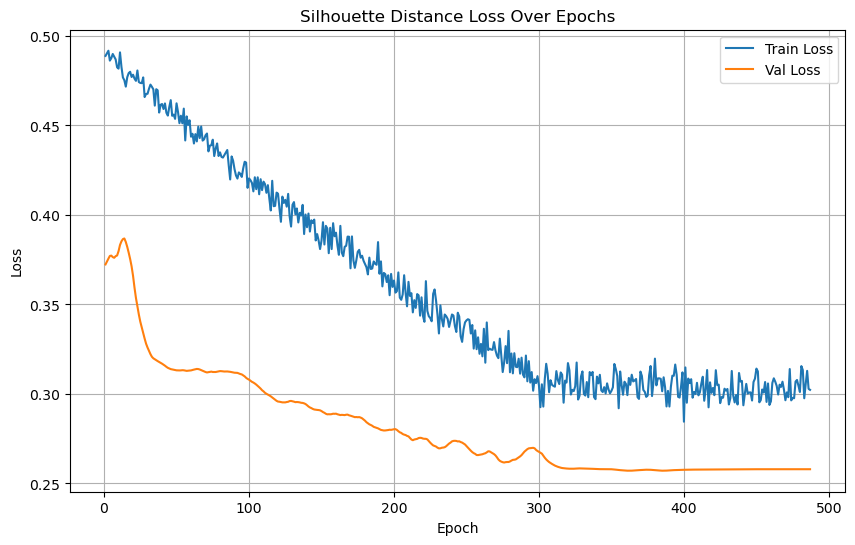

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/49], Loss: 0.1554
Test Batch [20/49], Loss: 0.2381
Test Batch [30/49], Loss: 0.2607


Test Batch [40/49], Loss: 0.1560

Test Loss: 0.2826


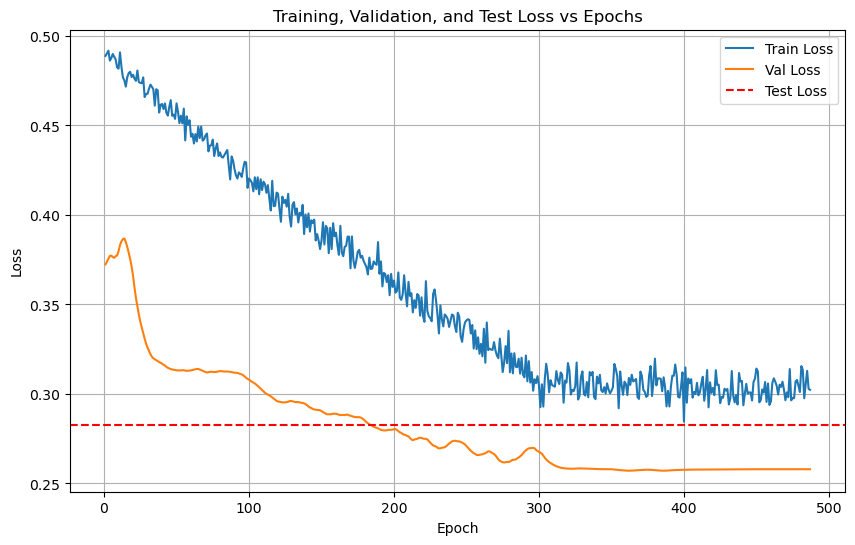

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...


  Processed batch 10/49 for test dataset.
  Processed batch 20/49 for test dataset.


  Processed batch 30/49 for test dataset.


  Processed batch 40/49 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (70, 128)
Train labels shape: (70,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3108, 128)
Test labels shape: (3108,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 80.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.80      0.89         5
           2       0.83      1.00      0.91         5
           3       0.71      1.00      0.83         5
           4       1.00      0.40      0.57         5
           5       0.43      0.60      0.50         5
           6       1.00      0.80      0.89         5
           7       0.80      0.80      0.80         5
           8       0.67      0.80      0.73         5
           9       0.71      1.00      0.83         5
          10       0.60      0.60      0.60         5
          11       1.00      1.00      1.00         5
          12       1.00      0.60      0.75         5
          13       1.0

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (70, 128)
Train labels shape: (70,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3108, 128)
Test labels shape: (3108,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7352  |  Val Loss: 2.7294
Validation loss improved from inf to 2.7294.
[Epoch 2/1000] Train Loss: 2.7194  |  Val Loss: 2.7192
Validation loss improved from 2.7294 to 2.7192.
[Epoch 3/1000] Train Loss: 2.7066  |  Val Loss: 2.7093
Validation loss improved from 2.7192 to 2.7093.
[Epoch 4/1000] Train Loss: 2.6930  |  Val Loss: 2.7000
Validation loss improved from 2.7093 to 2.7000.
[Epoch 5/1000] Train Loss: 2.6810  |  Val Loss: 2.6909
Validation loss improved from 2.7000 to 2.6909.
[Epoch 6/1000] Train Loss: 2.6686  |  Val Loss: 2.6824
Validation loss improved from 2.6909 to 2.6824.
[Epoch 7/1000] Train Loss: 2.6568  |  Val Loss: 2.6737
Validation loss improved from 2.6824 to 2.6737.
[Epoch 8/1000] Train Loss: 2.6450  |  Val Loss: 2.6647
Validation loss improved from 2.6737 to 2.6647.
[Epoch 9/1000] Train Loss: 2.6339  |  Val Loss: 2.6559
Validation loss improved from 2.6647 to 2.6559.
[Epoch 10/1000] Train Loss: 2.6227  |  Val Loss: 2.6477
Validation loss impr

[Epoch 30/1000] Train Loss: 2.4463  |  Val Loss: 2.5167
Validation loss improved from 2.5229 to 2.5167.
[Epoch 31/1000] Train Loss: 2.4384  |  Val Loss: 2.5102
Validation loss improved from 2.5167 to 2.5102.
[Epoch 32/1000] Train Loss: 2.4304  |  Val Loss: 2.5038
Validation loss improved from 2.5102 to 2.5038.
[Epoch 33/1000] Train Loss: 2.4220  |  Val Loss: 2.4976
Validation loss improved from 2.5038 to 2.4976.
[Epoch 34/1000] Train Loss: 2.4135  |  Val Loss: 2.4915
Validation loss improved from 2.4976 to 2.4915.
[Epoch 35/1000] Train Loss: 2.4056  |  Val Loss: 2.4852
Validation loss improved from 2.4915 to 2.4852.
[Epoch 36/1000] Train Loss: 2.3977  |  Val Loss: 2.4791
Validation loss improved from 2.4852 to 2.4791.
[Epoch 37/1000] Train Loss: 2.3894  |  Val Loss: 2.4733
Validation loss improved from 2.4791 to 2.4733.
[Epoch 38/1000] Train Loss: 2.3818  |  Val Loss: 2.4676
Validation loss improved from 2.4733 to 2.4676.
[Epoch 39/1000] Train Loss: 2.3739  |  Val Loss: 2.4622
Validati

[Epoch 40/1000] Train Loss: 2.3662  |  Val Loss: 2.4570
Validation loss improved from 2.4622 to 2.4570.
[Epoch 41/1000] Train Loss: 2.3591  |  Val Loss: 2.4519
Validation loss improved from 2.4570 to 2.4519.
[Epoch 42/1000] Train Loss: 2.3518  |  Val Loss: 2.4467
Validation loss improved from 2.4519 to 2.4467.
[Epoch 43/1000] Train Loss: 2.3444  |  Val Loss: 2.4414
Validation loss improved from 2.4467 to 2.4414.
[Epoch 44/1000] Train Loss: 2.3372  |  Val Loss: 2.4361
Validation loss improved from 2.4414 to 2.4361.
[Epoch 45/1000] Train Loss: 2.3298  |  Val Loss: 2.4308
Validation loss improved from 2.4361 to 2.4308.
[Epoch 46/1000] Train Loss: 2.3227  |  Val Loss: 2.4257
Validation loss improved from 2.4308 to 2.4257.
[Epoch 47/1000] Train Loss: 2.3155  |  Val Loss: 2.4205
Validation loss improved from 2.4257 to 2.4205.
[Epoch 48/1000] Train Loss: 2.3086  |  Val Loss: 2.4150
Validation loss improved from 2.4205 to 2.4150.
[Epoch 49/1000] Train Loss: 2.3017  |  Val Loss: 2.4097
Validati

[Epoch 73/1000] Train Loss: 2.1388  |  Val Loss: 2.2898
Validation loss improved from 2.2953 to 2.2898.
[Epoch 74/1000] Train Loss: 2.1316  |  Val Loss: 2.2843
Validation loss improved from 2.2898 to 2.2843.
[Epoch 75/1000] Train Loss: 2.1244  |  Val Loss: 2.2791
Validation loss improved from 2.2843 to 2.2791.
[Epoch 76/1000] Train Loss: 2.1173  |  Val Loss: 2.2742
Validation loss improved from 2.2791 to 2.2742.
[Epoch 77/1000] Train Loss: 2.1105  |  Val Loss: 2.2695
Validation loss improved from 2.2742 to 2.2695.
[Epoch 78/1000] Train Loss: 2.1036  |  Val Loss: 2.2647
Validation loss improved from 2.2695 to 2.2647.
[Epoch 79/1000] Train Loss: 2.0968  |  Val Loss: 2.2597
Validation loss improved from 2.2647 to 2.2597.
[Epoch 80/1000] Train Loss: 2.0899  |  Val Loss: 2.2547
Validation loss improved from 2.2597 to 2.2547.
[Epoch 81/1000] Train Loss: 2.0831  |  Val Loss: 2.2496
Validation loss improved from 2.2547 to 2.2496.


[Epoch 82/1000] Train Loss: 2.0760  |  Val Loss: 2.2446
Validation loss improved from 2.2496 to 2.2446.
[Epoch 83/1000] Train Loss: 2.0689  |  Val Loss: 2.2397
Validation loss improved from 2.2446 to 2.2397.
[Epoch 84/1000] Train Loss: 2.0618  |  Val Loss: 2.2347
Validation loss improved from 2.2397 to 2.2347.
[Epoch 85/1000] Train Loss: 2.0548  |  Val Loss: 2.2297
Validation loss improved from 2.2347 to 2.2297.
[Epoch 86/1000] Train Loss: 2.0476  |  Val Loss: 2.2244
Validation loss improved from 2.2297 to 2.2244.
[Epoch 87/1000] Train Loss: 2.0403  |  Val Loss: 2.2191
Validation loss improved from 2.2244 to 2.2191.
[Epoch 88/1000] Train Loss: 2.0328  |  Val Loss: 2.2139
Validation loss improved from 2.2191 to 2.2139.
[Epoch 89/1000] Train Loss: 2.0255  |  Val Loss: 2.2087
Validation loss improved from 2.2139 to 2.2087.
[Epoch 90/1000] Train Loss: 2.0183  |  Val Loss: 2.2035
Validation loss improved from 2.2087 to 2.2035.
[Epoch 91/1000] Train Loss: 2.0110  |  Val Loss: 2.1984
Validati

[Epoch 115/1000] Train Loss: 1.8280  |  Val Loss: 2.0623
Validation loss improved from 2.0685 to 2.0623.
[Epoch 116/1000] Train Loss: 1.8201  |  Val Loss: 2.0562
Validation loss improved from 2.0623 to 2.0562.
[Epoch 117/1000] Train Loss: 1.8123  |  Val Loss: 2.0501
Validation loss improved from 2.0562 to 2.0501.
[Epoch 118/1000] Train Loss: 1.8045  |  Val Loss: 2.0441
Validation loss improved from 2.0501 to 2.0441.
[Epoch 119/1000] Train Loss: 1.7965  |  Val Loss: 2.0380
Validation loss improved from 2.0441 to 2.0380.
[Epoch 120/1000] Train Loss: 1.7886  |  Val Loss: 2.0319
Validation loss improved from 2.0380 to 2.0319.
[Epoch 121/1000] Train Loss: 1.7806  |  Val Loss: 2.0258
Validation loss improved from 2.0319 to 2.0258.
[Epoch 122/1000] Train Loss: 1.7725  |  Val Loss: 2.0197
Validation loss improved from 2.0258 to 2.0197.


[Epoch 123/1000] Train Loss: 1.7643  |  Val Loss: 2.0136
Validation loss improved from 2.0197 to 2.0136.
[Epoch 124/1000] Train Loss: 1.7562  |  Val Loss: 2.0074
Validation loss improved from 2.0136 to 2.0074.
[Epoch 125/1000] Train Loss: 1.7479  |  Val Loss: 2.0013
Validation loss improved from 2.0074 to 2.0013.
[Epoch 126/1000] Train Loss: 1.7397  |  Val Loss: 1.9953
Validation loss improved from 2.0013 to 1.9953.
[Epoch 127/1000] Train Loss: 1.7314  |  Val Loss: 1.9895
Validation loss improved from 1.9953 to 1.9895.
[Epoch 128/1000] Train Loss: 1.7233  |  Val Loss: 1.9838
Validation loss improved from 1.9895 to 1.9838.
[Epoch 129/1000] Train Loss: 1.7151  |  Val Loss: 1.9780
Validation loss improved from 1.9838 to 1.9780.
[Epoch 130/1000] Train Loss: 1.7072  |  Val Loss: 1.9721
Validation loss improved from 1.9780 to 1.9721.
[Epoch 131/1000] Train Loss: 1.6992  |  Val Loss: 1.9661
Validation loss improved from 1.9721 to 1.9661.
[Epoch 132/1000] Train Loss: 1.6912  |  Val Loss: 1.960

[Epoch 156/1000] Train Loss: 1.5006  |  Val Loss: 1.8195
Validation loss improved from 1.8254 to 1.8195.
[Epoch 157/1000] Train Loss: 1.4926  |  Val Loss: 1.8137
Validation loss improved from 1.8195 to 1.8137.
[Epoch 158/1000] Train Loss: 1.4848  |  Val Loss: 1.8081
Validation loss improved from 1.8137 to 1.8081.
[Epoch 159/1000] Train Loss: 1.4771  |  Val Loss: 1.8027
Validation loss improved from 1.8081 to 1.8027.
[Epoch 160/1000] Train Loss: 1.4694  |  Val Loss: 1.7973
Validation loss improved from 1.8027 to 1.7973.
[Epoch 161/1000] Train Loss: 1.4618  |  Val Loss: 1.7919
Validation loss improved from 1.7973 to 1.7919.
[Epoch 162/1000] Train Loss: 1.4543  |  Val Loss: 1.7864
Validation loss improved from 1.7919 to 1.7864.


[Epoch 163/1000] Train Loss: 1.4466  |  Val Loss: 1.7811
Validation loss improved from 1.7864 to 1.7811.
[Epoch 164/1000] Train Loss: 1.4391  |  Val Loss: 1.7759
Validation loss improved from 1.7811 to 1.7759.
[Epoch 165/1000] Train Loss: 1.4314  |  Val Loss: 1.7705
Validation loss improved from 1.7759 to 1.7705.
[Epoch 166/1000] Train Loss: 1.4239  |  Val Loss: 1.7650
Validation loss improved from 1.7705 to 1.7650.
[Epoch 167/1000] Train Loss: 1.4164  |  Val Loss: 1.7594
Validation loss improved from 1.7650 to 1.7594.
[Epoch 168/1000] Train Loss: 1.4086  |  Val Loss: 1.7539
Validation loss improved from 1.7594 to 1.7539.
[Epoch 169/1000] Train Loss: 1.4012  |  Val Loss: 1.7482
Validation loss improved from 1.7539 to 1.7482.
[Epoch 170/1000] Train Loss: 1.3933  |  Val Loss: 1.7425
Validation loss improved from 1.7482 to 1.7425.
[Epoch 171/1000] Train Loss: 1.3856  |  Val Loss: 1.7369
Validation loss improved from 1.7425 to 1.7369.
[Epoch 172/1000] Train Loss: 1.3779  |  Val Loss: 1.731

[Epoch 197/1000] Train Loss: 1.1934  |  Val Loss: 1.5961
Validation loss improved from 1.6011 to 1.5961.


[Epoch 198/1000] Train Loss: 1.1866  |  Val Loss: 1.5913
Validation loss improved from 1.5961 to 1.5913.
[Epoch 199/1000] Train Loss: 1.1796  |  Val Loss: 1.5866
Validation loss improved from 1.5913 to 1.5866.
[Epoch 200/1000] Train Loss: 1.1729  |  Val Loss: 1.5820
Validation loss improved from 1.5866 to 1.5820.
[Epoch 201/1000] Train Loss: 1.1662  |  Val Loss: 1.5772
Validation loss improved from 1.5820 to 1.5772.
[Epoch 202/1000] Train Loss: 1.1595  |  Val Loss: 1.5722
Validation loss improved from 1.5772 to 1.5722.
[Epoch 203/1000] Train Loss: 1.1524  |  Val Loss: 1.5670
Validation loss improved from 1.5722 to 1.5670.
[Epoch 204/1000] Train Loss: 1.1456  |  Val Loss: 1.5616
Validation loss improved from 1.5670 to 1.5616.
[Epoch 205/1000] Train Loss: 1.1386  |  Val Loss: 1.5562
Validation loss improved from 1.5616 to 1.5562.
[Epoch 206/1000] Train Loss: 1.1316  |  Val Loss: 1.5508
Validation loss improved from 1.5562 to 1.5508.
[Epoch 207/1000] Train Loss: 1.1249  |  Val Loss: 1.545

[Epoch 240/1000] Train Loss: 0.9166  |  Val Loss: 1.3985
Validation loss improved from 1.4027 to 1.3985.
[Epoch 241/1000] Train Loss: 0.9105  |  Val Loss: 1.3945
Validation loss improved from 1.3985 to 1.3945.
[Epoch 242/1000] Train Loss: 0.9048  |  Val Loss: 1.3908
Validation loss improved from 1.3945 to 1.3908.
[Epoch 243/1000] Train Loss: 0.8990  |  Val Loss: 1.3870
Validation loss improved from 1.3908 to 1.3870.
[Epoch 244/1000] Train Loss: 0.8933  |  Val Loss: 1.3832
Validation loss improved from 1.3870 to 1.3832.
[Epoch 245/1000] Train Loss: 0.8876  |  Val Loss: 1.3798
Validation loss improved from 1.3832 to 1.3798.
[Epoch 246/1000] Train Loss: 0.8820  |  Val Loss: 1.3764
Validation loss improved from 1.3798 to 1.3764.
[Epoch 247/1000] Train Loss: 0.8765  |  Val Loss: 1.3729
Validation loss improved from 1.3764 to 1.3729.
[Epoch 248/1000] Train Loss: 0.8709  |  Val Loss: 1.3693
Validation loss improved from 1.3729 to 1.3693.
[Epoch 249/1000] Train Loss: 0.8653  |  Val Loss: 1.365

[Epoch 280/1000] Train Loss: 0.7073  |  Val Loss: 1.2557
Validation loss improved from 1.2592 to 1.2557.
[Epoch 281/1000] Train Loss: 0.7025  |  Val Loss: 1.2522
Validation loss improved from 1.2557 to 1.2522.
[Epoch 282/1000] Train Loss: 0.6978  |  Val Loss: 1.2487
Validation loss improved from 1.2522 to 1.2487.
[Epoch 283/1000] Train Loss: 0.6934  |  Val Loss: 1.2455
Validation loss improved from 1.2487 to 1.2455.
[Epoch 284/1000] Train Loss: 0.6887  |  Val Loss: 1.2424
Validation loss improved from 1.2455 to 1.2424.
[Epoch 285/1000] Train Loss: 0.6841  |  Val Loss: 1.2392
Validation loss improved from 1.2424 to 1.2392.
[Epoch 286/1000] Train Loss: 0.6794  |  Val Loss: 1.2358
Validation loss improved from 1.2392 to 1.2358.
[Epoch 287/1000] Train Loss: 0.6747  |  Val Loss: 1.2324
Validation loss improved from 1.2358 to 1.2324.
[Epoch 288/1000] Train Loss: 0.6700  |  Val Loss: 1.2292
Validation loss improved from 1.2324 to 1.2292.
[Epoch 289/1000] Train Loss: 0.6654  |  Val Loss: 1.226

[Epoch 319/1000] Train Loss: 0.5435  |  Val Loss: 1.1471
Validation loss improved from 1.1491 to 1.1471.
[Epoch 320/1000] Train Loss: 0.5402  |  Val Loss: 1.1453
Validation loss improved from 1.1471 to 1.1453.
[Epoch 321/1000] Train Loss: 0.5370  |  Val Loss: 1.1435
Validation loss improved from 1.1453 to 1.1435.
[Epoch 322/1000] Train Loss: 0.5339  |  Val Loss: 1.1417
Validation loss improved from 1.1435 to 1.1417.
[Epoch 323/1000] Train Loss: 0.5306  |  Val Loss: 1.1399
Validation loss improved from 1.1417 to 1.1399.
[Epoch 324/1000] Train Loss: 0.5273  |  Val Loss: 1.1377
Validation loss improved from 1.1399 to 1.1377.
[Epoch 325/1000] Train Loss: 0.5237  |  Val Loss: 1.1350
Validation loss improved from 1.1377 to 1.1350.
[Epoch 326/1000] Train Loss: 0.5201  |  Val Loss: 1.1323
Validation loss improved from 1.1350 to 1.1323.
[Epoch 327/1000] Train Loss: 0.5165  |  Val Loss: 1.1297
Validation loss improved from 1.1323 to 1.1297.
[Epoch 328/1000] Train Loss: 0.5127  |  Val Loss: 1.127

[Epoch 362/1000] Train Loss: 0.4032  |  Val Loss: 1.0571
Validation loss improved from 1.0580 to 1.0571.
[Epoch 363/1000] Train Loss: 0.4005  |  Val Loss: 1.0561
Validation loss improved from 1.0571 to 1.0561.
[Epoch 364/1000] Train Loss: 0.3978  |  Val Loss: 1.0548
Validation loss improved from 1.0561 to 1.0548.
[Epoch 365/1000] Train Loss: 0.3952  |  Val Loss: 1.0534
Validation loss improved from 1.0548 to 1.0534.
[Epoch 366/1000] Train Loss: 0.3928  |  Val Loss: 1.0519
Validation loss improved from 1.0534 to 1.0519.
[Epoch 367/1000] Train Loss: 0.3900  |  Val Loss: 1.0501
Validation loss improved from 1.0519 to 1.0501.
[Epoch 368/1000] Train Loss: 0.3872  |  Val Loss: 1.0483
Validation loss improved from 1.0501 to 1.0483.
[Epoch 369/1000] Train Loss: 0.3845  |  Val Loss: 1.0463
Validation loss improved from 1.0483 to 1.0463.
[Epoch 370/1000] Train Loss: 0.3819  |  Val Loss: 1.0441
Validation loss improved from 1.0463 to 1.0441.
[Epoch 371/1000] Train Loss: 0.3793  |  Val Loss: 1.041

[Epoch 403/1000] Train Loss: 0.3034  |  Val Loss: 1.0014
Validation loss improved from 1.0023 to 1.0014.
[Epoch 404/1000] Train Loss: 0.3012  |  Val Loss: 1.0005
Validation loss improved from 1.0014 to 1.0005.
[Epoch 405/1000] Train Loss: 0.2992  |  Val Loss: 0.9998
Validation loss improved from 1.0005 to 0.9998.
[Epoch 406/1000] Train Loss: 0.2971  |  Val Loss: 0.9993
Validation loss improved from 0.9998 to 0.9993.
[Epoch 407/1000] Train Loss: 0.2953  |  Val Loss: 0.9990
Validation loss improved from 0.9993 to 0.9990.
[Epoch 408/1000] Train Loss: 0.2933  |  Val Loss: 0.9987
Validation loss improved from 0.9990 to 0.9987.
[Epoch 409/1000] Train Loss: 0.2915  |  Val Loss: 0.9984
Validation loss improved from 0.9987 to 0.9984.
[Epoch 410/1000] Train Loss: 0.2897  |  Val Loss: 0.9980
Validation loss improved from 0.9984 to 0.9980.
[Epoch 411/1000] Train Loss: 0.2879  |  Val Loss: 0.9974
Validation loss improved from 0.9980 to 0.9974.
[Epoch 412/1000] Train Loss: 0.2862  |  Val Loss: 0.996

[Epoch 444/1000] Train Loss: 0.2309  |  Val Loss: 0.9666
Validation loss improved from 0.9668 to 0.9666.
[Epoch 445/1000] Train Loss: 0.2293  |  Val Loss: 0.9665
Validation loss improved from 0.9666 to 0.9665.
[Epoch 446/1000] Train Loss: 0.2279  |  Val Loss: 0.9664
Validation loss improved from 0.9665 to 0.9664.
[Epoch 447/1000] Train Loss: 0.2263  |  Val Loss: 0.9660
Validation loss improved from 0.9664 to 0.9660.
[Epoch 448/1000] Train Loss: 0.2249  |  Val Loss: 0.9654
Validation loss improved from 0.9660 to 0.9654.
[Epoch 449/1000] Train Loss: 0.2234  |  Val Loss: 0.9646
Validation loss improved from 0.9654 to 0.9646.
[Epoch 450/1000] Train Loss: 0.2220  |  Val Loss: 0.9638
Validation loss improved from 0.9646 to 0.9638.
[Epoch 451/1000] Train Loss: 0.2205  |  Val Loss: 0.9628
Validation loss improved from 0.9638 to 0.9628.
[Epoch 452/1000] Train Loss: 0.2191  |  Val Loss: 0.9620
Validation loss improved from 0.9628 to 0.9620.
[Epoch 453/1000] Train Loss: 0.2176  |  Val Loss: 0.961

[Epoch 481/1000] Train Loss: 0.1811  |  Val Loss: 0.9470
Validation loss improved from 0.9480 to 0.9470.
[Epoch 482/1000] Train Loss: 0.1799  |  Val Loss: 0.9455
Validation loss improved from 0.9470 to 0.9455.
[Epoch 483/1000] Train Loss: 0.1787  |  Val Loss: 0.9440
Validation loss improved from 0.9455 to 0.9440.
[Epoch 484/1000] Train Loss: 0.1776  |  Val Loss: 0.9428
Validation loss improved from 0.9440 to 0.9428.
[Epoch 485/1000] Train Loss: 0.1765  |  Val Loss: 0.9417
Validation loss improved from 0.9428 to 0.9417.
[Epoch 486/1000] Train Loss: 0.1753  |  Val Loss: 0.9410
Validation loss improved from 0.9417 to 0.9410.
[Epoch 487/1000] Train Loss: 0.1742  |  Val Loss: 0.9406
Validation loss improved from 0.9410 to 0.9406.
[Epoch 488/1000] Train Loss: 0.1729  |  Val Loss: 0.9402
Validation loss improved from 0.9406 to 0.9402.
[Epoch 489/1000] Train Loss: 0.1718  |  Val Loss: 0.9399
Validation loss improved from 0.9402 to 0.9399.
[Epoch 490/1000] Train Loss: 0.1707  |  Val Loss: 0.939

[Epoch 523/1000] Train Loss: 0.1364  |  Val Loss: 0.9303
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 524/1000] Train Loss: 0.1355  |  Val Loss: 0.9299
Validation loss improved from 0.9301 to 0.9299.
[Epoch 525/1000] Train Loss: 0.1347  |  Val Loss: 0.9294
Validation loss improved from 0.9299 to 0.9294.
[Epoch 526/1000] Train Loss: 0.1338  |  Val Loss: 0.9287
Validation loss improved from 0.9294 to 0.9287.
[Epoch 527/1000] Train Loss: 0.1330  |  Val Loss: 0.9279
Validation loss improved from 0.9287 to 0.9279.
[Epoch 528/1000] Train Loss: 0.1322  |  Val Loss: 0.9272
Validation loss improved from 0.9279 to 0.9272.
[Epoch 529/1000] Train Loss: 0.1313  |  Val Loss: 0.9272
Validation loss improved from 0.9272 to 0.9272.
[Epoch 530/1000] Train Loss: 0.1304  |  Val Loss: 0.9273
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 531/1000] Train Loss: 0.1295  |  Val Loss: 0.9273
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 532/1000] Train Loss: 0.1286  

[Epoch 568/1000] Train Loss: 0.1021  |  Val Loss: 0.9192
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 569/1000] Train Loss: 0.1016  |  Val Loss: 0.9193
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 570/1000] Train Loss: 0.1010  |  Val Loss: 0.9191
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 571/1000] Train Loss: 0.1005  |  Val Loss: 0.9189
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 572/1000] Train Loss: 0.1000  |  Val Loss: 0.9188
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 573/1000] Train Loss: 0.0995  |  Val Loss: 0.9187
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 574/1000] Train Loss: 0.0990  |  Val Loss: 0.9189
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 575/1000] Train Loss: 0.0986  |  Val Loss: 0.9189
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 576/1000] Train Loss: 0.0980  |  Val Loss: 0.9184
!! Validation loss did NOT improve !! Patience: 1

[Epoch 609/1000] Train Loss: 0.0814  |  Val Loss: 0.9202
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 610/1000] Train Loss: 0.0809  |  Val Loss: 0.9209
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 611/1000] Train Loss: 0.0805  |  Val Loss: 0.9218
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 612/1000] Train Loss: 0.0800  |  Val Loss: 0.9225
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 613/1000] Train Loss: 0.0797  |  Val Loss: 0.9227
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 614/1000] Train Loss: 0.0792  |  Val Loss: 0.9225
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 615/1000] Train Loss: 0.0788  |  Val Loss: 0.9221
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 616/1000] Train Loss: 0.0784  |  Val Loss: 0.9213
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 617/1000] Train Loss: 0.0780  |  Val Loss: 0.9202
!! Validation loss did NOT improve !! Patience:

[Epoch 652/1000] Train Loss: 0.0658  |  Val Loss: 0.9223
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 653/1000] Train Loss: 0.0655  |  Val Loss: 0.9220
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 654/1000] Train Loss: 0.0651  |  Val Loss: 0.9217
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 655/1000] Train Loss: 0.0648  |  Val Loss: 0.9216
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 656/1000] Train Loss: 0.0644  |  Val Loss: 0.9217
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 657/1000] Train Loss: 0.0641  |  Val Loss: 0.9220
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 658/1000] Train Loss: 0.0637  |  Val Loss: 0.9217
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 659/1000] Train Loss: 0.0634  |  Val Loss: 0.9213
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 660/1000] Train Loss: 0.0630  |  Val Loss: 0.9211
!! Validation loss did NOT improve !! Patience:

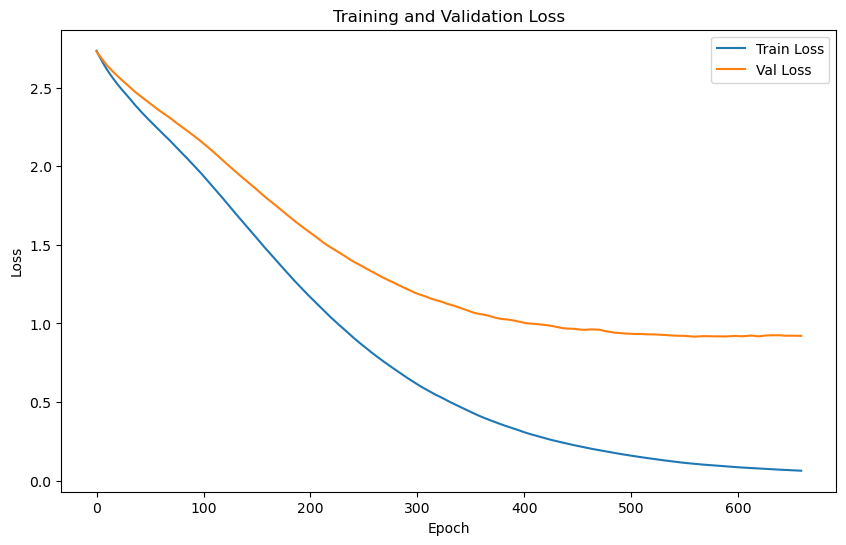

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.7964 | Test Accuracy: 75.93%


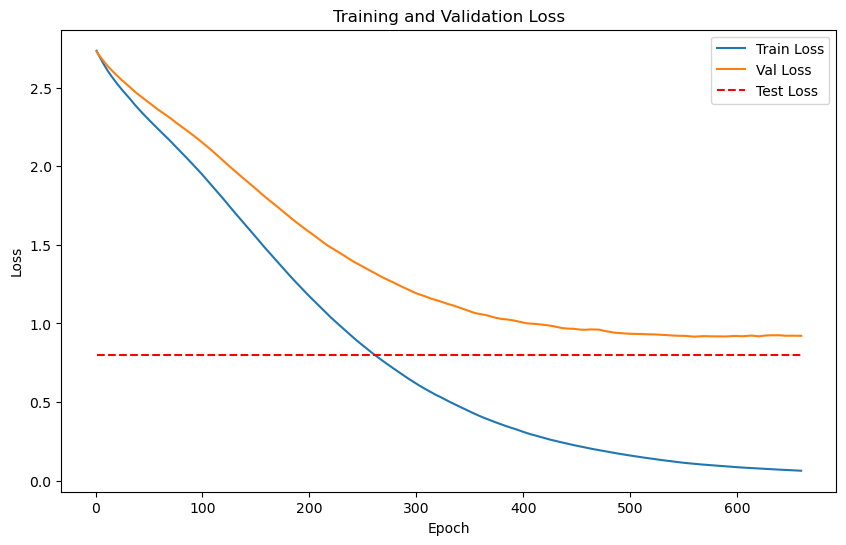

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


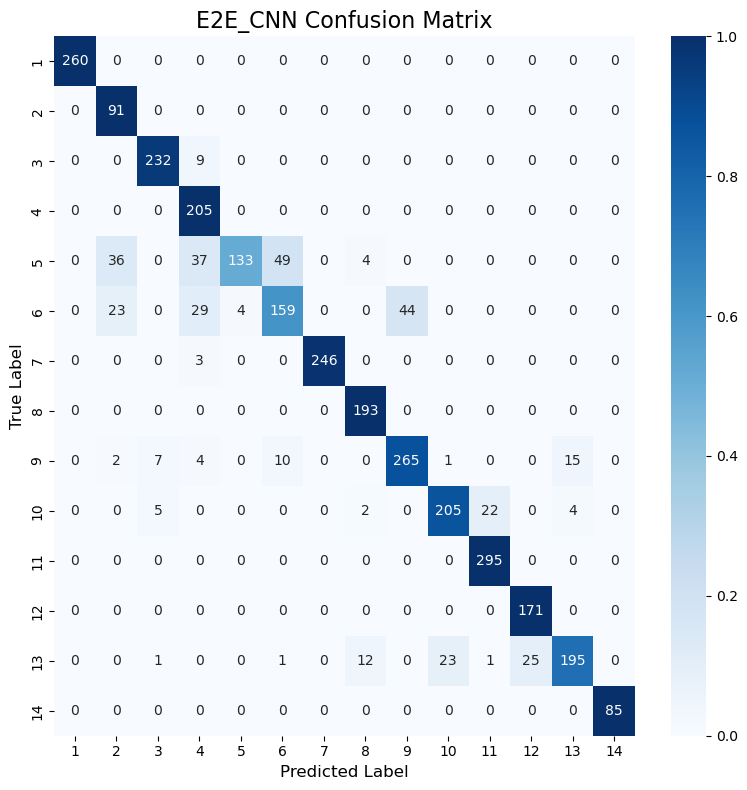

Classification Accuracy: 88.00%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


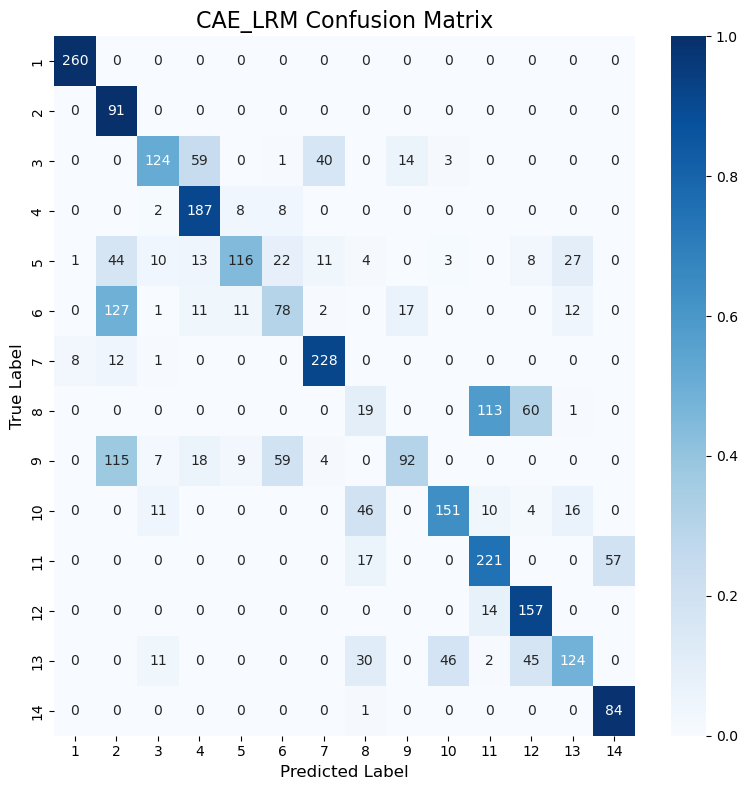

Classification Accuracy: 62.16%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


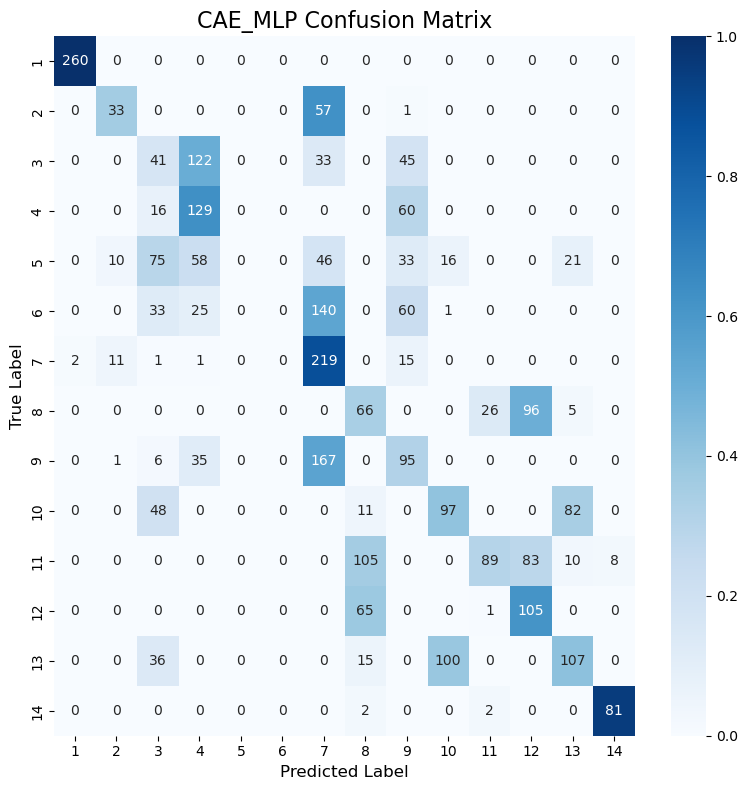

Classification Accuracy: 42.54%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


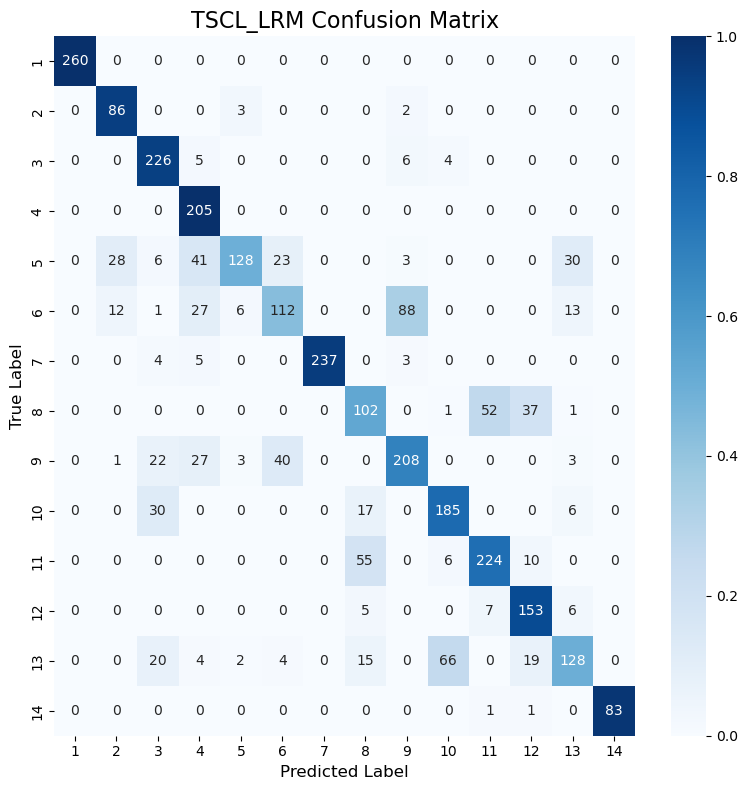

Classification Accuracy: 75.19%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


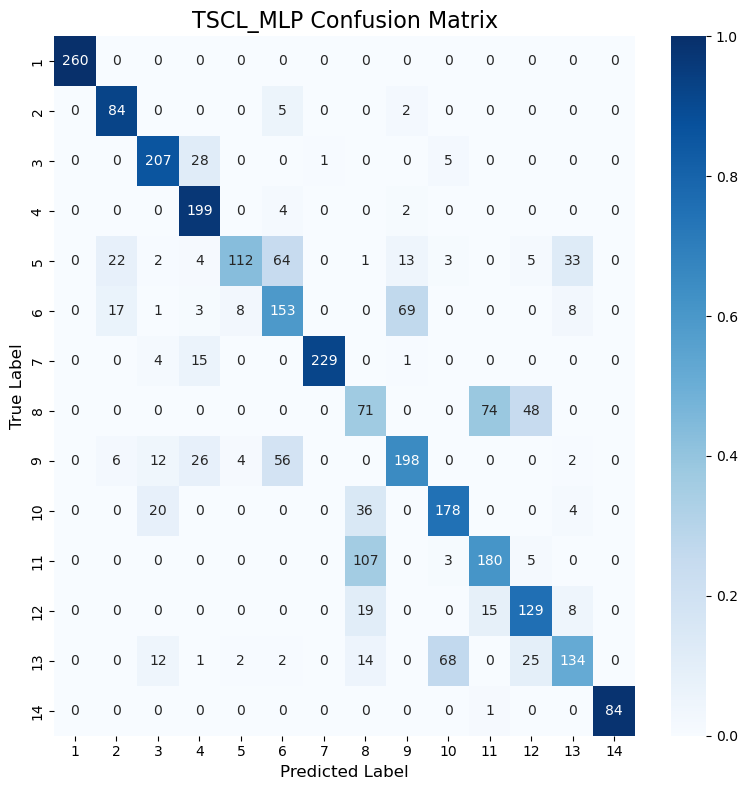

Classification Accuracy: 71.36%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


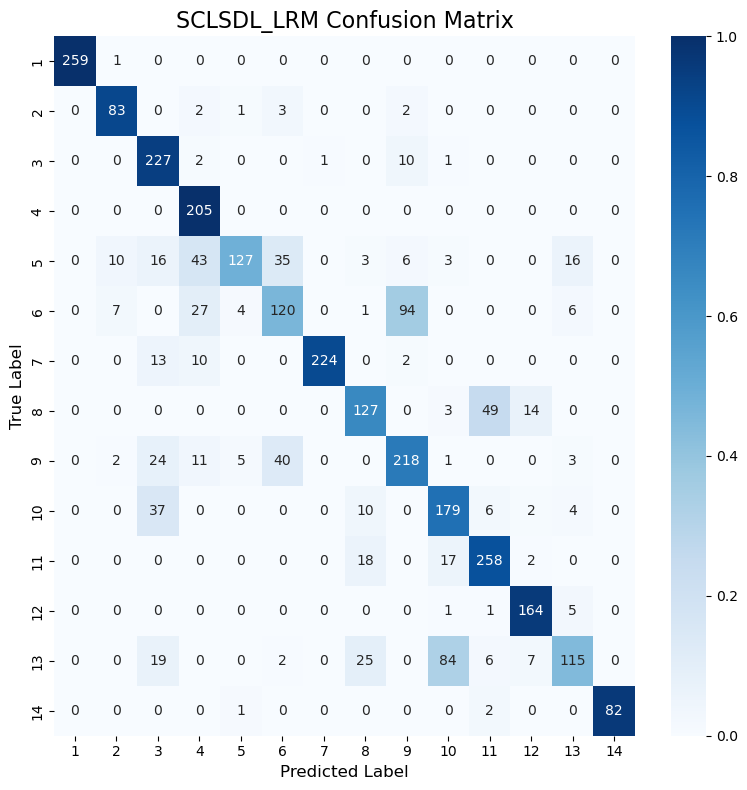

Classification Accuracy: 76.83%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


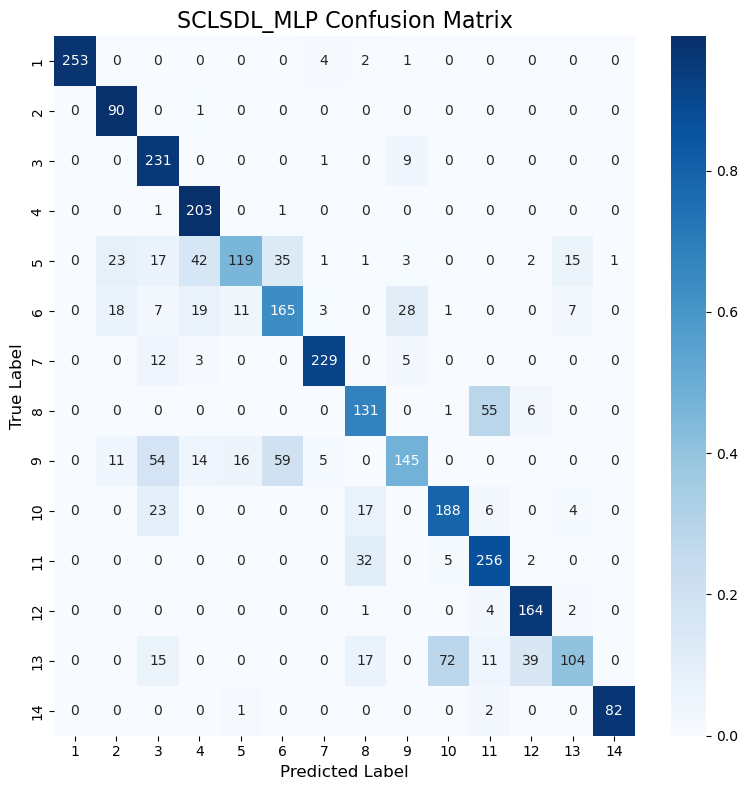

Classification Accuracy: 75.93%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          88.00
1    LRM (CAE)          62.16
2    MLP (CAE)          42.54
3     TSCL LRM          75.19
4     TSCL MLP          71.36
5  SCL_SDL LRM          76.83
6  SCL_SDL MLP          75.93

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          88.00
5  SCL_SDL LRM          76.83
6  SCL_SDL MLP          75.93
3     TSCL LRM          75.19
4     TSCL MLP          71.36
1    LRM (CAE)          62.16
2    MLP (CAE)          42.54
